Now it's time to implement the modeling phase of the project. The goal is to predict whether a given cascade (reddit post or grouping of related reddit posts) will at least double in size when observed at a specific stage. To implement this, I will extract features from the connected components of the post graph at various stages (numbers of responding comments or posts).

In this analysis, I will focus exclusively on temporal features. This is because there is considerable evidence that temporal features alone perform relatively well for this prediction task (a paper by Leskovec et al will be referenced in the final report), and that other features (eg. structural) may bias the predictor against accurate predictions of the large GME cascade, because of the vastly different scale.

Therefore, my hope is that there is enough similarity in temporal cascade structure between smaller and larger cascades for this to provide good predictions.

I will test a number of machine learning algorithms in this section, so I will be importing a large number of libraries.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle as pkl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from rotation_forest import RotationForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

I load the graphs created in the last section. Recall that one has some directed links between posts if they are on the same topic (stock) and were made by someone who commented on the parent post within 24 hours. The other simly contains post-comment cascades.

I will refer to cascades with a single source post as trees, and cascades with multiple source posts as forests, again taking my cue from Leskovec's paper.

In [2]:
graph = nx.read_gpickle(open('posts_graph_connected.pkl','rb'))

In [3]:
graph_trees = nx.read_gpickle(open('posts_graph_disconnected.pkl','rb'))

In terms of nodes and edges, there isn't noticeably much difference between the graphs.

In [4]:
len(graph.nodes())

2482046

In [5]:
len(graph_trees.nodes())

2482046

In [6]:
len(graph.edges())

2282869

In [7]:
len(graph_trees.edges())

2192225

First, I will graphically examine both the forest cascades and the tree cascades.

In [8]:
components_5 = [a for a in nx.weakly_connected_components(graph) if len(a) > 5]

In [9]:
graphs_list = []
for component in components_5:
    g = nx.subgraph(graph,component)
    graphs_list.append(g)

In [10]:
forest_list = []
trees_list = []
for g in graphs_list:
    nodes = [n for n in g.nodes(data=True) if n[1]['posttype'] == 'post']
    if len(nodes) > 4:
        #print(len(nodes))
        forest_list.append(g)
    if len(nodes) == 1:
        trees_list.append(g)

In [11]:
x_vals = []
for forest in forest_list:
    nodes = forest.nodes(data=True)
    sorted_nodes = sorted(nodes,key=lambda k:k[1]['time'])
    if len(sorted_nodes) > 5000:
        interval = sorted_nodes[-1][1]['time'] - sorted_nodes[0][1]['time']
        bin_size = int(np.floor(interval/1000))
        counts = []
        for i in range(1,1000):
            current_min = sorted_nodes[0][1]['time'] + (i-1)*bin_size 
            current_max = sorted_nodes[0][1]['time'] + (i)*bin_size
            current_count = 0
            for node in sorted_nodes:
                if node[1]['time'] > current_min and node[1]['time'] < current_max:
                    current_count += 1
            counts.append(current_count)
        x_vals.append(counts)
        #print(len(x_vals))

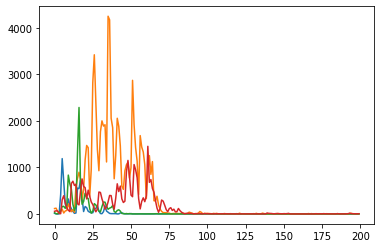

In [12]:
plt.plot(x_vals[0][:200])
plt.plot(x_vals[1][:200])
plt.plot(x_vals[2][:200])
plt.plot(x_vals[3][:200])

As can be seen above, forest cascades typically begin relatively small, but reach their peak quickly in their life cycle before mostly dying off.

Below, I have included a much larger cascade with the others above. Besides being significantly larger, it also peaked at a later relative time, which may make predicting forest cascades more challenging.

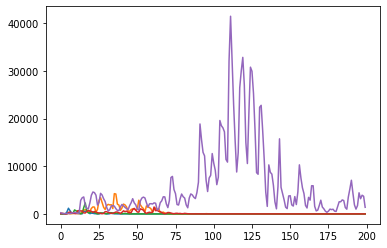

In [13]:
plt.plot(x_vals[0][:200])
plt.plot(x_vals[1][:200])
plt.plot(x_vals[2][:200])
plt.plot(x_vals[3][:200])
plt.plot(x_vals[4][:200])

The tree cascades, on the other hand, typically peak immediately, and drop off very fast. This makes intuitive sense, since they have only one root post, and popular posts on Reddit tend to become active very quickly.

In [14]:
x_vals_tree = []
for tree in trees_list:
    nodes = tree.nodes(data=True)
    sorted_nodes = sorted(nodes,key=lambda k:k[1]['time'])
    if len(sorted_nodes) > 500:
        interval = sorted_nodes[-1][1]['time'] - sorted_nodes[0][1]['time']
        bin_size = int(np.floor(interval/1000))
        counts = []
        for i in range(1,1000):
            current_min = sorted_nodes[0][1]['time'] + (i-1)*bin_size 
            current_max = sorted_nodes[0][1]['time'] + (i)*bin_size
            current_count = 0
            for node in sorted_nodes:
                if node[1]['time'] > current_min and node[1]['time'] < current_max:
                    current_count += 1
            counts.append(current_count)
        x_vals_tree.append(counts)
        #print(len(x_vals_tree))

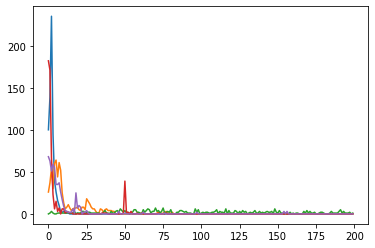

In [15]:
plt.plot(x_vals_tree[0][:200])
plt.plot(x_vals_tree[1][:200])
plt.plot(x_vals_tree[2][:200])
plt.plot(x_vals_tree[3][:200])
plt.plot(x_vals_tree[4][:200])

I will experiment with the graph of trees first, though predicting the forests is the more useful task in this instance, since it is large groupings of reddit posts that spawn the collective action resulting in events like the Gamestop stock explosion.

Here, I extract all weakly connected components of the tree graph. A weakly connected component is just a group of nodes, each of which are connected by undirected path.

In [16]:
components_100 = [a for a in nx.weakly_connected_components(graph_trees) if len(a) > 100]

In [17]:
len(components_100)

3990

Here, I split the trees into 5 separate 'folds' for cross validation in order to produce the most accurate model. I am performing this step here because I will be extracting multiple data rows from some of the trees to have more data available, and I don't want rows relating to the same trees being in both the training set and the test set, to ensure that my results aren't biased. However, this means that the sizes of the train and test sets won't always be the same for each fold.

In [18]:
tree_list = []
for component in components_100:
    g = nx.subgraph(graph_trees,component)
    tree_list.append(g)

In [19]:
random.shuffle(tree_list)

In [20]:
train_tree_folds = []
test_tree_folds = []

In [21]:
for i in range(5):
    test_trees = tree_list[int(np.floor(i*len(tree_list)/5)):int(np.floor((i+1)*len(tree_list)/5))]
    train_trees = tree_list
    train_trees = [t for t in train_trees if t not in test_trees]
    train_tree_folds.append(train_trees)
    test_tree_folds.append(test_trees)

In [22]:
len(test_tree_folds[0])

798

Now, I extract the temporal features relating to each tree. I iterate over all the trees in the training set for each fold, and calculate the various temporal features. The features are very simple, consisting of averages of the time it takes for a new node to be added at various intervals, and their ratios.

In [23]:
def extract_features_trees(folds):
    tree_features_list = []
    for k in range(5):    
        tree_features = pd.DataFrame()

        count = 0
        for tree in folds[k]:
            print(count)
            f = nx.DiGraph(tree)
            sorted_nodes = sorted([n for n in f.nodes(data=True)], key=lambda x: x[1]['time'])
            steps = [100 + i*100 for i in range(100)]

            for step in steps:
            #for step in [1000,1250,1500,1750,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,15000,17500,20000,22000,25000,30000,35000,40000,50000,60000,70000,80000,90000,100000,125000,150000,175000,200000]:
                if len(sorted_nodes) < step:
                    break
                count += 1
                if len(sorted_nodes) > 2*step:
                    result = 1
                else:
                    result = 0

                all_nodes_first_half = sorted_nodes[:int(np.floor(step/2))]
                all_nodes_second_half = sorted_nodes[int(np.floor(step/2)):step]

                avg_time_first_half_all = np.mean([all_nodes_first_half[i][1]['time'] - all_nodes_first_half[i-1][1]['time'] for i in range(1,len(all_nodes_first_half))])

                avg_time_second_half_all = np.mean([all_nodes_second_half[i][1]['time'] - all_nodes_second_half[i-1][1]['time'] for i in range(1,len(all_nodes_second_half))])
                #print(avg_time_second_half_all)
                ratio_all = avg_time_second_half_all / avg_time_first_half_all

                all_nodes_first_q = sorted_nodes[:int(np.floor(step/4))]
                all_nodes_second_q = sorted_nodes[int(np.floor(step/4)):int(2*np.floor(step/4))]
                all_nodes_third_q = sorted_nodes[int(2*np.floor(step/4)):int(3*np.floor(step/4))]
                all_nodes_fourth_q = sorted_nodes[int(3*np.floor(step/4)):step]

                avg_time_first_q_all = np.mean([all_nodes_first_q[i][1]['time'] - all_nodes_first_q[i-1][1]['time'] for i in range(1,len(all_nodes_first_q))])
                avg_time_second_q_all = np.mean([all_nodes_second_q[i][1]['time'] - all_nodes_second_q[i-1][1]['time'] for i in range(1,len(all_nodes_second_q))])
                avg_time_third_q_all = np.mean([all_nodes_third_q[i][1]['time'] - all_nodes_third_q[i-1][1]['time'] for i in range(1,len(all_nodes_third_q))])
                avg_time_fourth_q_all = np.mean([all_nodes_fourth_q[i][1]['time'] - all_nodes_fourth_q[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_q))])
                ratio_43 = avg_time_fourth_q_all/avg_time_third_q_all
                ratio_42 = avg_time_fourth_q_all/avg_time_second_q_all
                ratio_41 = avg_time_fourth_q_all/avg_time_first_q_all

                all_nodes_first_10 = sorted_nodes[:int(np.floor(step/10))]
                all_nodes_second_10 = sorted_nodes[int(np.floor(step/10)):int(2*np.floor(step/10))]
                all_nodes_third_10 = sorted_nodes[int(2*np.floor(step/10)):int(3*np.floor(step/10))]
                all_nodes_fourth_10 = sorted_nodes[int(3*np.floor(step/10)):int(4*np.floor(step/10))]
                all_nodes_fifth_10 = sorted_nodes[int(4*np.floor(step/10)):int(5*np.floor(step/10))]
                all_nodes_sixth_10 = sorted_nodes[int(5*np.floor(step/10)):int(6*np.floor(step/10))]
                all_nodes_seventh_10 = sorted_nodes[int(6*np.floor(step/10)):int(7*np.floor(step/10))]
                all_nodes_eighth_10 = sorted_nodes[int(7*np.floor(step/10)):int(8*np.floor(step/10))]
                all_nodes_ninth_10 = sorted_nodes[int(8*np.floor(step/10)):int(9*np.floor(step/10))]
                all_nodes_last_10 = sorted_nodes[int(9*np.floor(step/10)):step]

                avg_time_first_10_all = np.mean([all_nodes_first_10[i][1]['time'] - all_nodes_first_10[i-1][1]['time'] for i in range(1,len(all_nodes_first_10))])
                avg_time_second_10_all = np.mean([all_nodes_second_10[i][1]['time'] - all_nodes_second_10[i-1][1]['time'] for i in range(1,len(all_nodes_second_10))])
                avg_time_third_10_all = np.mean([all_nodes_third_10[i][1]['time'] - all_nodes_third_10[i-1][1]['time'] for i in range(1,len(all_nodes_third_10))])
                avg_time_fourth_10_all = np.mean([all_nodes_fourth_10[i][1]['time'] - all_nodes_fourth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_10))])
                avg_time_fifth_10_all = np.mean([all_nodes_fifth_10[i][1]['time'] - all_nodes_fifth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fifth_10))])
                avg_time_sixth_10_all = np.mean([all_nodes_sixth_10[i][1]['time'] - all_nodes_sixth_10[i-1][1]['time'] for i in range(1,len(all_nodes_sixth_10))])
                avg_time_seventh_10_all = np.mean([all_nodes_seventh_10[i][1]['time'] - all_nodes_seventh_10[i-1][1]['time'] for i in range(1,len(all_nodes_seventh_10))])
                avg_time_eighth_10_all = np.mean([all_nodes_eighth_10[i][1]['time'] - all_nodes_eighth_10[i-1][1]['time'] for i in range(1,len(all_nodes_eighth_10))])
                avg_time_ninth_10_all = np.mean([all_nodes_ninth_10[i][1]['time'] - all_nodes_ninth_10[i-1][1]['time'] for i in range(1,len(all_nodes_ninth_10))])
                avg_time_last_10_all = np.mean([all_nodes_last_10[i][1]['time'] - all_nodes_last_10[i-1][1]['time'] for i in range(1,len(all_nodes_last_10))])

                ratio_109 = avg_time_last_10_all/avg_time_ninth_10_all
                ratio_108 = avg_time_last_10_all/avg_time_eighth_10_all
                ratio_106 = avg_time_last_10_all/avg_time_sixth_10_all
                ratio_101 = avg_time_last_10_all/avg_time_first_10_all


                tree_features = tree_features.append({'avg_time_last_10_all':avg_time_last_10_all,'avg_time_ninth_10_all':avg_time_ninth_10_all,
                                                                  'avg_time_eighth_10_all':avg_time_eighth_10_all,'ratio_109':ratio_109,'ratio_108':ratio_108,'ratio_106':ratio_106,'ratio_101':ratio_101,'ratio_42':ratio_42,'ratio_41':ratio_41,'avg_time_first_half_all':avg_time_first_half_all,'avg_time_second_half_all':avg_time_second_half_all,
                                                'ratio_all':ratio_all,'avg_time_third_q_all':avg_time_third_q_all,'avg_time_fourth_q_all':avg_time_fourth_q_all,'ratio_43':ratio_43,'class':result},ignore_index=True)
        tree_features_list.append(tree_features)
    return tree_features_list

In [24]:
train_tree_features_list = extract_features_trees(train_tree_folds)
test_tree_features_list = extract_features_trees(test_tree_folds)

0
318.2040816326531
1
101.40816326530613
63.878787878787875
803.751677852349
4
386.9795918367347
179.56565656565655
1215.6308724832215
7
28.693877551020407
218.06060606060606
9
51.55102040816327
87.23232323232324
29.449664429530202
34.537688442211056
39.325301204819276
98.52173913043478
15
25.040816326530614
35.4040404040404
36.93288590604027
32.085427135678394
39.136546184738954
34.26086956521739
33.12320916905444
77.43859649122807
23
87.06122448979592
57.82828282828283
25
568.7551020408164
26
80.16326530612245
80.26262626262626
76.48322147651007
89.06030150753769
204.51004016064257
31
56.04081632653061
28.03030303030303
18.389261744966444
15.894472361809045
35
859.9591836734694
36
72.3265306122449
188.04040404040404
38
28.877551020408163
129.1010101010101
40
26.020408163265305
13.858585858585858
14.161073825503356
13.296482412060302
10.208835341365463
8.735785953177258
8.53295128939828
9.06265664160401
9.334075723830734
11.344689378757515
17.53369763205829
32.70617696160267
117.77041

157.91836734693877
424
167.24489795918367
353.6060606060606
426
118.9795918367347
427
14.489795918367347
52.13131313131313
429
717.1836734693877
430
93.59183673469387
64.27272727272727
93.38255033557047
433
411.57142857142856
695.9090909090909
74137.61073825504
436
8.489795918367347
37.06060606060606
438
145.6326530612245
536.030303030303
440
317.1224489795918
441
87.91836734693878
84.44444444444444
92.40939597315436
83.21105527638191
258.53413654618475
446
484.14285714285717
447
34.714285714285715
448
274.2448979591837
449
27.714285714285715
65.68686868686869
1022.0939597315436
452
40.224489795918366
46.656565656565654
24.44295302013423
13.487437185929648
11.373493975903614
11.692307692307692
10.739255014326648
10.531328320802006
11.10913140311804
12.541082164328657
14.744990892531876
26.098497495826376
464
4424.34693877551
465
34.95918367346939
156.3939393939394
467
76.81632653061224
52.98989898989899
84.08724832214764
1815.5075376884422
471
5.836734693877551
8.777777777777779
11.436

115.13277133825079
148.17617617617617
864
84.63265306122449
110.87878787878788
121.24161073825503
178.10552763819095
868
101.3265306122449
869
63.10204081632653
129.32323232323233
228.4228187919463
872
588.3877551020408
873
438.38775510204084
874
308.14285714285717
369.3131313131313
876
212.0612244897959
605.5252525252525
878
93.38775510204081
879
99.42857142857143
880
143.26530612244898
245.04040404040404
10130.697986577181
883
33.734693877551024
35.78787878787879
62.76510067114094
74.51758793969849
88.89558232931726
119.02341137123746
156.26361031518624
890
508.48979591836735
891
11.326530612244898
24.171717171717173
893
339.0204081632653
894
166.0408163265306
215.74747474747474
896
154.6326530612245
897
70.38775510204081
119.18181818181819
347.2684563758389
900
10.63265306122449
14.606060606060606
13.61744966442953
15.160804020100503
36.204819277108435
46.197324414715716
133.64469914040114
907
6.714285714285714
10.090909090909092
15.201342281879194
17.884422110552762
18.967871485943

38.0
28.303030303030305
19.476510067114095
19.246231155778894
22.100401606425702
21.220735785953178
19.068767908309457
18.43107769423559
17.501113585746104
18.517034068136272
20.309653916211293
24.530884808013354
31.41448382126348
52.54077253218884
68.4939919893191
1310
44.04081632653061
26.11111111111111
30.29530201342282
42.88442211055276
59.27710843373494
163.9297658862876
1316
208.0204081632653
1317
134.75510204081633
1318
21.428571428571427
14.151515151515152
29.140939597315437
40.26130653266332
52.204819277108435
64.51839464882943
111.57593123209169
1325
70.89795918367346
68.43434343434343
89.81208053691275
137.36683417085428
1329
138.3469387755102
83.20202020202021
100.98657718120805
191.33165829145727
31834.602409638555
1334
58.93877551020408
1335
298.734693877551
1336
430.46938775510205
1337
17.346938775510203
1338
186.69387755102042
136.74747474747474
238.5704697986577
1341
710.7142857142857
1342
115.22448979591837
154.32323232323233
182.25503355704697
1345
465.8979591836735


37.51020408163265
17.565656565656564
16.08724832214765
14.462311557788945
31.53012048192771
1731
601.9387755102041
1732
83.44897959183673
45.878787878787875
53.53691275167785
100.8643216080402
3038.8192771084337
1737
87.9795918367347
129.45454545454547
1739
9.795918367346939
9.545454545454545
29.61744966442953
1742
223.0408163265306
1743
218.3673469387755
1744
190.55102040816325
1745
131.12244897959184
1746
192.69387755102042
704.6969696969697
1748
72.46938775510205
251.24242424242425
1750
215.59183673469389
736.3737373737374
1752
377.3469387755102
1753
232.81632653061226
1754
70394.55102040817
1755
100.95918367346938
95.42424242424242
102.77181208053692
325.79899497487435
1759
27.46938775510204
1760
31.040816326530614
1761
47.46938775510204
478.7070707070707
1763
52.69387755102041
1764
24.714285714285715
26.87878787878788
19.42281879194631
20.025125628140703
18.21285140562249
17.274247491638796
14.722063037249283
17.31077694235589
17.91314031180401
18.88577154308617
19.562841530054644

34.06122448979592
38.525252525252526
41.52348993288591
33.49748743718593
35.437751004016064
58.020066889632105
78.38968481375358
284.0952380952381
2172
221.83673469387756
2173
100.57142857142857
2174
1918.061224489796
2175
37.265306122448976
46.09090909090909
298.97986577181206
2178
9.653061224489797
34.343434343434346
284.9865771812081
2181
38.734693877551024
49.666666666666664
33.93288590604027
34.92964824120603
38.7429718875502
43.357859531772576
47.96275071633238
76.17543859649123
368.92873051224944
2190
114.12244897959184
2191
61.265306122448976
38.36363636363637
38.2751677852349
52.994974874371856
79.22088353413655
145.2173913043478
2197
49.95918367346939
62.77777777777778
50.15436241610738
51.7286432160804
2201
198.44897959183675
2202
130.6530612244898
231.83838383838383
2204
428.9591836734694
2205
60.04081632653061
61.37373737373738
159.55704697986576
163.07035175879398
171.7429718875502
341.1571906354515
1781.6131805157593
9592.568922305765
2213
57.734693877551024
118.55555555

836.7755102040817
2594
127.14285714285714
247.75757575757575
2596
26.612244897959183
13.686868686868687
10.926174496644295
10.050251256281408
10.116465863453815
10.565217391304348
11.04297994269341
11.583959899749374
11.90423162583519
12.238476953907815
12.462659380692168
12.67278797996661
13.17873651771957
13.065808297567955
12.86648865153538
13.007509386733418
12.546525323910483
12.441601779755283
12.926238145416228
13.674674674674675
14.561487130600572
16.605095541401273
19.123585726718886
25.636363636363637
40.6693354683747
2621
419.8979591836735
2622
4315.448979591837
2623
90.48979591836735
96.92929292929293
237.73825503355704
2626
15.16326530612245
7.646464646464646
6.718120805369128
5.919597989949748
5.473895582329317
5.989966555183947
6.833810888252149
9.849624060150376
2634
33.224489795918366
70.24242424242425
34.013422818791945
26.532663316582916
31.690763052208837
60.725752508361204
2640
75.61224489795919
98.57575757575758
797.3087248322148
2643
693.9591836734694
2644
144.81

89.95918367346938
47.101010101010104
74.90604026845638
97.60804020100502
3034
248.6326530612245
3035
131.69387755102042
3036
120.42857142857143
164.96969696969697
3038
652.3265306122449
3039
206.89795918367346
3040
14.755102040816327
33.5959595959596
3042
31.877551020408163
32.82828282828283
24.563758389261746
20.944723618090453
21.72289156626506
24.51505016722408
30.87106017191977
74.5062656641604
3050
29.591836734693878
3051
230.85714285714286
3052
25.918367346938776
3053
42.46938775510204
45.06060606060606
28.013422818791945
23.251256281407034
22.052208835341364
25.247491638795985
24.9054441260745
24.859649122807017
25.49665924276169
35.38677354709419
117.18032786885246
3064
432.59183673469386
3065
203.0408163265306
235.08080808080808
3067
64.73469387755102
60.26262626262626
44.80536912751678
35.66834170854271
39.52208835341366
45.79933110367893
68.71060171919771
661.812030075188
3075
22.79591836734694
3076
202.20408163265307
3077
129.16326530612244
315.90909090909093
3079
16.244897

153.3877551020408
3455
93.18367346938776
3456
409.81632653061223
3457
211.0204081632653
3458
550.9387755102041
3459
64.65306122448979
3460
196.6326530612245
3461
149.3877551020408
366.3838383838384
3463
74.89795918367346
81.97979797979798
328.8523489932886
3466
611.2857142857143
3467
664.0204081632653
3468
88.24489795918367
3469
393.6938775510204
3470
1185.2448979591836
3471
14.081632653061224
61.464646464646464
3473
177.3877551020408
430.4141414141414
3475
252.91836734693877
49117.52525252525
3477
221.85714285714286
379.2323232323232
3479
21.918367346938776
20.68686868686869
20.83221476510067
18.256281407035175
18.068273092369477
16.54180602006689
15.160458452722063
13.842105263157896
12.329621380846325
10.949899799599198
9.846994535519126
8.70617696160267
8.733436055469953
3492
71.9795918367347
308.1111111111111
3494
104.46938775510205
3495
687.6326530612245
3496
474.6530612244898
3497
143.0
321.1515151515151
3499
19.26530612244898
22.242424242424242
64.47651006711409
3502
87.9387755

47.373493975903614
60.37123745819398
67.79942693409743
72.76441102756893
118.34521158129176
3877
1005.265306122449
3878
15.46938775510204
16.575757575757574
19.973154362416107
26.944723618090453
35.76305220883534
46.04347826086956
58.74498567335244
108.96491228070175
3886
139.0408163265306
3887
7.244897959183674
9.464646464646465
13.838926174496644
23.92964824120603
27.666666666666668
28.762541806020067
37.42406876790831
74.47619047619048
3895
93.71428571428571
3896
164.71428571428572
351.0
3898
7.510204081632653
3899
58.3469387755102
39.81818181818182
38.51006711409396
41.54773869346734
42.6425702811245
76.07357859531773
1680.352435530086
3906
47.38775510204081
3907
35.63265306122449
398.54545454545456
3909
207.12244897959184
3910
127.14285714285714
269.04040404040404
9188.825503355705
3913
154.24489795918367
3914
302.6530612244898
3915
809.6326530612245
3916
202.6326530612245
322.5050505050505
397.6979865771812
3919
13.755102040816327
11.363636363636363
9.10738255033557
3922
131.3265

10.714285714285714
21.151515151515152
38.006711409395976
84.36683417085428
4294
36.02040816326531
803.939393939394
4296
81.65306122448979
4297
22.6734693877551
28.424242424242426
26.08724832214765
27.231155778894472
30.188755020080322
28.892976588628763
31.97134670487106
32.849624060150376
33.04899777282851
33.68937875751503
33.06739526411658
32.62604340567613
29.75346687211094
27.42346208869814
26.15487316421896
27.126408010012515
28.97997644287397
31.56840934371524
49.42992623814541
66.72572572572572
132.15633937082936
377.4968152866242
8253.702349869453
4320
15.755102040816327
12.828282828282829
12.48993288590604
18.768844221105528
64.17670682730923
4325
19.612244897959183
4326
75.59183673469387
79.87878787878788
58.671140939597315
44.06532663316583
42.10843373493976
60.87290969899666
4332
177.0204081632653
303.32323232323233
2218.1677852348994
3444.8442211055276
46761.353413654615
4337
92.77551020408163
49.85858585858586
34.281879194630875
21.809045226130653
22.2570281124498
29.458

32.22222222222222
27.85234899328859
37.7035175879397
49.40160642570281
64.84949832775919
105.03724928366762
4738
29.816326530612244
16.161616161616163
8.845637583892618
6.407035175879397
4.78714859437751
3.729096989966555
3.1318051575931234
2.8471177944862154
2.6302895322939865
2.3927855711422845
2.242258652094718
2.0984974958263773
1.9799691833590138
1.882689556509299
1.6902536715620828
1.5619524405506884
1.5889281507656066
3.513904338153504
4756
137.91836734693877
4757
6.714285714285714
4758
97.9795918367347
4759
12.36734693877551
12.707070707070708
13.093959731543624
14.839195979899497
15.465863453815262
13.869565217391305
14.312320916905444
14.701754385964913
15.271714922048998
15.376753507014028
15.956284153005464
17.796327212020035
20.67950693374422
25.15021459227468
38.63818424566088
69.70963704630789
5346.8056537102475
4776
357.6530612244898
4777
131.9387755102041
4778
161.3469387755102
305.6060606060606
4780
83.42857142857143
4781
192.3469387755102
4782
30.510204081632654
4783

954.795918367347
211.0909090909091
156.3221476510067
239.03517587939697
217.7871485943775
164.77591973244148
201.14613180515758
235.47117794486215
5161
187.75510204081633
5162
623.0408163265306
5163
23.448979591836736
5164
61.02040816326531
82.0
36.241610738255034
27.77889447236181
28.89156626506024
30.354515050167223
30.936962750716333
38.423558897243105
52.26503340757238
72.02004008016031
139.91621129326046
5175
124.77551020408163
5176
16.020408163265305
10.444444444444445
8.026845637583893
7.36180904522613
6.196787148594377
4.929765886287625
3.7822349570200573
3.175438596491228
3.2271714922048997
3.3887775551102206
3.724954462659381
4.702838063439065
5.098613251155624
5.839771101573676
6.734312416555407
5191
174.6530612244898
5192
50.244897959183675
60.58585858585859
74.3758389261745
113.71859296482413
5196
447.0816326530612
5197
185.30612244897958
417.34343434343435
5199
2626.0408163265306
5200
224.42857142857142
5201
50.857142857142854
62.898989898989896
118.14765100671141
11156.4

9.197563098346388
9.76396997497915
9.946357085668534
10.195535026943803
10.474425500370645
10.875625446747677
11.382332643202208
12.449633088725816
13.198192382182054
16.52157598499062
20.557913887204368
28.91053560918187
169.1503716409377
5613
1542.6326530612246
5614
13.489795918367347
18.525252525252526
27.993288590604028
31.22613065326633
28.16867469879518
27.29096989966555
30.183381088825215
43.51127819548872
5622
29.0
47.101010101010104
91.30201342281879
256.79396984924625
5626
180.71428571428572
5627
163.18367346938774
1337.989898989899
5629
323.55102040816325
5630
122.28571428571429
91.35353535353535
52.50335570469799
74.27638190954774
5634
141.89795918367346
203.7171717171717
5636
18.918367346938776
12.545454545454545
11.409395973154362
8.407035175879397
6.052208835341365
4.424749163879599
3.7707736389684814
3.0852130325814535
2.538975501113586
2.372745490981964
2.214936247723133
2.2036727879799667
2.12788906009245
2.2303290414878396
2.2843791722296394
2.3591989987484356
2.4935

1.2064714946070878
1.167381974248927
1.1922563417890522
1.2152690863579474
1.3851590106007068
1.7274749721913236
2.350895679662803
4.328328328328328
16.71115347950429
6042
11.020408163265307
23.636363636363637
371.1409395973154
6045
60.93877551020408
6046
47.6530612244898
6047
174.9387755102041
108.47474747474747
6049
104.14285714285714
187.55555555555554
6051
29.081632653061224
6052
53.02040816326531
6053
157.0
6054
200.9591836734694
6055
90.48979591836735
6056
49.46938775510204
57.21212121212121
56.16107382550336
60.4321608040201
109.66666666666667
6061
15.551020408163266
6062
149.46938775510205
326.32323232323233
5749.4496644295305
6065
223.9387755102041
6066
19.510204081632654
20.7979797979798
71.79194630872483
6069
45.87755102040816
6070
42.40816326530612
6071
336.42857142857144
6072
410.14285714285717
6073
125.53061224489795
124.81818181818181
6075
32.42857142857143
51.525252525252526
161.91275167785236
6078
43.44897959183673
48.74747474747475
53.51006711409396
6081
327.755102040

134.75510204081633
37.63636363636363
13.483221476510067
12.743718592964823
14.538152610441767
13.68227424749164
13.885386819484241
42.86466165413534
71.16703786191536
6475
908.4285714285714
6476
68.71428571428571
158.57575757575756
586.1543624161073
6479
767.1224489795918
6480
74.71428571428571
51.60606060606061
173.3758389261745
218.78391959798995
6484
449.7755102040816
56535.17171717172
6486
618.9387755102041
6487
6.326530612244898
15.575757575757576
6489
93.28571428571429
6490
54.714285714285715
40.656565656565654
37.59060402684564
35.34170854271357
40.04819277108434
45.01672240802676
57.598853868194844
154.59899749373434
6498
11.612244897959183
32.292929292929294
6500
50.02040816326531
71.53535353535354
55.95302013422819
36.49748743718593
37.393574297188756
96.62541806020067
6506
66.44897959183673
55.37373737373738
46.261744966442954
38.64824120603015
38.40963855421687
37.03678929765886
48.37535816618911
66.74185463659148
102.86859688195992
6515
43.08163265306123
91.64646464646465


102.79591836734694
53.303030303030305
38.946308724832214
26.748743718592966
27.188755020080322
27.421404682274247
32.31232091690544
57.94235588972431
141.22048997772828
6912
86.10204081632654
6913
104.93877551020408
6914
50.83673469387755
53.74747474747475
37.261744966442954
33.19095477386934
37.31325301204819
41.55518394648829
49.69914040114613
60.443609022556394
79.28730512249443
1109.573146292585
6924
10008.795918367347
6925
220.18367346938774
6926
108.28571428571429
155.66666666666666
6928
184.3265306122449
411.16161616161617
6930
51.89795918367347
6931
47423.857142857145
6932
177.9591836734694
6933
13.653061224489797
35.323232323232325
6935
1944.3061224489795
6936
367.40816326530614
6937
11.775510204081632
55.38383838383838
6939
307.46938775510205
6940
71.53061224489795
74.87878787878788
181.1208053691275
6943
36.38775510204081
51.7979797979798
6945
128.53061224489795
6946
201.83673469387756
6947
769.1020408163265
6948
24.20408163265306
45.717171717171716
6950
32.12244897959184
35

7329
224.57142857142858
527.8383838383838
7331
52.204081632653065
25.161616161616163
30.02013422818792
35.311557788944725
44.71887550200803
74.04013377926421
7337
259.18367346938777
171.43434343434345
7339
433.7959183673469
7340
41.40816326530612
62.64646464646464
79.12751677852349
77.39195979899498
100.6987951807229
7345
62.97959183673469
148.05050505050505
7347
149.0612244897959
7348
541.7755102040817
7349
59.224489795918366
7350
45.816326530612244
7351
118.26530612244898
7352
12.285714285714286
9.707070707070708
8.738255033557047
7.623115577889447
7.658634538152611
7.474916387959866
6.730659025787966
6.25062656641604
5.712694877505568
5.402805611222445
5.353369763205829
5.323873121869783
5.26502311248074
5.357653791130186
5.7369826435246996
5.987484355444305
6.1189634864546525
6.101223581757508
6.276080084299262
6.80980980980981
7.164918970448046
7.94449499545041
9.236727589208007
11.871559633027523
7376
379.3469387755102
7377
92.36734693877551
115.72727272727273
7379
768.8163265306

7736
268.6530612244898
7737
1719.8775510204082
7738
7.571428571428571
10.555555555555555
9.268456375838927
7.989949748743719
7.128514056224899
5.7959866220735785
4.785100286532951
4.025062656641604
3.4053452115812917
2.9338677354709417
2.5118397085610202
2.337228714524207
2.090909090909091
1.9484978540772533
1.8945260347129507
1.8085106382978724
1.7856301531213192
1.7419354838709677
1.6944151738672286
1.7207207207207207
1.7874165872259296
1.780709736123749
1.794604003481288
1.7856547122602169
1.7710168134507607
1.7875288683602772
1.7850259451445516
1.8441744102930664
1.8951000690131126
1.9079386257505004
1.9709489993544222
2.010631644777986
2.0084899939357186
2.023543260741613
2.0548885077186965
2.0817120622568095
2.0989724175229854
2.146919431279621
2.1318624935864547
2.1330665332666334
2.129819424109322
2.148642210576465
2.1828757561656587
2.220100045475216
2.236104935526901
2.252718573292736
2.297999148573861
2.342642767819925
2.4009799918334016
2.444577831132453
2.5041192624558652


12.306122448979592
9.262626262626263
8.805369127516778
8.381909547738694
9.052208835341366
9.501672240802675
10.18624641833811
10.511278195488721
11.229398663697104
11.98997995991984
12.382513661202186
12.908180300500835
13.297380585516178
13.592274678111588
13.897196261682243
14.67334167709637
15.333333333333334
15.102335928809788
14.714436248682825
14.73073073073073
15.204003813155387
15.146496815286625
16.359442993907745
18.99165971643036
23.738991192954362
57.793687451886065
8200
673.4081632653061
8201
169.83673469387756
135.76767676767676
8203
107.34693877551021
8204
70.91836734693878
8205
83.12244897959184
77.28282828282828
73.70469798657719
83.13065326633166
233.95983935742973
8210
221.73469387755102
8211
18.489795918367346
24.575757575757574
26.80536912751678
28.512562814070353
24.008032128514056
19.438127090301002
15.002865329512893
13.31077694235589
13.084632516703786
13.75751503006012
15.202185792349727
18.84974958263773
25.482280431432972
37.128755364806864
8225
100.2040816

20.142538975501115
36.056112224448896
8597
35.816326530612244
36.21212121212121
8599
30.3265306122449
8600
93.79591836734694
155.84848484848484
278.3489932885906
8603
257.42857142857144
8604
146.14285714285714
92.1010101010101
148.70469798657717
8607
34.734693877551024
187.1919191919192
8609
294.3061224489796
8610
251.0
358.3636363636364
8612
65.95918367346938
8613
70.06122448979592
8614
113.53061224489795
184.77777777777777
483.7852348993289
8617
173.46938775510205
8618
358.0612244897959
8619
132.26530612244898
625.1717171717172
8621
57.816326530612244
97.98989898989899
8623
39.61224489795919
8624
54.91836734693877
8625
215.18367346938774
324.65656565656565
8627
1077.2857142857142
8628
112.44897959183673
115.79797979797979
8630
247.42857142857142
8631
235.55102040816325
8632
2597.0
8633
3488.387755102041
8634
221.91836734693877
8635
134.6734693877551
123.96969696969697
567.9597315436241
8638
6.755102040816326
8639
352.7551020408163
8640
24.693877551020407
8641
1261.2857142857142
8642


9003
5491.551020408163
9004
2.183673469387755
2.111111111111111
1.8389261744966443
1.979899497487437
1.8714859437751004
1.7424749163879598
1.5386819484240688
1.4761904761904763
1.4587973273942094
1.344689378757515
1.3041894353369763
1.1969949916527547
1.189522342064715
1.161659513590844
1.1335113484646195
1.1138923654568211
1.0777385159010602
1.0489432703003336
1.0432033719704952
1.029029029029029
1.0247855100095329
1.0127388535031847
1.0356832027850305
1.030025020850709
1.0288230584467575
1.0192455735180908
1.0385470719051149
1.039313795568263
1.0510697032436163
1.0773849232821882
1.1026468689477082
1.1319574734208881
1.1576713159490601
1.18481459682166
1.218982275586049
1.255141745414119
1.2790697674418605
1.3322801474460242
1.3596716264751154
1.3931965982991497
1.4358223523670084
1.4707003334921391
1.5351326198231736
1.5816280127330604
1.6002667852378836
1.6267942583732058
1.661558109833972
1.6765318882867861
1.7117190690077582
1.7579031612645057
1.803452334248725
1.8549442093112736

38.79933110367893
9439
16.122448979591837
9440
9.673469387755102
16.282828282828284
22.993288590604028
25.688442211055275
30.674698795180724
36.11705685618729
38.69914040114613
44.78696741854637
62.271714922049
9449
73.06122448979592
110.96969696969697
503.4161073825503
9452
84.9795918367347
71.02020202020202
2730.469798657718
9455
34.285714285714285
9456
245.9795918367347
9457
126.46938775510205
9458
33.63265306122449
23.585858585858585
19.13422818791946
17.55276381909548
17.136546184738958
20.444816053511705
31.785100286532952
9465
113.10204081632654
119.68686868686869
9467
58.673469387755105
84.70707070707071
9469
425.0204081632653
9470
200.3877551020408
9471
562.1428571428571
9472
366.2857142857143
9473
21.836734693877553
9474
222484.48979591837
9475
738.1632653061224
9476
221.9591836734694
9477
109.0204081632653
9478
105.6938775510204
9479
112.71428571428571
263.8484848484849
9481
9353.612244897959
9482
37.51020408163265
181.67676767676767
9484
27.6734693877551
94.31313131313131
6

7814.857142857143
9870
100.77551020408163
9871
76.59183673469387
9872
124.55102040816327
9873
58.44897959183673
52.323232323232325
29.677852348993287
24.733668341708544
29.759036144578314
43.62207357859532
9879
300.6326530612245
9880
52.83673469387755
27.474747474747474
24.302013422818792
24.180904522613066
20.87550200803213
68.64882943143813
9886
579.1224489795918
9887
132.71428571428572
1596.6767676767677
9889
20.428571428571427
9890
4.836734693877551
10.474747474747474
9.805369127516778
9.381909547738694
9.036144578313253
7.2441471571906355
5.693409742120344
4.614035087719298
3.906458797327394
3.1963927855711423
2.907103825136612
2.8597662771285477
3.1448382126348227
5.340486409155937
85.97062750333778
9905
622.5510204081633
9906
277.6326530612245
9907
19.244897959183675
37.0
176.74496644295303
9910
59.38775510204081
89.81818181818181
120.90604026845638
188.8140703517588
10616.991967871487
9915
20.775510204081634
9916
238.3673469387755
9917
391.14285714285717
9918
137.16326530612244

11.626262626262626
13.14765100671141
14.56281407035176
16.120481927710845
14.74247491638796
13.131805157593123
10.892230576441102
8.300668151447661
6.739478957915832
6.167577413479052
5.475792988313857
4.604006163328197
4.483547925608011
4.41388518024032
4.21026282853567
4.047114252061249
3.8476084538375974
3.760800842992624
3.6146146146146148
3.4833174451858913
3.3212010919017287
3.2959094865100087
3.316930775646372
3.3178542834267413
3.3456505003849113
3.4210526315789473
3.4696211579699785
3.5500345065562455
3.6030687124749834
3.670755326016785
3.7048155096935584
3.772589448150394
3.769864626250736
3.8244711263579187
3.971095052807115
4.024337479718767
4.103212216956293
4.2816829143150335
4.412706353176588
4.600292825768667
4.690805145307289
5.046998604001861
5.4051841746248295
6.140506891951978
6.801652892561983
8.44316730523627
9.693205502292622
11.415271539403838
16.8687474989996
32.34719497842291
10337
113.06122448979592
363.2020202020202
10339
165.9795918367347
437.6262626262626

72.20408163265306
109.41414141414141
224.1744966442953
4646.195979899498
365
574.1632653061224
366
117.73469387755102
367
20.959183673469386
26.242424242424242
33.738255033557046
34.336683417085425
28.80722891566265
21.765886287625417
20.197707736389685
374
218.6122448979592
259.3838383838384
376
422.55102040816325
377
201.08163265306123
378
158.24489795918367
379
14.653061224489797
28.2020202020202
98.20134228187919
382
1693.8163265306123
383
85.48979591836735
384
155.6530612244898
232.87878787878788
386
103.57142857142857
387
2788.938775510204
388
216.40816326530611
389
178.57142857142858
620.5252525252525
391
94.91836734693878
91.62626262626263
145.71812080536913
807.4773869346734
395
631.4081632653061
396
203.0204081632653
397
204.48979591836735
434.74747474747477
399
1017.3061224489796
400
386.8979591836735
401
326.2244897959184
402
939.0204081632653
403
78.0204081632653
108.48484848484848
186.6979865771812
160.5175879396985
195.570281124498
408
238.77551020408163
409
298.89795918

269.55102040816325
185.1919191919192
121.79865771812081
815
26.346938775510203
203.11111111111111
817
25.387755102040817
818
130.22448979591837
54.111111111111114
37.90604026845637
31.040201005025125
36.16064257028113
823
521.7142857142857
824
73.71428571428571
825
176.0204081632653
183.1010101010101
827
30.224489795918366
828
33.91836734693877
829
312.40816326530614
830
1070.3061224489795
831
105.6938775510204
68.5959595959596
98.69127516778524
105.08542713567839
87.6706827309237
79.84949832775919
134.11174785100286
3053.4486215538845
839
296.2857142857143
840
76.77551020408163
188.82828282828282
890.489932885906
843
52.08163265306123
28.98989898989899
19.315436241610737
17.281407035175878
17.847389558232933
21.91638795986622
27.40974212034384
34.73934837092732
54.2739420935412
71.94188376753507
108.79234972677595
854
19.489795918367346
855
66747.44897959183
856
34.93877551020408
161.53535353535352
858
65.14285714285714
859
668.9591836734694
860
163.08163265306123
85.71717171717172
73

1.4231593995711223
1.4651483781918564
1.5090060040026685
1.5558424790187217
1.612257661038149
1.6452395391146148
1.7086521483225428
1.777015437392796
1.8421345191773206
1.9140075716603568
1.9773565034228542
2.031298101590559
2.114057028514257
2.2977061981454368
2.4406860409718916
2.6812470916705444
2.9422464756707596
3.169408626056025
3.6024358416702915
3.9680715197956578
4.422676115047937
4.858309514087383
5.3061224489795915
6.24676343664182
7.270488649480569
8.875802189505475
14.581326417191553
24.0542015278283
1280
55.57142857142857
92.88888888888889
68.34228187919463
84.51256281407035
135.83132530120483
1285
12.795918367346939
11.444444444444445
7.510067114093959
5.623115577889447
4.819277108433735
4.240802675585284
3.343839541547278
2.6591478696741855
2.2806236080178173
1.9198396793587174
2.0765027322404372
3.702838063439065
1297
16.816326530612244
1298
9.346938775510203
6.424242424242424
4.724832214765101
3.0
2.5261044176706826
1.919732441471572
1.6991404011461317
1.7243107769423

35.734693877551024
45.78787878787879
54.58389261744966
67.94472361809045
165.73493975903614
1717
359.8775510204082
1718
75.63265306122449
65.16161616161617
68.88590604026845
121.06532663316582
1722
63.95918367346939
73.36363636363636
78.06711409395973
89.37688442211055
247.63052208835342
1727
22.040816326530614
1728
1496.5510204081634
1729
214.0204081632653
385.27272727272725
1731
74.0
57.16161616161616
51.18120805369127
61.301507537688444
147.6706827309237
1736
269.42857142857144
1737
17.489795918367346
109.85858585858585
1739
66.95918367346938
1740
20.510204081632654
24.232323232323232
25.248322147651006
16.959798994974875
9.485943775100402
6.7725752508361206
5.656160458452722
5.145363408521304
4.804008908685969
4.637274549098197
4.6903460837887065
4.779632721202003
5.043143297380586
5.034334763948498
5.269692923898531
5.275344180225281
5.2249705535924615
5.314794215795328
5.54899894625922
6.061061061061061
6.504289799809342
7.048225659690628
7.907745865970409
8.894078398665554
10.19

0.6013006503251626
0.6183504148365057
0.643639828489757
0.6747324336900884
0.7107776261937244
0.7372165406847487
0.7681600695954763
0.8033205619412516
0.8374322634431013
0.8530012249897918
0.8939575830332133
0.9423303256178893
0.987687572143132
1.0249150622876557
1.0696554279362727
1.1236813386686069
1.1632725973561986
1.2035802035802037
1.2556053811659194
1.2780603594438793
1.294431477159053
1.3253525746146277
1.3397870280735722
1.355350905049222
1.381681775554861
1.4041243459526007
1.4307365868444983
1.4431173484622275
1.4633715798764342
1.4789794143229922
1.4867104887110603
1.5043674274443506
1.5129202556265628
1.5297341737462318
1.5379832387131658
1.5454787943451587
1.5572519083969465
1.5731358794492076
1.5888689407540395
1.6016713091922006
1.6191547886971742
1.627315386515189
1.632837277384728
1.6442516268980478
1.64872588711598
1.6549776417980702
1.662014421958595
1.670728903196137
1.6997044782905206
1.7199370645088785
1.7390531229162036
1.7548911848757969
1.7825614263970428
1.80

25.441471571906355
29.84813753581662
36.476190476190474
47.95991091314031
59.833667334669336
88.90710382513662
170.98330550918197
2610
228.0612244897959
117.58585858585859
64.21476510067114
93.12562814070351
2614
1403.8367346938776
2615
274.18367346938777
2616
114.38775510204081
59.76767676767677
52.66442953020134
49.41708542713568
51.88353413654618
50.27759197324415
67.18624641833811
142.06766917293234
2624
23.06122448979592
35.17171717171717
23.268456375838927
20.482412060301506
34.71887550200803
259.70234113712377
2630
89.24489795918367
2631
213.0
2632
53.42857142857143
36.515151515151516
2634
688.6938775510204
2635
624.8571428571429
2636
55.857142857142854
136.5151515151515
2534.6577181208054
2639
141.6734693877551
2640
30.346938775510203
23.77777777777778
13.120805369127517
11.92964824120603
11.176706827309237
11.749163879598662
11.988538681948423
11.230576441102757
10.726057906458797
10.923847695390782
11.26047358834244
11.078464106844741
12.015408320493066
13.768240343347639
142

3048
7.448979591836735
9.04040404040404
11.691275167785236
16.98994974874372
24.55823293172691
47.59531772575251
8110.8280802292265
3055
284.8979591836735
3056
195.6122448979592
559.3737373737374
3058
2227.4489795918366
3059
31.367346938775512
19.13131313131313
35.7248322147651
30.381909547738694
24.991967871485944
21.267558528428093
81.01146131805157
3066
496.16326530612247
3067
57.0
45.505050505050505
39.939597315436245
29.542713567839197
29.70281124497992
39.936454849498325
82.79656160458453
140.73684210526315
3075
109.59183673469387
112.42424242424242
167.93288590604027
3078
45.95918367346939
3079
73.87755102040816
200.72727272727272
3081
310.53061224489795
76737.27272727272
3083
31.755102040816325
28.363636363636363
39.033557046979865
53.44221105527638
80.14056224899599
159.65217391304347
3089
185.0612244897959
172.989898989899
625.9865771812081
3092
54.40816326530612
3093
19.510204081632654
49.535353535353536
498.43624161073825
3096
478.2040816326531
3097
195.48979591836735
3098


3477
2029.6734693877552
3478
93.6938775510204
85.37373737373737
78.4496644295302
152.10050251256283
172.72289156626505
212.9297658862876
3484
3126.9795918367345
3485
46.816326530612244
56.464646464646464
48.83892617449664
45.120603015075375
58.82329317269076
3490
207.6734693877551
3491
429.55102040816325
3492
1132.0
3493
243.3877551020408
3494
79383.10204081633
3495
13.346938775510203
26.333333333333332
78.1744966442953
3498
125.55102040816327
3499
221.3265306122449
3500
13.959183673469388
3501
188.44897959183675
3502
35.734693877551024
3503
24.693877551020407
63.121212121212125
3505
312.9387755102041
3506
463.9183673469388
3507
167.71428571428572
3508
17.122448979591837
24.21212121212121
54.261744966442954
3511
41.10204081632653
40.14141414141414
41.19463087248322
47.88944723618091
82.1566265060241
120.53846153846153
3517
553.6530612244898
3518
97.87755102040816
3519
232.85714285714286
3520
11929.979591836734
3521
356.38775510204084
3522
222.42857142857142
3523
94.89795918367346
3524


3.426810477657935
3.4463519313304722
3.507343124165554
3.4843554443053817
3.457008244994111
3.441601779755284
3.5131717597471024
3.5605605605605604
3.601525262154433
3.6578707916287536
3.7998259355961705
3.9174311926605503
4.0576461168935145
4.097767513471902
4.234247590808006
4.343817012151537
4.387163561076605
4.478985990660441
4.721755971594577
5.035021888680426
5.331109763493026
5.543849323131254
5.840480274442538
6.206781545302946
6.473228772309357
6.81621906266456
7.2601334017444845
7.643821910955478
7.865300146412884
8.157217722725107
8.497440670079106
8.838108231014097
9.07025344597599
9.354066985645932
9.524478501489996
9.689453939141309
9.787668436096366
9.989595838335335
10.302079246763437
10.513659099653713
10.769724424311061
10.949240459429419
11.08839578028374
11.333333333333334
11.693225693225694
11.95205243187306
12.318413021363174
12.692230743581193
13.509019350606756
15.085511455308163
17.78056525881232
20.952485151609878
36.137888581101876
180.14822673537435
3945
85.

54.0
4332
826.8163265306123
4333
304.6530612244898
4334
278.0612244897959
4335
159.6326530612245
118.62626262626263
4337
105.46938775510205
4338
299.3265306122449
4339
13.204081632653061
17.393939393939394
42.81879194630873
4342
89.36734693877551
4343
53.40816326530612
4344
9.428571428571429
21.12121212121212
29.677852348993287
56.97989949748744
90.63453815261045
4349
63.83673469387755
126.71717171717172
35373.54362416107
4352
17.142857142857142
40.14141414141414
131.95302013422818
4355
1261.6326530612246
4356
198.6530612244898
518.4040404040404
4358
161.16326530612244
316.4343434343434
4360
4898.857142857143
4361
50.244897959183675
55.75757575757576
58.07382550335571
83.92964824120602
139.289156626506
1503.056856187291
4367
75.26530612244898
77.47474747474747
71.53020134228188
123.79899497487438
8095.618473895583
4372
125.3265306122449
341.95959595959596
4374
17.20408163265306
23.96969696969697
4376
18.346938775510203
729.070707070707
4378
86.55102040816327
4379
30.612244897959183
34.

31.424242424242426
36.83221476510067
54.914572864321606
72.91967871485944
104.45819397993311
4762
142.69387755102042
125.18181818181819
194.21476510067114
4765
412.53061224489795
4766
105.04081632653062
104.6969696969697
126.77181208053692
4769
27.653061224489797
46.22222222222222
44.50335570469799
43.46733668341709
51.24096385542169
63.1438127090301
81.70773638968481
4776
45.12244897959184
42.535353535353536
37.02013422818792
35.597989949748744
34.57429718875502
30.62541806020067
37.25214899713467
61.34837092731829
77.77728285077951
135.60521042084167
2432.6393442622953
4787
715.4489795918367
4788
19.897959183673468
20.262626262626263
23.731543624161073
19.85427135678392
14.718875502008032
10.538461538461538
8.375358166189113
6.927318295739348
6.518930957683741
5.482965931863728
5.145719489981785
5.243739565943239
5.416024653312789
5.619456366237482
5.873164218958611
6.265331664580726
6.808009422850413
7.60845383759733
8.496311907270812
9.32932932932933
10.684461391801715
12.844404003

96.55233853006682
5193
102.04081632653062
86.48484848484848
5195
267.16326530612247
5196
184.57142857142858
5197
320.2448979591837
598.7777777777778
5199
72.04081632653062
5200
115.65306122448979
5201
9.061224489795919
7.242424242424242
6.926174496644295
10.477386934673367
13.931726907630521
16.401337792642142
15.607449856733524
13.962406015037594
12.138084632516703
10.6312625250501
9.579234972677595
8.742904841402337
8.382126348228043
7.944206008583691
7.60347129506008
7.523153942428035
7.329799764428739
7.502780867630701
7.460484720758694
7.4174174174174174
7.221163012392755
6.929026387625114
6.622280243690166
6.398665554628858
6.160928742994395
5.945342571208622
5.723498888065233
5.538241601143674
5.2270531400966185
5.064709806537691
4.856036152356359
4.685428392745466
4.519708914493632
4.386698057680989
4.159519725557462
4.042801556420233
3.960519199567334
3.810953133228015
3.7870702924576705
3.731865932966483
3.6256710590531966
3.535016674606956
3.4578873894834805
3.40245566166439

27.171717171717173
29.78523489932886
42.26130653266332
44.89156626506024
41.290969899665555
47.81948424068768
62.473684210526315
289.2895322939866
5646
338.6938775510204
5647
211.22448979591837
5648
228.0204081632653
763.1717171717172
5650
312.2040816326531
5651
17.26530612244898
105.0909090909091
5653
34.285714285714285
5654
147.6530612244898
553.5757575757576
5656
159.71428571428572
5657
96.3061224489796
114.55555555555556
178.0201342281879
5660
273.44897959183675
5661
21683.816326530614
5662
25.714285714285715
34.45454545454545
29.181208053691275
22.150753768844222
133.5140562248996
5667
265.1224489795918
5668
33.0
28.171717171717173
27.583892617449663
24.949748743718594
23.11244979919679
19.63545150501672
18.464183381088827
19.17794486215539
20.679287305122493
22.410821643286575
25.0856102003643
28.086811352253758
33.46687211093991
39.17453505007153
73.24833110814419
5683
70.91836734693878
72.41414141414141
120.44295302013423
5686
87.89795918367346
5687
15.591836734693878
31.828282

2506.8282828282827
6087
143.6326530612245
76.11111111111111
304.9597315436242
6090
70.6938775510204
131.0909090909091
375.71140939597313
6093
81.9795918367347
114.88888888888889
6095
3.4489795918367347
32.38383838383838
6097
642.6122448979592
6098
21.693877551020407
10.393939393939394
9.322147651006711
9.291457286432161
8.674698795180722
8.806020066889632
10.034383954154729
10.984962406015038
14.334075723830734
22.725450901803608
6108
212.08163265306123
6109
505.59183673469386
6110
10861.122448979591
6111
21.163265306122447
23.525252525252526
19.08053691275168
15.110552763819095
11.78714859437751
10.729096989966555
9.361031518624642
8.263157894736842
7.514476614699332
7.0
6.262295081967213
5.752921535893155
5.288135593220339
5.0929899856938485
5.129506008010681
5.195244055068836
5.315665488810365
5.438264738598443
5.629083245521602
5.712712712712713
6.1229742612011435
6.557779799818016
7.079199303742385
7.297748123436197
7.8566853482786225
8.568899153194765
9.429206819866568
10.7977126

6532
23.3265306122449
6533
38.795918367346935
27.32323232323232
20.926174496644297
13.165829145728644
8.096385542168674
6.023411371237458
5.4498567335243555
5.654135338345864
6.133630289532294
6.352705410821644
6.435336976320583
7.105175292153589
12.939907550077042
6546
255.6122448979592
663.5656565656566
6548
66.38775510204081
229.0909090909091
447.4563758389262
6551
142.40816326530611
287.6363636363636
6553
768.469387755102
6554
928.8367346938776
6555
8.489795918367347
75.33333333333333
6557
166.79591836734693
6558
28.224489795918366
38.58585858585859
31.79194630872483
20.482412060301506
12.389558232931726
10.08695652173913
8.919770773638968
9.350877192982455
6566
130.3673469387755
6567
427.81632653061223
6568
25.06122448979592
31.666666666666668
30.973154362416107
29.64824120603015
26.313253012048193
24.876254180602007
36.541547277936964
56.278195488721806
87.11135857461025
6577
221.20408163265307
6578
564.530612244898
6579
23.122448979591837
46.04040404040404
182.38255033557047
658

48.308724832214764
54.095477386934675
66.48995983935743
269.2909698996655
6975
171.81632653061226
6976
37.6530612244898
29.88888888888889
41.328859060402685
39.12562814070352
33.53012048192771
34.74581939799331
41.69627507163324
46.8922305764411
63.380846325167035
100.67334669338678
135.4808743169399
6987
955.795918367347
6988
36.326530612244895
6989
220.6530612244898
6990
38.265306122448976
65.06060606060606
51.852348993288594
133.02010050251258
6994
51.44897959183673
78.44444444444444
123.21476510067114
516.6582914572864
6998
51.44897959183673
281.010101010101
7000
13.244897959183673
53.93939393939394
84.28187919463087
7003
190.81632653061226
7004
144.3469387755102
7005
1601.9795918367347
7006
17.448979591836736
23.181818181818183
22.107382550335572
16.804020100502512
14.550200803212851
13.852842809364548
17.759312320916905
17.789473684210527
17.815144766146993
18.044088176352705
18.00910746812386
17.293823038397328
16.34206471494607
15.204577968526467
14.445927903871828
13.717146433

80.6969696969697
113.12080536912751
7389
49.61224489795919
7390
15.306122448979592
24.91919191919192
23.885906040268456
20.160804020100503
16.032128514056225
14.448160535117056
14.558739255014327
13.588972431077694
12.917594654788418
13.124248496993989
13.231329690346083
14.584307178631052
15.13251155624037
16.86552217453505
21.182910547396528
30.51063829787234
88.59363957597174
7407
34.755102040816325
42.42424242424242
42.14093959731544
37.03517587939699
50.88755020080321
7412
8.387755102040817
173.7979797979798
7414
42.83673469387755
7415
112.95918367346938
213.76767676767676
7417
418.6530612244898
7418
317.16326530612247
7419
106.20408163265306
129.16161616161617
348.97986577181206
7422
1324.4489795918366
7423
405.2244897959184
7424
12.89795918367347
7425
35.30612244897959
18.555555555555557
14.624161073825503
13.160804020100503
10.630522088353414
9.511705685618729
8.724928366762178
8.213032581453634
8.042316258351892
8.597194388777556
8.903460837887067
8.879799666110184
9.038520801

7822
35.183673469387756
64.78787878787878
64.53020134228188
65.14572864321607
134.46184738955824
7827
73.3061224489796
110.70707070707071
7829
30.224489795918366
31.292929292929294
40.758389261744966
233.97989949748742
7833
35.97959183673469
7834
33.91836734693877
115.45454545454545
7836
57.204081632653065
7837
324.8775510204082
7838
22.836734693877553
37.63636363636363
38.281879194630875
34.879396984924625
31.847389558232933
37.38795986622073
48.02865329512894
65.04010025062657
170.7305122494432
7847
998.0204081632653
7848
22.06122448979592
39.72727272727273
50.11409395973154
44.472361809045225
76.46184738955823
99.82943143812709
99.24641833810888
132.07268170426065
513.6926503340758
1444.807615230461
7858
3023.4897959183672
7859
21.102040816326532
32.80808080808081
145.78523489932886
7862
14.73469387755102
24.444444444444443
11.322147651006711
6.532663316582915
6.040160642570281
6.9397993311036785
8.020057306590259
10.75689223057644
14.262806236080179
23.390781563126254
41.7868852459

846.989898989899
8250
36238.12244897959
8251
284.6938775510204
8252
40.53061224489796
22.666666666666668
10.812080536912752
11.346733668341708
9.855421686746988
13.578595317725753
8258
531.4489795918367
8259
19.3265306122449
13.88888888888889
11.51006711409396
10.768844221105528
10.51004016064257
10.040133779264215
9.449856733524355
9.155388471177945
8.530066815144766
7.98997995991984
7.861566484517304
7.787979966611019
7.674884437596302
7.573676680972818
7.787716955941255
7.660826032540676
7.751472320376914
7.848720800889877
7.720758693361433
7.596596596596597
7.535748331744519
7.441310282074613
7.453437771975631
7.32860717264387
7.56124899919936
7.628945342571209
8.198665678280207
9.28591851322373
10.991718426501036
11.870580386924617
13.009038089089735
19.082551594746718
40.85263796240145
8292
31.224489795918366
8293
237.44897959183675
8294
202.22448979591837
350.8181818181818
8296
457.48979591836735
8297
11.36734693877551
7.909090909090909
8.080536912751677
8.396984924623116
8.8152

8675
29.93877551020408
8676
62.673469387755105
47.36363636363637
37.604026845637584
39.79396984924623
69.76706827309236
8681
33.91836734693877
651.2929292929293
8683
382.0204081632653
8684
174.44897959183675
67.62626262626263
67.75838926174497
81.25125628140704
86.61847389558233
85.60535117056857
92.59885386819484
8691
32.42857142857143
34.0
40.83221476510067
41.19597989949749
46.29317269076305
64.37792642140468
101.86819484240688
179.5639097744361
197.14922048997772
558.5951903807616
11300.863387978143
8702
13.857142857142858
12.525252525252526
26.322147651006713
8705
10.081632653061224
23.737373737373737
24.14765100671141
21.78894472361809
16.718875502008032
13.117056856187292
10.936962750716333
11.012531328320803
13.224944320712694
17.018036072144287
33.63752276867031
8716
19.489795918367346
20.95959595959596
24.161073825503355
19.71356783919598
16.40963855421687
13.806020066889632
12.126074498567336
10.31578947368421
14.761692650334076
8725
731.795918367347
8726
91.55102040816327
8

9081
430.2448979591837
9082
63.93877551020408
80.3030303030303
143.8255033557047
39085.86934673367
9086
14.693877551020408
15.616161616161616
17.87248322147651
22.939698492462313
24.14457831325301
25.989966555183948
24.32951289398281
23.107769423558896
21.619153674832962
20.731462925851705
19.506375227686704
20.185308848080133
22.90292758089368
34.94134477825465
51.78771695594126
70.60826032540676
156.1696113074205
9103
203.75510204081633
122.9090909090909
45587.523489932886
9106
46.3469387755102
38.313131313131315
9108
241.79591836734693
9109
1295.7755102040817
9110
16.489795918367346
9111
196.55102040816325
9112
169.3469387755102
147.13131313131314
112.88590604026845
9115
105.0204081632653
88.56565656565657
66.84563758389261
51.57788944723618
45.16064257028113
44.063545150501675
55.47277936962751
9122
22.632653061224488
38.313131313131315
68.51006711409396
64.86934673366834
72.26104417670683
77.15050167224081
9128
179.28571428571428
3123.5050505050503
9130
567.6734693877551
9131
23.3

1306.7142857142858
9522
137.6122448979592
9523
200.53061224489795
9524
233.26530612244898
9525
9.448979591836734
5.444444444444445
238.8255033557047
9528
329.38775510204084
567.3434343434343
9530
134.08163265306123
281.979797979798
9532
326.8979591836735
161.010101010101
5226.597315436242
9535
109.85714285714286
9536
67.91836734693878
60.43434343434343
91.51006711409396
3577.5879396984924
9540
343.6326530612245
9541
628.469387755102
6104.858585858586
9543
222.69387755102042
9544
366.3061224489796
9545
399.18367346938777
9546
24.020408163265305
13.737373737373737
11.375838926174497
11.77889447236181
12.91566265060241
14.341137123745819
17.853868194842406
18.659147869674186
19.608017817371937
19.18436873747495
19.24590163934426
21.30550918196995
23.49768875192604
34.5450643776824
9560
37.42857142857143
42.98989898989899
45.51006711409396
60.03517587939699
69.59437751004016
139.76923076923077
9566
437.2857142857143
9567
14.326530612244898
15.585858585858587
8.979865771812081
7.12060301507

555.8775510204082
9961
57.16326530612245
32.93939393939394
35.76510067114094
35.11557788944724
35.81927710843374
36.22408026755853
41.75644699140401
52.290726817042604
75.77060133630289
133.34468937875752
9971
183.91836734693877
191.55555555555554
9973
273.3061224489796
595.8787878787879
9975
335.57142857142856
9976
117.10204081632654
761.4949494949495
9978
60.63265306122449
20.2020202020202
16.57718120805369
17.236180904522612
17.36144578313253
17.387959866220736
20.664756446991404
28.328320802005013
78.26280623608018
9987
50.83673469387755
9988
3.4081632653061225
4.0606060606060606
4.221476510067114
5.869346733668341
183.42570281124497
9993
150.24489795918367
658.7171717171717
9995
61.857142857142854
54.58585858585859
56.41610738255034
43.653266331658294
35.71084337349398
33.49498327759197
40.40687679083094
55.526315789473685
73.0957683741648
79.12224448897796
151.26047358834245
10006
54.734693877551024
10007
27.06122448979592
37.36363636363637
211.53691275167785
10010
153.5510204081

10394
1301.0204081632653
10395
33.57142857142857
50.43434343434343
38.02684563758389
45.301507537688444
122.93574297188755
10400
25.79591836734694
426.4343434343434
10402
419.16326530612247
10403
25.979591836734695
38.23232323232323
42.12751677852349
37.95477386934673
35.59839357429719
35.20401337792642
35.5214899713467
49.16290726817043
76.93763919821826
145.67134268537075
10413
205.69387755102042
10414
430.3469387755102
10415
77.38775510204081
1375.1919191919192
10417
228.3673469387755
10418
75.53061224489795
116.01010101010101
130.71140939597316
306.93467336683415
10422
73.61224489795919
132.21212121212122
302.6442953020134
10425
391.734693877551
10426
196.16326530612244
10427
238.20408163265307
10428
1382.8979591836735
10429
13.551020408163266
85.53535353535354
10431
165.0408163265306
10432
19.53061224489796
35.93939393939394
48.013422818791945
41.447236180904525
32.803212851405625
28.73913043478261
10438
323.2244897959184
10439
3610.061224489796
10440
146.48979591836735
10441
91.9

8.979591836734693
6.606060606060606
6.704697986577181
5.71356783919598
4.4417670682730925
4.103678929765886
4.131805157593123
4.303258145363409
4.11358574610245
3.9238476953907817
3.7704918032786887
3.4090150250417364
3.152542372881356
2.959942775393419
2.753004005340454
2.528160200250313
2.3945818610129566
2.338153503893215
2.2360379346680714
2.186186186186186
2.052430886558627
1.9699727024567788
1.885987815491732
1.889908256880734
1.8991192954363492
1.8498845265588915
1.8035581912527798
1.7641172265904217
1.7342995169082125
1.7258172114743162
1.7695287282117496
1.7404627892432771
1.7768344451182534
1.7775161859917599
1.7598627787307033
1.9299610894941635
2.0746349378042184
2.3807266982622433
3.8163160595177015
145
391.265306122449
146
474.48979591836735
147
1026.9795918367347
148
79.73469387755102
52.898989898989896
44.261744966442954
47.095477386934675
56.34136546184739
72.02675585284281
1749.0659025787966
155
37.95918367346939
156
1148.1836734693877
157
83.81632653061224
32.3838383

41.244897959183675
28.272727272727273
16.778523489932887
12.638190954773869
12.963855421686747
14.050167224080267
16.11461318051576
16.220551378446114
16.743875278396438
17.488977955911825
17.659380692167577
17.202003338898162
17.563944530046225
18.974248927038627
20.973297730307078
22.34793491864831
23.521790341578328
25.522803114571747
38.47102212855638
66.76176176176176
583
202.71428571428572
584
260.3265306122449
585
24.346938775510203
48.62626262626262
47.93288590604027
41.53266331658291
42.497991967871485
50.36789297658863
58.41547277936963
79.99248120300751
593
178.55102040816325
149.26262626262627
129.69127516778522
122.9748743718593
187.28112449799198
598
37.63265306122449
599
358.83673469387753
600
129.24489795918367
601
32.97959183673469
55.64646464646464
83.71140939597315
604
20.489795918367346
23.08080808080808
248.39597315436242
607
774.5510204081633
2275.222222222222
1612.6577181208054
610
660.3061224489796
611
78.6734693877551
612
9.326530612244898
613
280.6938775510204

605.8367346938776
981
112.85714285714286
133.97979797979798
983
239.73469387755102
2893.929292929293
985
407.6734693877551
223.24242424242425
987
253.20408163265307
988
28.551020408163264
50.23232323232323
70.2751677852349
991
5.6938775510204085
3.909090909090909
3.51006711409396
2.969849246231156
2.0
1.3076923076923077
1.154727793696275
5.135338345864661
999
40.46938775510204
59.62626262626262
60.07382550335571
39.4321608040201
27.34538152610442
24.34448160535117
30.031518624641834
41.87719298245614
73.30289532293986
147.9438877755511
1009
366.51020408163265
1010
51.10204081632653
1011
1309.3469387755101
1012
3111.5102040816328
1013
41.142857142857146
160.04040404040404
1015
5.959183673469388
10.393939393939394
16.946308724832214
38.72361809045226
97.49799196787149
1020
265.6326530612245
1021
951.4285714285714
1022
195.26530612244898
1023
73.85714285714286
1024
1224.1632653061224
1025
24.142857142857142
55.474747474747474
1027
45.795918367346935
28.050505050505052
29.268456375838927
3

2.2540125610607116
2.542193607725914
2.8197317572175495
3.3594066082265677
4.230273394087575
6.10573752473071
8.27288540987171
11.331038933103894
17.18918918918919
27.11834070330596
41.65492811002292
75.28376984945349
1426
927.795918367347
1427
218.12244897959184
284.3838383838384
9492.570469798658
1430
821.9795918367347
1431
2498.591836734694
1432
143.85714285714286
1059.2626262626263
1434
30.632653061224488
1435
329.57142857142856
1436
54.87755102040816
63.84848484848485
58.308724832214764
78.24120603015075
206.50200803212851
1441
8.795918367346939
9.454545454545455
8.711409395973154
6.9296482412060305
5.502008032128514
4.304347826086956
3.799426934097421
3.273182957393484
3.0556792873051224
2.8957915831663326
2.721311475409836
2.681135225375626
2.62095531587057
2.565092989985694
2.6061415220293727
2.6382978723404253
2.6619552414605416
2.6840934371523915
2.749209694415174
2.7537537537537538
2.7626310772163967
2.7634212920837125
2.8076588337684942
2.803169307756464
2.8150520416333067


46.080536912751676
56.4321608040201
67.90763052208835
1848
223.30612244897958
1849
84.24489795918367
82.60606060606061
158.90604026845637
1852
31.979591836734695
1853
161.08163265306123
73.03030303030303
1855
234.0408163265306
1856
135.83673469387756
1857
42.83673469387755
38.98989898989899
33.76510067114094
1860
366.7142857142857
1861
144.12244897959184
118.94949494949495
98.44295302013423
177.7286432160804
3152.2048192771085
1866
153.24489795918367
450.47474747474746
1868
62.734693877551024
1869
17.836734693877553
26.404040404040405
40.51006711409396
38.61306532663317
34.22088353413655
28.401337792642142
27.74212034383954
29.182957393483708
30.28285077951002
1878
350.6734693877551
1879
157.6122448979592
308.1010101010101
1881
241.26530612244898
710.939393939394
1883
577.1428571428571
1884
843.3265306122449
1885
5198.0
1886
628.6122448979592
1887
247.22448979591837
1888
41.48979591836735
20.67676767676768
11.691275167785236
9.557788944723619
8.164658634538153
7.153846153846154
6.22922

163.643216080402
338.5502008032129
2297
65.65306122448979
25.434343434343436
22.684563758389263
19.99497487437186
17.08433734939759
15.454849498327759
15.332378223495702
14.36591478696742
15.4543429844098
15.490981963927856
17.697632058287795
20.20534223706177
22.656394453004623
2310
116.6734693877551
176.40404040404042
2312
382.9795918367347
2313
784.9795918367347
2314
226.0204081632653
2315
249.89795918367346
2316
218.24489795918367
2317
264.61224489795916
2318
157.55102040816325
86.44444444444444
246.1744966442953
2321
190.08163265306123
2322
276.6326530612245
277.95959595959596
10127.040268456376
2325
55.30612244897959
66.62626262626263
45.348993288590606
42.75879396984924
45.71887550200803
63.38461538461539
2331
57.0
64.87878787878788
109.16778523489933
114.36180904522612
289.04417670682733
2336
44.755102040816325
2337
402.0612244897959
2338
12805.69387755102
4510.474747474747
2340
108.08163265306122
95.27272727272727
58.75167785234899
2343
39.714285714285715
25.636363636363637
26

2713
694.734693877551
2714
132.0204081632653
73.64646464646465
3884.577181208054
2717
343.0204081632653
2718
138.0408163265306
2719
65.89795918367346
121.66666666666667
96.65771812080537
66.70854271356784
59.630522088353416
116.58193979933111
2725
395.83673469387753
2726
33.183673469387756
51.05050505050505
49.04026845637584
53.07035175879397
57.899598393574294
87.5351170568562
148.243553008596
2733
94.59183673469387
124.95959595959596
263.4697986577181
2736
123.18367346938776
143.24242424242425
270.9865771812081
2739
316.9795918367347
2740
266.7959183673469
2741
17.163265306122447
42.37373737373738
64.08053691275168
59.969849246231156
80.65060240963855
2746
67.0204081632653
2747
223.77551020408163
866.6969696969697
2749
265.2448979591837
2750
77.04081632653062
42.23232323232323
55.651006711409394
70.26633165829146
184.5582329317269
2755
0.3469387755102041
0.2828282828282828
0.30201342281879195
0.3165829145728643
0.37751004016064255
0.391304347826087
0.4355300859598854
0.49874686716791

178.36363636363637
341.5234899328859
3135
134.89795918367346
3136
185.28571428571428
3137
16.93877551020408
39.505050505050505
68.7248322147651
50.597989949748744
28.03614457831325
18.39464882943144
20.550143266475644
27.403508771929825
18684.398663697106
3146
25.755102040816325
37.06060606060606
43.060402684563755
62.537688442211056
84.17670682730923
257.7826086956522
3152
11.081632653061224
8.030303030303031
5.134228187919463
3.6180904522613067
2.7590361445783134
2.4147157190635453
2.1318051575931234
2.092731829573935
2.0267260579064588
1.907815631262525
1.8907103825136613
1.9298831385642738
1.9691833590138674
2.1573676680972818
2.9626168224299065
4.494367959949938
72.83745583038869
3169
59.83673469387755
71.1919191919192
114.83892617449665
3172
11.755102040816327
34.07070707070707
3174
23.693877551020407
19.666666666666668
26.590604026845636
147.79396984924622
342.24899598393574
3179
327.3673469387755
3180
451.8775510204082
3181
116.06122448979592
3182
160.71428571428572
3995.636363

201.83132530120483
3571
122.14285714285714
3572
385.9183673469388
3573
23.857142857142858
20.141414141414142
52.328859060402685
3576
1132.795918367347
3577
4780.183673469388
3578
78.89795918367346
76.18181818181819
3580
55.142857142857146
33.80808080808081
30.261744966442954
31.33668341708543
39.738955823293175
47.474916387959865
65.72779369627507
104.61654135338345
3588
354.83673469387753
725.3030303030303
3590
102.06122448979592
92.60606060606061
151.38255033557047
3593
171.6122448979592
656.6969696969697
3595
22.489795918367346
45.05050505050505
3597
115.61224489795919
154.46464646464648
3599
26.387755102040817
3600
67.93877551020408
3601
75.12244897959184
67.36363636363636
137.14093959731542
3604
80.53061224489795
84.22222222222223
3606
16.959183673469386
3607
206.51020408163265
3608
91.06122448979592
698.929292929293
3610
546.0204081632653
3611
23.877551020408163
24.97979797979798
21.818791946308725
19.64824120603015
17.473895582329316
15.588628762541806
17.74212034383954
21.90977

4018
4315.367346938776
4019
70.3265306122449
97.4949494949495
4021
54.3469387755102
138.43434343434345
4023
43658.897959183676
4024
959.2857142857143
4025
8499.551020408164
4026
48.3469387755102
44.17171717171717
23.348993288590606
12.50251256281407
11.694779116465863
29.70903010033445
4032
24.836734693877553
31.414141414141415
37.48993288590604
45.42713567839196
141.37751004016064
4037
116.06122448979592
4038
30.020408163265305
33.717171717171716
47.46308724832215
182.76884422110552
4042
123.0
321.82828282828285
4044
54.673469387755105
4045
40.326530612244895
12.616161616161616
11.060402684563758
11.206030150753769
12.546184738955823
15.02675585284281
19.361031518624642
4052
146.18367346938774
129.58585858585857
134.6979865771812
298.964824120603
4056
80.0204081632653
76.66666666666667
146.65771812080536
4059
171.6734693877551
336.2929292929293
4061
266.40816326530614
4062
143.44897959183675
4063
13.816326530612244
43.505050505050505
74.06711409395973
62.26130653266332
61.947791164658

35.42857142857143
20.747474747474747
14.912751677852349
13.27638190954774
13.180722891566266
13.735785953177258
13.939828080229226
14.411027568922306
13.514476614699332
13.561122244488978
13.73224043715847
13.656093489148581
14.88597842835131
21.21030042918455
33.81308411214953
37.94493116395494
103.7055359246172
571.5628476084538
4458
1066.5510204081634
4459
488.1020408163265
4460
14.448979591836734
25.86868686868687
23.093959731543624
22.12562814070352
21.6144578313253
23.652173913043477
25.20343839541547
28.075187969924812
28.91759465478842
45.503006012024045
4470
169.0204081632653
4471
135.48979591836735
78.1010101010101
131.05369127516778
4474
9.673469387755102
14.797979797979798
14.194630872483222
10.844221105527637
7.827309236947791
7.110367892976589
6.054441260744985
5.2406015037593985
4.501113585746102
4.196392785571143
3.9981785063752278
3.954924874791319
3.9815100154083205
3.972818311874106
4.0160213618157545
4.198998748435544
4.427561837455831
4.789766407119021
5.0948366701

43.78787878787879
36.79865771812081
295.52763819095475
4884
48.57142857142857
117.86868686868686
4886
100.51020408163265
122.64646464646465
4888
8.346938775510203
12.656565656565656
15.302013422818792
18.472361809045225
19.843373493975903
21.220735785953178
22.24641833810888
22.458646616541355
23.244988864142538
26.593186372745492
30.29143897996357
36.54924874791319
46.39753466872111
233.64520743919886
4902
17.612244897959183
109.35353535353535
326.0268456375839
538.5829145728643
489.80321285140565
413.123745819398
311.3295128939828
283.65413533834584
238.37416481069042
195.5551102204409
162.2513661202186
132.62437395659433
105.788906009245
89.13590844062946
61.539385847797064
51.57822277847309
49.41342756183746
47.543937708565075
100.45732349841938
4921
106.6938775510204
80.74747474747475
79.50335570469798
98.65326633165829
4925
22.040816326530614
50.333333333333336
133.26174496644296
4928
260.46938775510205
4929
273.85714285714283
4930
132.6734693877551
160.86868686868686
221.3892617

3.36734693877551
10.797979797979798
15.140939597315436
13.703517587939698
11.710843373493976
10.645484949832776
10.177650429799426
8.909774436090226
7.966592427616926
7.328657314629258
6.537340619307832
5.963272120200334
5.291217257318952
4.809728183118741
4.566088117489986
4.448060075093867
4.391048292108363
4.3159065628476085
4.34668071654373
4.42942942942943
4.535748331744519
4.545040946314832
4.6301131418624895
4.827356130108424
4.953562850280224
5.062355658198614
5.309859154929577
5.595425303788421
6.010351966873706
6.432955303535691
6.855390574564235
7.590368980612883
8.075197089144936
8.756915832842848
10.365923384791309
14.1650917176209
93.4461871281774
5367
494.1224489795918
5368
94.59183673469387
5369
175.6122448979592
199.4848484848485
5371
270.2857142857143
5372
227.28571428571428
5373
124.65306122448979
34.97979797979798
16.91275167785235
13.4321608040201
12.325301204819278
12.22742474916388
11.558739255014327
11.74937343358396
11.271714922048998
11.651302605210422
11.5191

417.34343434343435
5765
2626.0408163265306
5766
224.42857142857142
5767
50.857142857142854
62.898989898989896
118.14765100671141
11156.462311557789
5771
50.16326530612245
57.111111111111114
65.91275167785236
100.87939698492463
203.74698795180723
5776
17.244897959183675
24.767676767676768
59.718120805369125
71.7035175879397
52.27710843373494
48.147157190635454
5782
139.75510204081633
77.61616161616162
5784
34.857142857142854
52.25252525252525
51.68456375838926
157.8894472361809
5788
236.73469387755102
5789
89.16326530612245
93.84848484848484
263.51006711409394
5792
312.1020408163265
220.31313131313132
5794
2833.3469387755104
5795
239.26530612244898
5796
181.0612244897959
5797
560.734693877551
5798
19.877551020408163
7.9393939393939394
5.2885906040268456
3.829145728643216
3.0
2.7558528428093645
2.9197707736389686
3.243107769423559
3.4632516703786194
3.899799599198397
4.29143897996357
5.03338898163606
5.628659476117103
6.273247496423462
7.373831775700935
8.65081351689612
10.29446407538280

13.489795918367347
18.525252525252526
27.993288590604028
31.22613065326633
28.16867469879518
27.29096989966555
30.183381088825215
43.51127819548872
6188
29.0
47.101010101010104
91.30201342281879
256.79396984924625
6192
180.71428571428572
6193
163.18367346938774
1337.989898989899
6195
323.55102040816325
6196
122.28571428571429
91.35353535353535
52.50335570469799
74.27638190954774
6200
141.89795918367346
203.7171717171717
6202
18.918367346938776
12.545454545454545
11.409395973154362
8.407035175879397
6.052208835341365
4.424749163879599
3.7707736389684814
3.0852130325814535
2.538975501113586
2.372745490981964
2.214936247723133
2.2036727879799667
2.12788906009245
2.2303290414878396
2.2843791722296394
2.3591989987484356
2.4935217903415783
2.660734149054505
2.861959957850369
3.3213213213213213
4.001906577693041
5.1182893539581436
6.838990426457789
8.961634695579649
13.786228983186549
61.838337182448036
6228
240.89795918367346
6229
50.89795918367347
40.656565656565654
25.530201342281877
19.39

47.6530612244898
6613
174.9387755102041
108.47474747474747
6615
104.14285714285714
187.55555555555554
6617
29.081632653061224
6618
53.02040816326531
6619
157.0
6620
200.9591836734694
6621
90.48979591836735
6622
49.46938775510204
57.21212121212121
56.16107382550336
60.4321608040201
109.66666666666667
6627
15.551020408163266
6628
149.46938775510205
326.32323232323233
5749.4496644295305
6631
223.9387755102041
6632
19.510204081632654
20.7979797979798
71.79194630872483
6635
45.87755102040816
6636
42.40816326530612
6637
336.42857142857144
6638
410.14285714285717
6639
125.53061224489795
124.81818181818181
6641
32.42857142857143
51.525252525252526
161.91275167785236
6644
43.44897959183673
48.74747474747475
53.51006711409396
6647
327.7551020408163
6648
1205.3673469387754
6649
40.36734693877551
66.37373737373737
76.6510067114094
101.0251256281407
364.95582329317267
6654
358.2448979591837
6655
105.38775510204081
233.7070707070707
6657
1519.3265306122448
6658
191.12244897959184
278.3333333333333
6

32.292929292929294
7066
50.02040816326531
71.53535353535354
55.95302013422819
36.49748743718593
37.393574297188756
96.62541806020067
7072
66.44897959183673
55.37373737373738
46.261744966442954
38.64824120603015
38.40963855421687
37.03678929765886
48.37535816618911
66.74185463659148
102.86859688195992
7081
43.08163265306123
91.64646464646465
59.79865771812081
7084
174.3877551020408
7085
1116.795918367347
7086
30.653061224489797
39.303030303030305
38.738255033557046
31.396984924623116
26.228915662650603
26.441471571906355
25.70487106017192
25.70175438596491
30.182628062360802
37.366733466933866
7096
10.081632653061224
13.909090909090908
7098
31114.979591836734
7099
11.938775510204081
87.41414141414141
7101
24.591836734693878
39.7979797979798
50.18791946308725
47.266331658291456
57.863453815261046
78.22073578595318
7107
15.408163265306122
7108
197.30612244897958
7109
142.30612244897958
87.03030303030303
7111
31.836734693877553
37.878787878787875
33.43624161073826
27.07537688442211
29.8795

7503
11.775510204081632
55.38383838383838
7505
307.46938775510205
7506
71.53061224489795
74.87878787878788
181.1208053691275
7509
36.38775510204081
51.7979797979798
7511
128.53061224489795
7512
201.83673469387756
7513
769.1020408163265
7514
24.20408163265306
45.717171717171716
7516
32.12244897959184
35.333333333333336
35.87248322147651
29.150753768844222
22.70281124497992
17.889632107023413
14.38968481375358
11.791979949874687
10.57683741648107
9.655310621242485
9.428051001821494
9.3889816360601
9.308166409861325
9.818311874105866
10.449933244325768
11.065081351689612
11.590106007067138
13.113459399332593
15.634351949420443
18.57057057057057
26.687321258341278
39.89717925386715
7538
516.1632653061224
7539
440.3265306122449
7540
225.9591836734694
7541
32.57142857142857
39.76767676767677
79.09395973154362
99.68844221105527
123.23293172690764
307.9866220735786
353.44412607449857
404.5388471177945
406.76837416481067
391.94789579158316
383.12932604735886
334.0534223706177
3570.7365177195684

115.6969696969697
103.73154362416108
303.47236180904525
7953
68.08163265306122
193.87878787878788
7955
8.857142857142858
16.939393939393938
22.778523489932887
46.61306532663317
76.0281124497992
87.10033444816054
7961
121.26530612244898
7962
46.89795918367347
41.84848484848485
63.77852348993289
7965
196.3673469387755
519.3535353535353
7967
20.244897959183675
7968
96.53061224489795
193.4949494949495
2032.4026845637584
7971
1127.9591836734694
7972
98.24489795918367
46.86868686868687
34.52348993288591
43.015075376884425
66.5421686746988
118.12040133779264
7978
73.3265306122449
97.5050505050505
159.5704697986577
7304.834170854271
7567.385542168675
7043.963210702341
25292.91977077364
7985
221.81632653061226
7986
41.57142857142857
80.6969696969697
110.36241610738254
135.3467336683417
7990
58.95918367346939
7991
67.44897959183673
29.939393939393938
7993
893.3469387755102
7994
28.46938775510204
14.929292929292929
13.315436241610739
13.291457286432161
12.417670682730924
11.107023411371237
9.2521

2.8999642729546267
2.9845559845559846
3.060710589858572
3.1790437436419126
3.2714238079359785
3.3538865201705477
3.4340109712810585
3.496348046999047
3.604563926226946
3.724838411819021
3.89633222188542
4.048074051955807
4.253898205354516
4.474340388518411
4.699056873392398
5.049873203719358
5.515143095304251
6.183337900794738
7.157880508245472
9.005334755934916
12.557778362727033
20.637568199532346
8381
26.571428571428573
31.444444444444443
20.114093959731544
15.42713567839196
15.763052208835342
15.548494983277592
17.49570200573066
21.48872180451128
50.11581291759465
8390
55.30612244897959
56.37373737373738
58.56375838926174
43.84422110552764
34.70281124497992
37.34448160535117
149.6189111747851
8397
28.53061224489796
43.0
8399
245.24489795918367
8400
53.61224489795919
64.61616161616162
78.75167785234899
78.7537688442211
156.56626506024097
216.96989966555185
24466.338108882523
8407
379.40816326530614
8408
1676.8775510204082
8409
79.6734693877551
71.34343434343434
92.42953020134229
167

68.33333333333333
90.6510067114094
158.28140703517587
8795
167.48979591836735
8796
454.0612244897959
18861.666666666668
8798
190.55102040816325
113.01010101010101
150.49664429530202
8801
16.387755102040817
390.989898989899
8803
355.48979591836735
8804
57.857142857142854
36.525252525252526
26.14765100671141
21.276381909547737
21.377510040160644
24.297658862876254
29.426934097421203
34.278195488721806
38.055679287305125
8813
49.46938775510204
32.90909090909091
30.449664429530202
46.15075376884422
8817
16.081632653061224
21.02020202020202
18.57046979865772
15.050251256281408
13.80722891566265
13.274247491638796
82.40974212034384
8824
1573.3877551020407
8825
30.06122448979592
86.38383838383838
95.78523489932886
129.53266331658293
252.38955823293173
8830
38.10204081632653
147.45454545454547
8832
715.3469387755102
8833
151.9591836734694
8834
203.6530612244898
302.93939393939394
8836
37.46938775510204
68.21212121212122
129.51006711409397
251.1356783919598
8840
1100.3265306122448
8841
171.7551

11.181818181818182
68.63087248322148
9211
34.42857142857143
40.03030303030303
35.59060402684564
33.29145728643216
28.895582329317268
32.22742474916388
37.845272206303726
51.35839598997494
64.66369710467706
9220
156.57142857142858
108.08080808080808
129.51006711409397
157.63819095477388
9224
5388.081632653061
9225
35.87755102040816
40.64646464646464
30.583892617449663
34.537688442211056
190.20883534136547
9230
1349.7142857142858
9231
1680.8979591836735
9232
31.897959183673468
9233
137.81632653061226
9234
296.85714285714283
9235
23.79591836734694
9236
206.08163265306123
301.73737373737373
9238
464.57142857142856
9239
42.46938775510204
128.64646464646464
9241
52.10204081632653
34.56565656565657
41.18791946308725
37.753768844221106
35.85140562248996
37.50167224080268
46.421203438395416
73.35087719298245
9249
97.91836734693878
9250
102.83673469387755
400.4848484848485
9252
19.591836734693878
21.484848484848484
20.348993288590606
21.944723618090453
24.68273092369478
23.448160535117058
24.825

2.056448731689889
2.12004212004212
2.158675405312177
2.191590369616819
2.242414138046015
2.289931124959003
2.3630203291384317
2.4185455700222294
2.4814004376367613
2.546321945213912
2.598363140345559
2.6706479546133175
2.7402177110914976
2.8092200637866047
2.8559588453843956
2.922231614539307
2.9591553209224783
3.0071252397917236
3.0648824006488242
3.128567618031475
3.1932087391418795
3.2886464016627697
3.4790972044113877
3.637123322360091
3.770442610652663
3.954556680661892
4.0751402781166135
4.221017112557242
4.47582757799476
4.751000235349494
5.020935101186322
5.2566107151069215
5.645828597408502
6.060463025398966
6.821960435652367
7.510222026819081
8.2868014785823
9.12776941277694
10.843370929985102
12.178353337544745
13.434048760158367
14.786347700556815
16.809348846703408
20.473428975550615
29.59871974394879
9670
68.59183673469387
161.17171717171718
9672
1038.6530612244899
9673
337.7959183673469
9674
48.265306122448976
48.22222222222222
79.19463087248322
100.1608040201005
336.763

10048
37.51020408163265
181.67676767676767
10050
27.6734693877551
94.31313131313131
69.04026845637584
71.20603015075378
85.53012048192771
94.24080267558529
95.4727793696275
10057
182.12244897959184
304.7676767676768
10059
28.918367346938776
192.33333333333334
10061
217.69387755102042
50497.17171717172
10063
267.6734693877551
10064
13.16326530612245
30.141414141414142
81.54362416107382
228.84924623115577
10068
6.877551020408164
12.555555555555555
13.879194630872483
17.396984924623116
24.795180722891565
35.47826086956522
46.69914040114613
61.37593984962406
10076
1427.061224489796
10077
58.714285714285715
80.91919191919192
65.08724832214764
38.96482412060301
25.49397590361446
21.812709030100333
20.702005730659025
102.11528822055138
10085
511.3265306122449
10086
213.91836734693877
10087
67.28571428571429
10088
21.3265306122449
84.52525252525253
186.03355704697987
140.58291457286433
143.02008032128515
1348.732441471572
10094
407.2857142857143
10095
54.6530612244898
10096
30.408163265306122


10473
19.244897959183675
37.0
176.74496644295303
10476
59.38775510204081
89.81818181818181
120.90604026845638
188.8140703517588
10616.991967871487
10481
20.775510204081634
10482
238.3673469387755
10483
391.14285714285717
10484
137.16326530612244
133.86868686868686
187.11409395973155
951.1859296482412
10488
161.3265306122449
328.3333333333333
10490
9.0
18.303030303030305
11.268456375838927
6.381909547738694
4.907630522088353
3.979933110367893
3.2722063037249285
3.0150375939849625
2.930957683741648
3.8396793587174347
7.231329690346084
10501
18.489795918367346
17.474747474747474
11.25503355704698
10.64824120603015
10.080321285140561
10.65551839464883
10.065902578796562
9.734335839598998
9.732739420935411
9.807615230460922
9.608378870673953
9.998330550918197
11.226502311248074
12.858369098712446
14.595460614152202
17.729662077596995
36.610129564193166
284.06451612903226
10519
7.122448979591836
10520
5.551020408163265
6.555555555555555
8.261744966442953
9.331658291457286
9.124497991967871
1

3.8244711263579187
3.971095052807115
4.024337479718767
4.103212216956293
4.2816829143150335
4.412706353176588
4.600292825768667
4.690805145307289
5.046998604001861
5.4051841746248295
6.140506891951978
6.801652892561983
8.44316730523627
9.693205502292622
11.415271539403838
16.8687474989996
32.34719497842291
10903
113.06122448979592
363.2020202020202
10905
165.9795918367347
437.62626262626264
10907
49.69387755102041
53.333333333333336
72.08053691275168
147.99497487437185
10911
292.6326530612245
10912
24.816326530612244
21.333333333333332
18.395973154362416
22.175879396984925
24.718875502008032
30.80267558528428
34.7163323782235
37.17293233082707
39.9086859688196
38.793587174348694
38.43897996357013
37.946577629382304
37.929121725731896
43.46065808297568
10926
1291.857142857143
10927
12.653061224489797
14.787878787878787
22.046979865771814
10930
71.20408163265306
71.33333333333333
10932
116.0
10933
521.4897959183673
10934
30.26530612244898
32.484848484848484
28.778523489932887
35.30150753

20.959183673469386
26.242424242424242
33.738255033557046
34.336683417085425
28.80722891566265
21.765886287625417
20.197707736389685
374
218.6122448979592
259.3838383838384
376
422.55102040816325
377
201.08163265306123
378
158.24489795918367
379
14.653061224489797
28.2020202020202
98.20134228187919
382
1693.8163265306123
383
85.48979591836735
384
155.6530612244898
232.87878787878788
386
103.57142857142857
387
2788.938775510204
388
216.40816326530611
389
178.57142857142858
620.5252525252525
391
94.91836734693878
91.62626262626263
145.71812080536913
807.4773869346734
395
631.4081632653061
396
203.0204081632653
397
204.48979591836735
434.74747474747477
399
1017.3061224489796
400
386.8979591836735
401
326.2244897959184
402
939.0204081632653
403
78.0204081632653
108.48484848484848
186.6979865771812
160.5175879396985
195.570281124498
408
238.77551020408163
409
298.8979591836735
410
22.3265306122449
43.282828282828284
48.24832214765101
78.87437185929649
130.88755020080322
415
212.9183673469387

21.632653061224488
28.454545454545453
29.040268456375838
32.37688442211055
190.26104417670683
795
339.3061224489796
796
313.83673469387753
797
39.61224489795919
798
82.65306122448979
66.8989898989899
60.53020134228188
97.97989949748744
802
144.42857142857142
2404.4242424242425
804
121.24489795918367
136.86868686868686
37.261744966442954
81.34170854271356
808
156.44897959183675
809
95.22448979591837
38.292929292929294
30.315436241610737
812
269.55102040816325
185.1919191919192
121.79865771812081
815
26.346938775510203
203.11111111111111
817
25.387755102040817
818
130.22448979591837
54.111111111111114
37.90604026845637
31.040201005025125
36.16064257028113
823
521.7142857142857
824
73.71428571428571
825
176.0204081632653
183.1010101010101
827
30.224489795918366
828
33.91836734693877
829
312.40816326530614
830
1070.3061224489795
831
105.6938775510204
68.5959595959596
98.69127516778524
105.08542713567839
87.6706827309237
79.84949832775919
134.11174785100286
3053.4486215538845
839
296.285714

36.87133666904932
1209
232.79591836734693
85.4040404040404
102.64429530201342
1212
16.06122448979592
39.101010101010104
44.40939597315436
37.91959798994975
35.24899598393574
34.414715719063544
34.816618911174785
34.40852130325815
38.14476614699332
1221
256.2244897959184
1222
309.9591836734694
1223
28.387755102040817
118.87878787878788
1225
4.6938775510204085
6.252525252525253
8.261744966442953
7.899497487437186
6.232931726907631
4.31438127090301
2.9713467048710602
1.9598997493734336
1.3162583518930957
1.1843687374749499
1.1420765027322404
1.1018363939899833
1.1140215716486903
1.140200286123033
1.1255006675567423
1.1376720901126407
1.1366313309776208
1.1557285873192435
1.184404636459431
1.1981981981981982
1.204003813155386
1.2420382165605095
1.2402088772845954
1.2668890742285237
1.3018414731785428
1.3333333333333333
1.3839881393624907
1.4231593995711223
1.4651483781918564
1.5090060040026685
1.5558424790187217
1.612257661038149
1.6452395391146148
1.7086521483225428
1.777015437392796
1.84

1641
57.12244897959184
1642
345.59183673469386
1643
18.20408163265306
18.171717171717173
30.06711409395973
62.46733668341709
72.98795180722891
73.9933110367893
64.7163323782235
63.230576441102755
75.14253897550111
1652
249.22448979591837
1653
46.89795918367347
1654
152.3265306122449
1425.8383838383838
1656
42.204081632653065
134.94949494949495
1658
100.55102040816327
1659
91.6734693877551
1660
14.387755102040817
21.333333333333332
21.7248322147651
26.723618090452263
27.337349397590362
22.498327759197323
18.87106017191977
14.591478696741854
13.11358574610245
11.46693386773547
11.147540983606557
10.91652754590985
10.642526964560863
10.592274678111588
10.708945260347129
11.082603254067584
11.260306242638398
11.873192436040044
12.814541622760801
14.586586586586586
18.377502383222115
30.506824385805277
48.52915578764143
364.5087572977481
1684
57.142857142857146
1685
11.408163265306122
16.282828282828284
20.013422818791945
24.78894472361809
31.160642570281123
31.013377926421406
34.8309455587

248.22448979591837
2060
45.51020408163265
52.78787878787879
36.26845637583892
25.542713567839197
23.17269076305221
28.438127090301002
29.449856733524356
36.0
90.28730512249443
2069
51.51020408163265
2070
7014.428571428572
2071
44.30612244897959
2072
1512.5714285714287
2073
153.91836734693877
574.5858585858585
2075
393.3469387755102
2076
41.30612244897959
28.97979797979798
18.946308724832214
2079
21.102040816326532
2080
400.2040816326531
2081
48.6530612244898
2082
345.2448979591837
2083
407.7551020408163
132.59595959595958
100.88590604026845
2086
32.183673469387756
28.595959595959595
27.181208053691275
31.733668341708544
30.85542168674699
34.05351170568562
47.08595988538682
53.70676691729323
155.8641425389755
2095
206.57142857142858
2096
238.24489795918367
382.3838383838384
2098
434.14285714285717
2099
17.979591836734695
72.36363636363636
65.64429530201342
68.17085427135679
104.97991967871486
124.74247491638796
2105
71.85714285714286
2106
56.12244897959184
478.16161616161617
2108
287.44

2497
147.71428571428572
322.62626262626264
2499
197.53061224489795
2500
186.51020408163265
431.72727272727275
2502
28.79591836734694
49.898989898989896
2504
142.42857142857142
91.15151515151516
2506
305.6938775510204
2507
220.6734693877551
2508
33.63265306122449
90.87878787878788
2510
289.2448979591837
2511
16.53061224489796
20.151515151515152
41.006711409395976
417.25125628140705
2515
70.71428571428571
45.474747474747474
29.261744966442954
25.743718592964825
41.429718875502004
100.44816053511705
2521
361.8979591836735
2522
58.63265306122449
126.93939393939394
2524
11.122448979591837
26.545454545454547
63.939597315436245
2527
122.79591836734694
2528
295.3469387755102
2529
23.591836734693878
2530
150.6122448979592
130.27272727272728
12915.013422818793
2533
26.551020408163264
34.13131313131313
31.174496644295303
24.34673366834171
15.97991967871486
13.702341137123746
11.458452722063038
10.786967418546366
10.420935412026726
10.88376753507014
12.737704918032787
16.33722871452421
29.04160246

7.475841874084919
8.070033349213912
8.858073522568636
9.57844474761255
10.470431302801245
12.2131361461505
20.28054491272882
30.808253438932887
75.15149040424663
2941
17.346938775510203
15.919191919191919
22.436241610738254
30.64321608040201
42.11244979919679
56.19063545150502
2947
74.61224489795919
2948
183.28571428571428
2949
407.9183673469388
1599.858585858586
2951
228.08163265306123
954.0808080808081
2953
41.87755102040816
33.58585858585859
28.71812080536913
2956
145.55102040816325
126.24242424242425
358.16107382550337
2959
31.306122448979593
41.39393939393939
36.852348993288594
48.02010050251256
56.493975903614455
91.18394648829431
2965
106.44897959183673
98.52525252525253
153.23489932885906
2968
30.959183673469386
49.4040404040404
66.30201342281879
102.29145728643216
176.36546184738955
2973
87.79591836734694
63.96969696969697
96.14093959731544
2976
125.34693877551021
127.07070707070707
2978
118.06122448979592
2979
144.08163265306123
956.959595959596
2981
372.7959183673469
2982
66

5.410647677178704
6.156718906302101
7.222367989504756
9.0
13.506827564306128
17.90153172866521
20.97537703908895
27.263413155501667
3371
18.816326530612244
78.24242424242425
3373
9.653061224489797
133.94949494949495
3375
731.6530612244898
3376
598.3061224489796
3377
47.04081632653061
3378
140.3265306122449
3379
255.73469387755102
3380
178.10204081632654
3381
31.918367346938776
32.333333333333336
30.348993288590606
140.28140703517587
3385
49.53061224489796
34.0
54.241610738255034
70.17587939698493
76.29718875502007
113.81939799331104
7613.464183381089
8185.987468671679
16084.289532293986
3394
31461.04081632653
3395
34.714285714285715
3396
241.42857142857142
6897.414141414141
3398
67.63265306122449
163.65656565656565
3400
175.46938775510205
3401
16.102040816326532
119.93939393939394
3403
14.510204081632653
3404
434.51020408163265
3405
40.91836734693877
80.51515151515152
3407
184.69387755102042
3408
90.73469387755102
3409
3112.8571428571427
3410
524.4489795918367
3411
336.83673469387753
3

10.683864174782837
12.821771888802287
16.185688638112335
17.281083818688277
18.477119279819956
19.77154853050136
521.6145401317394
3796
1233.5714285714287
3797
97.53061224489795
193.64646464646464
11993.557046979866
3800
366.81632653061223
3801
767.204081632653
3802
15.387755102040817
741.929292929293
3804
95.0204081632653
76.31313131313131
3806
22.224489795918366
12.787878787878787
12.557046979865772
13.71859296482412
12.42570281124498
10.394648829431437
8.163323782234958
6.508771929824562
5.420935412026726
4.7234468937875755
4.318761384335155
4.166944908180301
4.109399075500771
4.237482117310443
4.591455273698265
4.971214017521902
6.307420494699647
6.875417130144605
7.166491043203372
7.356356356356357
7.411820781696854
7.53958143767061
7.894691035683203
8.41117597998332
8.981585268214571
9.276366435719785
9.955522609340251
10.62830593280915
11.688750862663905
12.372915276851234
14.294383473208521
16.726704190118824
19.918132201334142
30.18775750441436
41.93024585477416
903.2090050027

1.519199567333694
1.4955239599789363
1.4884556182657773
1.4747373686843421
1.4416788677403611
1.4078132444020963
1.3876221498371335
1.3665302410186448
1.3517118719430858
1.3371030882992605
1.3082162622392508
1.290954564401834
1.259697835851368
1.2336934773909565
1.2102785406041585
1.2012312427856868
1.1834654586636466
1.1626528343831048
1.1473263004728993
1.1364773133261878
1.1274131274131274
1.118661607450845
1.0956256358087488
1.0820273424474824
1.0780583797966545
1.0703452726686027
1.0708161321054304
1.0681462957174117
1.0649430594028932
1.0682024856016974
1.0725589728277098
1.0747278611356281
1.0695853870687155
1.0700200057159188
1.064806987883911
1.0675187552097805
1.0682378733899698
1.063801027304677
1.05841557748733
1.0610687022900764
1.069628474928553
1.079251090023083
1.0959736642187896
1.1120280070017505
1.12892072116572
1.1480848987557941
1.16293082670523
1.1702786377708978
1.1706283831489763
1.1793440334961618
1.1878592779949413
1.2025460331893612
1.2110586648685098
1.22049

78.37373737373737
4637
8.755102040816327
4638
46.46938775510204
4639
32.48979591836735
27.464646464646464
4641
84.81632653061224
117.60606060606061
4643
34.51020408163265
45.73737373737374
47.281879194630875
71.51758793969849
109.05622489959839
116.97324414715719
188.11461318051576
4650
216.6122448979592
4651
13.36734693877551
35.4040404040404
268.02013422818794
4654
316.3061224489796
235.06060606060606
4656
55.224489795918366
35.05050505050505
29.812080536912752
20.633165829145728
14.983935742971887
14.137123745819398
14.865329512893982
15.185463659147869
16.469933184855233
18.1563126252505
18.40255009107468
20.2787979966611
24.463790446841294
35.61230329041488
54.28838451268358
4671
1196.4897959183672
4672
258.53061224489795
4673
216.6122448979592
4674
1556.3265306122448
4675
20.183673469387756
28.67676767676768
20.583892617449663
16.407035175879397
12.562248995983936
9.622073578595318
8.392550143266476
7.12280701754386
6.955456570155902
7.226452905811623
9.307832422586522
13.0450751

190.4848484848485
151.50335570469798
390.99497487437185
5065
874.469387755102
5066
1618.6122448979593
5067
21.755102040816325
26.737373737373737
27.70469798657718
34.97989949748744
37.1566265060241
48.23411371237458
51.86819484240688
62.08020050125313
131.0489977728285
5076
66.61224489795919
5077
3.857142857142857
10.383838383838384
22.046979865771814
32.68341708542714
58.570281124497996
5082
343.3673469387755
5083
3916.8979591836733
5084
32.12244897959184
5085
192.0204081632653
5086
252.0
107300.69696969698
5088
129.87755102040816
5089
95.06122448979592
5090
362.7959183673469
5091
9.26530612244898
28.303030303030305
5093
464.57142857142856
5094
89.28571428571429
219.21212121212122
5096
46.61224489795919
43.54545454545455
40.288590604026844
37.93467336683417
37.53815261044177
39.468227424749166
40.25787965616046
52.235588972431074
121.9109131403118
5105
62.16326530612245
5106
12.36734693877551
152.15151515151516
5108
52.08163265306123
5109
70.51020408163265
61.686868686868685
66.805369

104.93969849246231
117.95582329317268
180.30100334448161
5485
81.18367346938776
5486
181.87755102040816
532.7979797979798
5488
10.040816326530612
18.818181818181817
5490
1219.3265306122448
5491
35.02040816326531
29.414141414141415
30.06711409395973
35.93969849246231
45.77911646586345
70.54849498327759
147.93696275071633
5498
193.48979591836735
5499
1409.2244897959183
5500
62.93877551020408
5501
53.285714285714285
5502
311.40816326530614
5503
221.51020408163265
445.06060606060606
5505
23.020408163265305
30.78787878787879
37.08724832214765
38.30653266331658
5509
43.775510204081634
5510
36.6530612244898
5511
48.183673469387756
42.84848484848485
51.32214765100671
45.64824120603015
39.76305220883534
34.1505016722408
31.736389684813755
31.270676691729324
31.832962138084632
37.90781563126252
81.51001821493625
5757.393989983306
5523
255.73469387755102
5524
128.73469387755102
27.21212121212121
5526
81.46938775510205
115.84848484848484
134.55704697986576
134.63316582914572
5530
88.14285714285714

34.333333333333336
42.79933110367893
69.378223495702
5896
38.0
28.828282828282827
28.610738255033556
25.809045226130653
25.285140562248998
23.384615384615383
25.68481375358166
30.31578947368421
35.82850779510022
48.77154308617234
63.07832422586521
65.9398998330551
78.67334360554699
3931.3648068669527
5910
29.163265306122447
97.39393939393939
5912
47.816326530612244
33.25252525252525
34.93288590604027
5915
213.16326530612244
5916
33.0
5917
51.87755102040816
5918
427.6938775510204
5919
118.0204081632653
5920
12.877551020408163
13.606060606060606
5922
33.04081632653061
5923
41.326530612244895
5924
13.795918367346939
10.545454545454545
5926
103.46938775510205
997.3737373737374
5928
44.204081632653065
5929
53.04081632653061
85.4949494949495
88.73825503355705
106.52261306532664
275.0843373493976
5934
449.8979591836735
5935
13.183673469387756
6.97979797979798
5937
72.61224489795919
5938
14.204081632653061
32.38383838383838
95.0
724.0150753768844
5942
13952.30612244898
5943
481.9183673469388
5

18.306122448979593
18.545454545454547
15.080536912751677
11.984924623115578
11.240963855421686
9.668896321070234
9.888252148997134
10.408521303258146
10.265033407572384
17.95190380761523
6322
17.081632653061224
30.303030303030305
6324
149.89795918367346
90.96969696969697
6326
11.673469387755102
9.454545454545455
9.953020134228188
10.080402010050252
10.188755020080322
8.535117056856187
7.063037249283668
6.528822055137844
5.621380846325167
16.759519038076153
6336
150.30612244897958
197.97979797979798
60.63758389261745
46.653266331658294
6340
169.20408163265307
6341
45.244897959183675
108.55555555555556
6343
28.6734693877551
19.02020202020202
6345
937.2244897959183
6346
3720.0204081632655
6347
53.42857142857143
6348
515.530612244898
6349
12.775510204081632
6350
160.0
176.67676767676767
218.6711409395973
6353
376.59183673469386
6354
101.08163265306122
6355
48.91836734693877
252.66666666666666
6357
432.0612244897959
6358
42.285714285714285
119.83838383838383
6360
354.6734693877551
6361
42.0

92.0
83.54545454545455
83.52348993288591
202.52763819095478
6752
286.9591836734694
6753
227.42857142857142
6754
82.26530612244898
6755
27.3265306122449
20.555555555555557
16.57718120805369
14.07035175879397
15.092369477911646
15.461538461538462
17.031518624641834
19.79949874686717
21.99554565701559
33.40280561122245
49.57377049180328
88.90984974958263
6767
1509.0204081632653
6768
24.102040816326532
60.80808080808081
6770
1404.6938775510205
6771
55.734693877551024
56.898989898989896
57.966442953020135
52.07537688442211
36.78313253012048
28.59531772575251
22.26074498567335
20.30827067669173
22.70378619153675
24.03006012024048
32.98360655737705
73.62103505843072
6783
930.3061224489796
6784
31.79591836734694
24.67676767676768
26.06711409395973
19.92462311557789
15.811244979919678
14.043478260869565
15.46704871060172
17.31077694235589
19.425389755011135
23.382765531062123
26.273224043715846
29.252086811352253
31.604006163328197
33.90128755364807
40.83444592790387
85.77346683354193
1043.3757

7189
1416.8163265306123
7190
12.10204081632653
13.95959595959596
15.644295302013424
13.06532663316583
12.477911646586346
12.153846153846153
14.12320916905444
15.656641604010025
16.01781737193764
17.180360721442884
18.39344262295082
7201
40.857142857142854
7202
138.28571428571428
328.73737373737373
7204
70.0
7205
67.48979591836735
58.24242424242424
63.147651006711406
67.82412060301507
89.96787148594377
7210
48.795918367346935
7211
18.040816326530614
32.56565656565657
7213
5.755102040816326
8.606060606060606
7215
13.877551020408163
112.36363636363636
7217
148.22448979591837
91.27272727272727
1085.503355704698
7220
39.93877551020408
79.03030303030303
138.26174496644296
7223
12.204081632653061
20.454545454545453
89.48993288590604
7226
119.16326530612245
305.52525252525254
7228
189.71428571428572
7229
675.0612244897959
7230
21.612244897959183
307.3333333333333
7232
174.18367346938774
347.979797979798
7234
537.1020408163265
7235
35.57142857142857
7236
143.24489795918367
287.55555555555554
72

72.51515151515152
98.97986577181209
207.30150753768845
7637
63.265306122448976
91.85858585858585
95.18120805369128
161.35175879396985
7641
12.73469387755102
7642
63.30612244897959
83.97979797979798
158.60402684563758
7645
3778.8979591836733
7646
80.51020408163265
147.66666666666666
189.40268456375838
7649
28.714285714285715
7650
839.7755102040817
7651
27.489795918367346
29.505050505050505
7653
14.061224489795919
7654
15.551020408163266
7655
9.918367346938776
16.383838383838384
30.738255033557046
40.60301507537689
47.54216867469879
78.52508361204013
7661
21.183673469387756
32.82828282828283
7663
3.183673469387755
9.848484848484848
7665
192.89795918367346
7666
182.42857142857142
700.1919191919192
7668
21.040816326530614
36.686868686868685
92.2751677852349
127.62814070351759
7672
195.30612244897958
7673
12.795918367346939
17.525252525252526
28.348993288590606
36.88944723618091
40.53815261044177
42.33779264214047
45.51002865329513
59.51378446115288
100.16703786191536
136.30460921843687
242

18.836734693877553
113.74747474747475
442.51677852348996
8068
27.26530612244898
22.22222222222222
17.36241610738255
15.246231155778894
14.421686746987952
14.451505016722408
17.083094555873924
20.7593984962406
22.37193763919822
22.76753507014028
23.852459016393443
24.61602671118531
27.112480739599384
29.452074391988557
31.977303070761014
33.783479349186486
51.130742049469966
112.77864293659621
8086
88.53061224489795
8087
39.69387755102041
49.61616161616162
56.10738255033557
44.24120603015076
35.967871485943775
43.25752508361204
45.796561604584525
68.9874686716792
8095
307.3469387755102
8096
5.020408163265306
3.202020202020202
3.6040268456375837
3.371859296482412
3.4096385542168677
2.9866220735785953
2.974212034383954
3.210526315789474
3.964365256124722
5.412825651302605
10.07103825136612
43.40567612687813
8108
422.2040816326531
8109
38.91836734693877
37.42424242424242
40.711409395973156
43.37688442211055
61.35341365461847
126.16722408026756
8115
105.71428571428571
136.36363636363637
125

31.353383458646615
45.53897550111358
102.53507014028057
8516
21.102040816326532
57.121212121212125
8518
79.06122448979592
59.484848484848484
45.22818791946309
38.562814070351756
35.092369477911646
34.096989966555185
31.50429799426934
33.040100250626566
45.69710467706013
64.77154308617234
8528
51.30612244897959
722.9090909090909
8530
196.89795918367346
277.14141414141415
8532
66.63265306122449
63.18181818181818
8534
111.6734693877551
134.76767676767676
833.4630872483222
8537
304.85714285714283
8538
23.897959183673468
8539
349.6938775510204
8540
143.30612244897958
617.4949494949495
8542
154.16326530612244
61.292929292929294
44.281879194630875
130.57286432160805
8546
69.0204081632653
107.38383838383838
8548
655.9591836734694
2683.717171717172
8550
195.48979591836735
8551
62.204081632653065
76.01010101010101
98.44295302013423
155.8894472361809
8555
122.28571428571429
80.32323232323232
8557
101.77551020408163
137.7171717171717
16891.53691275168
8560
34.57142857142857
44.878787878787875
118.

16.421203438395416
17.100250626566417
17.792873051224944
18.228456913827657
50.68670309653916
8953
180.16326530612244
8954
77.57142857142857
111.72727272727273
498.0738255033557
8957
289.51020408163265
8958
86.40816326530613
78.98989898989899
138.91275167785236
461.84422110552765
8962
20.408163265306122
23.050505050505052
61.288590604026844
247.8894472361809
8966
43.0
47.5959595959596
41.45637583892618
36.959798994974875
38.45381526104418
33.448160535117054
36.220630372492835
8973
594.1836734693877
8974
43.63265306122449
8975
183.3673469387755
8976
25633.673469387755
8977
419.0408163265306
8978
6.571428571428571
8979
1381.9591836734694
8980
270.48979591836735
8981
258.6326530612245
22931.19191919192
8983
24.408163265306122
8984
445.2040816326531
8985
318.2857142857143
8986
242.69387755102042
8987
110.91836734693878
451.6666666666667
8989
179.3877551020408
342.72727272727275
8991
54.265306122448976
8992
48.183673469387756
129.44444444444446
4079.006711409396
6291.597989949749
8996
147.0

2.061224489795918
2.7373737373737375
3.3087248322147653
3.527638190954774
3.5903614457831323
3.4983277591973243
3.4097421203438394
3.2055137844611528
3.2182628062360803
3.124248496993988
3.1147540983606556
3.4040066777963274
3.7087827426810476
4.1072961373390555
4.580774365821095
5.097622027534418
5.795053003533569
6.268075639599555
6.925184404636459
7.736736736736737
8.777883698760725
9.668789808917197
10.435161009573543
12.070892410341951
13.55244195356285
16.81139337952271
22.76871756856931
36.665475339528236
150.3112491373361
234.1847898599066
9409
833.9591836734694
9410
4340.938775510204
9411
232.9387755102041
7359.878787878788
9413
352.1224489795918
113.85858585858585
9415
0.3673469387755102
0.47474747474747475
0.5704697986577181
1.050251256281407
2.108433734939759
6.177257525083612
9421
1288.3469387755101
9422
124.14285714285714
204.45454545454547
9424
312.9591836734694
135.65656565656565
180.06711409395973
760.1155778894472
9428
153.24489795918367
9429
131.44897959183675
23823.

4.575166752180605
5.03751875937969
5.380185456320156
5.956646021915198
6.598417868776175
7.524329240563893
9.146731880835928
10.989995650282731
18.3639846743295
9816
4.081632653061225
15.252525252525253
68.98657718120805
9819
596.1224489795918
9820
14.653061224489797
49.97979797979798
9822
346.46938775510205
9823
1318.6122448979593
9824
680.3673469387755
9825
1281.938775510204
9826
14.204081632653061
9827
21.102040816326532
16.11111111111111
9.557046979865772
8.165829145728644
11.879518072289157
9832
38.795918367346935
20.636363636363637
12.174496644295303
11.49748743718593
11.843373493975903
14.839464882943144
20.160458452722064
41.40601503759399
9840
82.55102040816327
489.5959595959596
9842
88.83673469387755
104.61616161616162
94.0
125.33165829145729
169.58634538152612
9847
28.571428571428573
43.707070707070706
64.56375838926175
9850
9.73469387755102
17.484848484848484
157.86577181208054
9853
6.346938775510204
9.626262626262626
38.07382550335571
276.6532663316583
9857
9.2857142857142

70.26530612244898
93.52525252525253
84.83221476510067
175.90954773869348
1667.8835341365461
10218
35.734693877551024
48.85858585858586
36.22147651006711
33.02010050251256
48.01204819277108
71.11705685618729
100.08882521489971
171.37092731829574
805.7149220489978
10227
173.51020408163265
10228
15.040816326530612
10229
64.28571428571429
149.73737373737373
10231
16.510204081632654
16.727272727272727
20.697986577181208
30.311557788944725
10235
26.489795918367346
26.464646464646464
31.671140939597315
35.969849246231156
57.12048192771084
82.87290969899665
258.54727793696276
10242
88.6938775510204
130.92929292929293
10244
18.06122448979592
54.18181818181818
10246
280.3469387755102
10247
336.6326530612245
10248
90.57142857142857
10249
6426.265306122449
10250
49.244897959183675
10251
112.28571428571429
217.26262626262627
10253
62.16326530612245
53.77777777777778
50.83892617449664
58.68341708542714
66.13253012048193
82.47826086956522
91.12320916905445
10260
747.5918367346939
10261
40.22448979591

10640
776.1224489795918
10641
101.3061224489796
78.35353535353535
65.04026845637584
69.7286432160804
95.99196787148594
163.93311036789297
10647
330.265306122449
10648
91.16326530612245
157.62626262626262
10650
50.55102040816327
57.484848484848484
59.261744966442954
10653
398.6938775510204
582.9494949494949
10655
1060.857142857143
10656
12733.42857142857
10657
67.04081632653062
234.0909090909091
10659
1267.265306122449
10660
38.734693877551024
76.88888888888889
219.6510067114094
10663
167.3877551020408
354.93939393939394
10665
69.24489795918367
30.404040404040405
29.322147651006713
86.5427135678392
10669
322.85714285714283
10670
87.61224489795919
24.474747474747474
21.85234899328859
36.4070351758794
122.20883534136546
10675
109.38775510204081
91.06060606060606
96.13422818791946
116.4572864321608
10679
371.85714285714283
10680
391.55102040816325
10681
331.6734693877551
10682
15.673469387755102
27.04040404040404
348.248322147651
10685
47.97959183673469
52.121212121212125
39.71140939597315

25.114754098360656
44.263772954924875
295
735.1020408163265
296
179.6530612244898
210.44444444444446
94.06711409395973
358.21608040201005
300
295.14285714285717
301
317.9183673469388
302
21.612244897959183
340.75757575757575
304
284.7755102040816
305
115.6938775510204
248.7070707070707
307
24.428571428571427
36.333333333333336
17.355704697986578
9.78391959798995
7.437751004016064
6.8762541806020065
6.653295128939828
6.541353383458647
6.710467706013363
7.354709418837675
8.07103825136612
10.302170283806344
12.687211093990754
320
13.26530612244898
21.939393939393938
23.630872483221477
20.71356783919598
18.365461847389557
15.59866220735786
14.573065902578797
14.814536340852131
13.305122494432071
12.765531062124248
12.544626593806921
11.599332220367279
10.941448382126348
10.331902718168813
9.742323097463284
9.282853566958698
9.230859835100118
9.424916573971078
9.493150684931507
9.515515515515515
10.416587225929456
11.767970882620563
13.78241949521323
18.630525437864886
26.99759807846277
345

59.494949494949495
63.38255033557047
151.24120603015075
720
1640.5714285714287
721
32.244897959183675
722
61.02040816326531
129.40404040404042
724
397.8775510204082
725
38.6530612244898
726
86.22448979591837
202.93939393939394
728
425.8775510204082
145.4848484848485
730
288.1224489795918
731
119.65306122448979
732
122.38775510204081
733
319.14285714285717
734
141.73469387755102
735
32.142857142857146
69.96969696969697
56.20805369127517
40.06532663316583
45.04016064257028
46.89297658862876
46.92836676217765
44.1077694235589
41.00668151447662
40.6933867735471
60.29326047358834
746
346.3469387755102
747
1212.469387755102
748
407.85714285714283
749
179.91836734693877
279.8888888888889
751
1245.4489795918366
752
13.285714285714286
753
121.73469387755102
792.3939393939394
755
565.0816326530612
756
710.8979591836735
1614.5858585858587
997.4161073825503
935.4824120603015
760
24.408163265306122
29.03030303030303
30.375838926174495
28.55778894472362
24.42570281124498
19.046822742474916
16.057306

228.8989898989899
1153
589.1836734693877
1154
346.1020408163265
1155
63446.5306122449
1156
114.77551020408163
108.79797979797979
170.96644295302013
1159
16.163265306122447
23.262626262626263
27.476510067114095
28.4321608040201
26.200803212851405
21.31438127090301
22.171919770773638
22.827067669172934
22.3630289532294
23.462925851703407
26.83606557377049
30.575959933222038
34.68258859784284
52.19170243204578
162.3324432576769
1174
75.75510204081633
116.5959595959596
122.25503355704699
235.92964824120602
1178
104.42857142857143
208.86868686868686
1180
406.0
1181
20.510204081632654
29.303030303030305
29.416107382550337
32.41708542713568
30.686746987951807
24.073578595317727
19.31518624641834
16.208020050125313
14.031180400890868
11.599198396793588
10.723132969034609
10.590984974958264
10.03697996918336
9.55937052932761
9.588785046728972
9.51063829787234
9.481743227326266
9.412680756395995
9.484720758693362
9.47047047047047
9.765490943755958
10.295723384895359
11.530896431679722
12.5704753

1606
10.224489795918368
26.646464646464647
53.738255033557046
141.6180904522613
1610
82.73469387755102
142.16161616161617
1612
8.040816326530612
24.32323232323232
26.436241610738254
24.180904522613066
23.76305220883534
23.331103678929765
20.638968481375358
18.63659147869674
17.251670378619153
17.703406813627254
18.499089253187613
22.580968280467445
37.79969183359014
1625
219.18367346938774
545.1919191919192
1627
123.46938775510205
1628
26.122448979591837
23.262626262626263
56.261744966442954
345.61306532663315
1632
144.26530612244898
522.2424242424242
1634
17.163265306122447
65.23232323232324
1636
369.59183673469386
1637
81.73469387755102
82.95959595959596
69.95302013422818
109.321608040201
1641
57.12244897959184
1642
345.59183673469386
1643
18.20408163265306
18.171717171717173
30.06711409395973
62.46733668341709
72.98795180722891
73.9933110367893
64.7163323782235
63.230576441102755
75.14253897550111
1652
249.22448979591837
1653
46.89795918367347
1654
152.3265306122449
1425.83838383838

84.42857142857143
146.31313131313132
272.33557046979865
2049
30.081632653061224
2050
50.87755102040816
752.1111111111111
2052
40.6530612244898
2053
124.42857142857143
259.989898989899
2055
32.183673469387756
2056
74.55102040816327
2057
4624.367346938776
2058
177.71428571428572
2059
248.22448979591837
2060
45.51020408163265
52.78787878787879
36.26845637583892
25.542713567839197
23.17269076305221
28.438127090301002
29.449856733524356
36.0
90.28730512249443
2069
51.51020408163265
2070
7014.428571428572
2071
44.30612244897959
2072
1512.5714285714287
2073
153.91836734693877
574.5858585858585
2075
393.3469387755102
2076
41.30612244897959
28.97979797979798
18.946308724832214
2079
21.102040816326532
2080
400.2040816326531
2081
48.6530612244898
2082
345.2448979591837
2083
407.7551020408163
132.59595959595958
100.88590604026845
2086
32.183673469387756
28.595959595959595
27.181208053691275
31.733668341708544
30.85542168674699
34.05351170568562
47.08595988538682
53.70676691729323
155.8641425389755

58.19191919191919
2488
35.38775510204081
49.36363636363637
43.02013422818792
29.728643216080403
28.78714859437751
48.635451505016725
75.82808022922636
2495
132.0
2496
610.469387755102
2497
147.71428571428572
322.62626262626264
2499
197.53061224489795
2500
186.51020408163265
431.72727272727275
2502
28.79591836734694
49.898989898989896
2504
142.42857142857142
91.15151515151516
2506
305.6938775510204
2507
220.6734693877551
2508
33.63265306122449
90.87878787878788
2510
289.2448979591837
2511
16.53061224489796
20.151515151515152
41.006711409395976
417.25125628140705
2515
70.71428571428571
45.474747474747474
29.261744966442954
25.743718592964825
41.429718875502004
100.44816053511705
2521
361.8979591836735
2522
58.63265306122449
126.93939393939394
2524
11.122448979591837
26.545454545454547
63.939597315436245
2527
122.79591836734694
2528
295.3469387755102
2529
23.591836734693878
2530
150.6122448979592
130.27272727272728
12915.013422818793
2533
26.551020408163264
34.13131313131313
31.1744966442

2.644423260247855
2.7579617834394905
2.969538729329852
3.0517097581317767
3.1425140112089673
3.2825250192455737
3.415122312824314
3.5375268048606148
3.748792270531401
3.924616410940627
4.131052291801162
4.303939962476548
4.656155245603396
4.9264273101824605
5.267581475128645
5.49360755975542
5.8566792861005945
6.243812532912059
6.530015392508979
6.925962981490746
7.475841874084919
8.070033349213912
8.858073522568636
9.57844474761255
10.470431302801245
12.2131361461505
20.28054491272882
30.808253438932887
75.15149040424663
2941
17.346938775510203
15.919191919191919
22.436241610738254
30.64321608040201
42.11244979919679
56.19063545150502
2947
74.61224489795919
2948
183.28571428571428
2949
407.9183673469388
1599.858585858586
2951
228.08163265306123
954.0808080808081
2953
41.87755102040816
33.58585858585859
28.71812080536913
2956
145.55102040816325
126.24242424242425
358.16107382550337
2959
31.306122448979593
41.39393939393939
36.852348993288594
48.02010050251256
56.493975903614455
91.1839

1.870984728804634
1.921498204207286
1.9799899949974988
2.0078086871644705
2.0485945688423057
2.0981852024197303
2.1473396998635743
2.2036460649177414
2.271857329273597
2.458067262664964
2.586494372655273
2.72233564720294
2.8411364545818327
3.019223224794037
3.207772220084648
3.4752736881842203
3.721748795850315
3.979265187340851
4.185780635941407
4.538434538434538
4.951707485339773
5.410647677178704
6.156718906302101
7.222367989504756
9.0
13.506827564306128
17.90153172866521
20.97537703908895
27.263413155501667
3371
18.816326530612244
78.24242424242425
3373
9.653061224489797
133.94949494949495
3375
731.6530612244898
3376
598.3061224489796
3377
47.04081632653061
3378
140.3265306122449
3379
255.73469387755102
3380
178.10204081632654
3381
31.918367346938776
32.333333333333336
30.348993288590606
140.28140703517587
3385
49.53061224489796
34.0
54.241610738255034
70.17587939698493
76.29718875502007
113.81939799331104
7613.464183381089
8185.987468671679
16084.289532293986
3394
31461.0408163265

2.9385749385749387
3.0144877543980684
3.08646998982706
3.165721907302434
3.2807477861593966
3.3801226202000647
3.5284217211813274
3.6692716473898095
3.896583564173592
4.114580175810851
4.391758733950433
4.666372462488967
4.97796462742824
5.3749642755072875
5.74894336432798
6.150597388163379
6.620992052617155
7.245471749121384
8.464923979727928
10.683864174782837
12.821771888802287
16.185688638112335
17.281083818688277
18.477119279819956
19.77154853050136
521.6145401317394
3796
1233.5714285714287
3797
97.53061224489795
193.64646464646464
11993.557046979866
3800
366.81632653061223
3801
767.204081632653
3802
15.387755102040817
741.929292929293
3804
95.0204081632653
76.31313131313131
3806
22.224489795918366
12.787878787878787
12.557046979865772
13.71859296482412
12.42570281124498
10.394648829431437
8.163323782234958
6.508771929824562
5.420935412026726
4.7234468937875755
4.318761384335155
4.166944908180301
4.109399075500771
4.237482117310443
4.591455273698265
4.971214017521902
6.30742049469

1.9154616240266964
1.9020021074815596
1.854854854854855
1.8360343183984746
1.8089171974522293
1.793733681462141
1.8123436196830691
1.8190552441953562
1.8229407236335642
1.7902149740548554
1.7598284488920657
1.7349896480331264
1.7384923282188125
1.684958037443512
1.6335209505941213
1.6070345664038812
1.585050029429076
1.5683247570040022
1.5447470817120623
1.519199567333694
1.4955239599789363
1.4884556182657773
1.4747373686843421
1.4416788677403611
1.4078132444020963
1.3876221498371335
1.3665302410186448
1.3517118719430858
1.3371030882992605
1.3082162622392508
1.290954564401834
1.259697835851368
1.2336934773909565
1.2102785406041585
1.2012312427856868
1.1834654586636466
1.1626528343831048
1.1473263004728993
1.1364773133261878
1.1274131274131274
1.118661607450845
1.0956256358087488
1.0820273424474824
1.0780583797966545
1.0703452726686027
1.0708161321054304
1.0681462957174117
1.0649430594028932
1.0682024856016974
1.0725589728277098
1.0747278611356281
1.0695853870687155
1.0700200057159188
1

400.6938775510204
4620
98.59183673469387
4621
127.91836734693878
4622
188.10204081632654
247.92929292929293
4624
89.44897959183673
105.56565656565657
169.56375838926175
4627
139.24489795918367
106.0
152.13422818791946
4630
411.55102040816325
4631
148.26530612244898
4632
192.0408163265306
682.1414141414141
4634
278.44897959183675
4635
72.9795918367347
78.37373737373737
4637
8.755102040816327
4638
46.46938775510204
4639
32.48979591836735
27.464646464646464
4641
84.81632653061224
117.60606060606061
4643
34.51020408163265
45.73737373737374
47.281879194630875
71.51758793969849
109.05622489959839
116.97324414715719
188.11461318051576
4650
216.6122448979592
4651
13.36734693877551
35.4040404040404
268.02013422818794
4654
316.3061224489796
235.06060606060606
4656
55.224489795918366
35.05050505050505
29.812080536912752
20.633165829145728
14.983935742971887
14.137123745819398
14.865329512893982
15.185463659147869
16.469933184855233
18.1563126252505
18.40255009107468
20.2787979966611
24.4637904468

5052
63.244897959183675
43.60606060606061
38.100671140939596
50.221105527638194
63.76305220883534
99.0066889632107
193.95702005730658
5059
645.0612244897959
5060
78.44897959183673
5061
179.0612244897959
190.4848484848485
151.50335570469798
390.99497487437185
5065
874.469387755102
5066
1618.6122448979593
5067
21.755102040816325
26.737373737373737
27.70469798657718
34.97989949748744
37.1566265060241
48.23411371237458
51.86819484240688
62.08020050125313
131.0489977728285
5076
66.61224489795919
5077
3.857142857142857
10.383838383838384
22.046979865771814
32.68341708542714
58.570281124497996
5082
343.3673469387755
5083
3916.8979591836733
5084
32.12244897959184
5085
192.0204081632653
5086
252.0
107300.69696969698
5088
129.87755102040816
5089
95.06122448979592
5090
362.7959183673469
5091
9.26530612244898
28.303030303030305
5093
464.57142857142856
5094
89.28571428571429
219.21212121212122
5096
46.61224489795919
43.54545454545455
40.288590604026844
37.93467336683417
37.53815261044177
39.4682274

5479
83.28571428571429
70.73737373737374
69.50335570469798
104.93969849246231
117.95582329317268
180.30100334448161
5485
81.18367346938776
5486
181.87755102040816
532.7979797979798
5488
10.040816326530612
18.818181818181817
5490
1219.3265306122448
5491
35.02040816326531
29.414141414141415
30.06711409395973
35.93969849246231
45.77911646586345
70.54849498327759
147.93696275071633
5498
193.48979591836735
5499
1409.2244897959183
5500
62.93877551020408
5501
53.285714285714285
5502
311.40816326530614
5503
221.51020408163265
445.06060606060606
5505
23.020408163265305
30.78787878787879
37.08724832214765
38.30653266331658
5509
43.775510204081634
5510
36.6530612244898
5511
48.183673469387756
42.84848484848485
51.32214765100671
45.64824120603015
39.76305220883534
34.1505016722408
31.736389684813755
31.270676691729324
31.832962138084632
37.90781563126252
81.51001821493625
5757.393989983306
5523
255.73469387755102
5524
128.73469387755102
27.21212121212121
5526
81.46938775510205
115.84848484848484
1

5916
33.0
5917
51.87755102040816
5918
427.6938775510204
5919
118.0204081632653
5920
12.877551020408163
13.606060606060606
5922
33.04081632653061
5923
41.326530612244895
5924
13.795918367346939
10.545454545454545
5926
103.46938775510205
997.3737373737374
5928
44.204081632653065
5929
53.04081632653061
85.4949494949495
88.73825503355705
106.52261306532664
275.0843373493976
5934
449.8979591836735
5935
13.183673469387756
6.97979797979798
5937
72.61224489795919
5938
14.204081632653061
32.38383838383838
95.0
724.0150753768844
5942
13952.30612244898
5943
481.9183673469388
5944
34.244897959183675
45.74747474747475
138.3221476510067
5947
21.959183673469386
102.5959595959596
5949
47.97959183673469
5950
86.73469387755102
5951
150.20408163265307
5952
432.40816326530614
5953
91.89795918367346
168.8989898989899
5955
188.44897959183675
5956
491.3469387755102
5957
188.75510204081633
177.37373737373738
5959
75.9795918367347
133.0
5961
49.63265306122449
41.686868686868685
42.68456375838926
44.63819095477

3720.0204081632655
6347
53.42857142857143
6348
515.530612244898
6349
12.775510204081632
6350
160.0
176.67676767676767
218.6711409395973
6353
376.59183673469386
6354
101.08163265306122
6355
48.91836734693877
252.66666666666666
6357
432.0612244897959
6358
42.285714285714285
119.83838383838383
6360
354.6734693877551
6361
42.02040816326531
20.060606060606062
12.798657718120806
10.78391959798995
11.963855421686747
11.62541806020067
11.15759312320917
11.258145363408522
11.144766146993318
10.589178356713427
10.98360655737705
13.893155258764608
25.57010785824345
52.38483547925608
6375
34.265306122448976
35.83838383838384
42.31543624161074
78.10050251256281
132.22489959839356
255.96989966555185
374.2292263610315
6382
133.24489795918367
102.36363636363636
153.61744966442953
6385
902.0816326530612
6386
54.42857142857143
6387
21.387755102040817
6388
197.12244897959184
6389
180.10204081632654
6390
121.55102040816327
85.63636363636364
65.8255033557047
70.58291457286433
76.10441767068274
117.42140468

33.40280561122245
49.57377049180328
88.90984974958263
6767
1509.0204081632653
6768
24.102040816326532
60.80808080808081
6770
1404.6938775510205
6771
55.734693877551024
56.898989898989896
57.966442953020135
52.07537688442211
36.78313253012048
28.59531772575251
22.26074498567335
20.30827067669173
22.70378619153675
24.03006012024048
32.98360655737705
73.62103505843072
6783
930.3061224489796
6784
31.79591836734694
24.67676767676768
26.06711409395973
19.92462311557789
15.811244979919678
14.043478260869565
15.46704871060172
17.31077694235589
19.425389755011135
23.382765531062123
26.273224043715846
29.252086811352253
31.604006163328197
33.90128755364807
40.83444592790387
85.77346683354193
1043.3757361601884
6801
197.83673469387756
307.17171717171715
6803
35.224489795918366
26.494949494949495
25.100671140939596
21.92462311557789
20.971887550200805
23.615384615384617
24.693409742120345
25.408521303258144
28.510022271714924
44.857715430861724
6813
43.38775510204081
6814
65.48979591836735
6815
28

12.153846153846153
14.12320916905444
15.656641604010025
16.01781737193764
17.180360721442884
18.39344262295082
7201
40.857142857142854
7202
138.28571428571428
328.73737373737373
7204
70.0
7205
67.48979591836735
58.24242424242424
63.147651006711406
67.82412060301507
89.96787148594377
7210
48.795918367346935
7211
18.040816326530614
32.56565656565657
7213
5.755102040816326
8.606060606060606
7215
13.877551020408163
112.36363636363636
7217
148.22448979591837
91.27272727272727
1085.503355704698
7220
39.93877551020408
79.03030303030303
138.26174496644296
7223
12.204081632653061
20.454545454545453
89.48993288590604
7226
119.16326530612245
305.52525252525254
7228
189.71428571428572
7229
675.0612244897959
7230
21.612244897959183
307.3333333333333
7232
174.18367346938774
347.979797979798
7234
537.1020408163265
7235
35.57142857142857
7236
143.24489795918367
287.55555555555554
7238
359.3265306122449
7239
127.61224489795919
7240
251.6122448979592
12953.979797979799
7242
93.65306122448979
51.55555555

7615
31.285714285714285
222.56565656565655
7617
591.7551020408164
7618
3.7346938775510203
3.686868686868687
2.7315436241610738
2.6180904522613067
2.6586345381526106
2.6555183946488294
2.5157593123209168
2.3233082706766917
2.356347438752784
2.9458917835671343
10.500910746812385
7629
12.510204081632653
33.0
112.06711409395973
7632
8014.183673469388
7633
35.36734693877551
72.51515151515152
98.97986577181209
207.30150753768845
7637
63.265306122448976
91.85858585858585
95.18120805369128
161.35175879396985
7641
12.73469387755102
7642
63.30612244897959
83.97979797979798
158.60402684563758
7645
3778.8979591836733
7646
80.51020408163265
147.66666666666666
189.40268456375838
7649
28.714285714285715
7650
839.7755102040817
7651
27.489795918367346
29.505050505050505
7653
14.061224489795919
7654
15.551020408163266
7655
9.918367346938776
16.383838383838384
30.738255033557046
40.60301507537689
47.54216867469879
78.52508361204013
7661
21.183673469387756
32.82828282828283
7663
3.183673469387755
9.848484

16.122448979591837
8056
117.06122448979592
305.92929292929296
2128.738255033557
8059
380.83673469387753
8060
220.44897959183675
8061
114.08163265306122
143.8989898989899
8063
608.1224489795918
8064
187.0204081632653
8065
18.836734693877553
113.74747474747475
442.51677852348996
8068
27.26530612244898
22.22222222222222
17.36241610738255
15.246231155778894
14.421686746987952
14.451505016722408
17.083094555873924
20.7593984962406
22.37193763919822
22.76753507014028
23.852459016393443
24.61602671118531
27.112480739599384
29.452074391988557
31.977303070761014
33.783479349186486
51.130742049469966
112.77864293659621
8086
75.55102040816327
108.42424242424242
506.5302013422819
8089
58.673469387755105
68.70707070707071
78.8255033557047
74.4321608040201
8093
49.02040816326531
77.43434343434343
186.26174496644296
327.16582914572865
8097
1422.591836734694
8098
25.26530612244898
23.656565656565657
27.93288590604027
35.8391959798995
36.566265060240966
48.862876254180605
74.3810888252149
91.1879699248

33.14015572858732
97.12961011591149
8498
112.79591836734694
8499
152.18367346938774
8500
115.75510204081633
106.52525252525253
184.13422818791946
793.5678391959799
8504
12.918367346938776
27.282828282828284
8506
1213.5714285714287
8507
71.79591836734694
71.47474747474747
47.758389261744966
8510
124.73469387755102
8511
301.7755102040816
8512
47.3469387755102
8513
63.10204081632653
67.23232323232324
71.95973154362416
75.56281407035176
90.97991967871486
107.49163879598662
121.82234957020057
136.33333333333334
8521
118.04081632653062
8522
145.53061224489795
8523
119.22448979591837
758.060606060606
8525
60.87755102040816
8526
988.8163265306123
8527
1183.8775510204082
8528
13.673469387755102
28.515151515151516
122.88590604026845
8531
55.44897959183673
8532
48.755102040816325
8533
827.2857142857143
8534
74.71428571428571
8535
56.61224489795919
269.6060606060606
8537
321.85714285714283
8538
16.836734693877553
103.31313131313131
8540
198.87755102040816
8541
265.7755102040816
236.54545454545453


8917
63.97959183673469
8918
121.81632653061224
131.93939393939394
556.8791946308725
8921
13.081632653061224
8922
266.8979591836735
8923
233.3673469387755
176.78787878787878
888.1543624161073
8926
81.06122448979592
62.05050505050505
76.69798657718121
183.04522613065328
8930
166.0612244897959
54.888888888888886
71.18791946308725
126.76884422110552
8934
34.46938775510204
8935
112.71428571428571
76.73737373737374
8937
113.89795918367346
2924.4949494949497
8939
159.85714285714286
115937.83838383839
8941
76.34693877551021
8942
8.040816326530612
8943
33.6530612244898
8944
52.30612244897959
8945
475.9591836734694
8946
671.3673469387755
8947
2269.9795918367345
8948
155.9795918367347
356.050505050505
8950
1069.8163265306123
8951
15.877551020408163
8952
70.6734693877551
8953
55.02040816326531
54.84848484848485
118.38255033557047
203.96984924623115
8957
114.44897959183673
8958
55.30612244897959
34.94949494949495
23.859060402684563
19.371859296482413
16.72289156626506
15.906354515050166
14.17765042

12.918367346938776
22.484848484848484
41.59731543624161
67.36180904522612
109.8714859437751
9354
47.93877551020408
28.484848484848484
18.516778523489933
17.266331658291456
15.646586345381525
16.806020066889634
17.535816618911173
18.218045112781954
27.752783964365257
9363
161.0204081632653
9364
733.6734693877551
9365
125.55102040816327
79.48484848484848
56.33557046979866
67.06532663316582
137.2008032128514
9370
134.0204081632653
134.82828282828282
175.48993288590603
9373
75.89795918367346
54.01010101010101
36.395973154362416
28.748743718592966
31.08433734939759
63.381270903010034
9379
313.61224489795916
9380
327.6938775510204
9381
165.85714285714286
9382
32.40816326530612
34.04040404040404
36.81879194630873
41.120603015075375
48.907630522088354
70.77591973244147
111.2406876790831
9389
170.46938775510205
9390
56.95918367346939
58.83838383838384
79.42953020134229
206.76884422110552
9394
272.734693877551
9395
25.693877551020407
135.1818181818182
9397
37.59183673469388
20.32323232323232
15.

9.532557293561295
11.01036084315827
12.433836433836435
13.784753363228699
15.132248219735503
16.287095698566187
17.11446375860938
18.6189093255889
20.389647507145124
22.68771491090966
27.625730994152047
3017.843285844195
9794
32.16326530612245
153.96969696969697
9796
1580.0408163265306
9797
50.183673469387756
48.60606060606061
32.644295302013425
45.743718592964825
117.88353413654619
9802
106.77551020408163
207.8989898989899
9804
235.18367346938774
46689.292929292926
9806
967.4489795918367
9807
37.0
9808
204.9795918367347
123.60606060606061
154.86577181208054
9811
74.12244897959184
9812
9025.857142857143
9813
30.346938775510203
9814
11.89795918367347
10.212121212121213
7.899328859060403
4.5125628140703515
3.21285140562249
2.7357859531772575
2.5931232091690544
2.3859649122807016
2.532293986636971
2.533066132264529
2.5956284153005464
2.7262103505843074
2.7596302003081665
2.9313304721030042
3.1602136181575435
3.3667083854818523
3.5724381625441697
3.661846496106785
3.9062170706006323
4.1311

187.3265306122449
251.4949494949495
3258.006711409396
2356.7939698492464
13.0
15.334448160535118
16.418338108882523
17.93483709273183
18.5902004454343
18.761523046092183
21.73406193078324
10228
140.59183673469389
89.57575757575758
164.81208053691276
10231
98.6938775510204
86.88888888888889
87.87919463087249
10234
3023.326530612245
10235
418.3469387755102
10236
386.55102040816325
10237
33.46938775510204
10238
32.55102040816327
48.56565656565657
39.97986577181208
33.618090452261306
28.116465863453815
23.752508361204015
25.040114613180517
28.614035087719298
35.369710467706014
56.77354709418837
71.77595628415301
115.1669449081803
10250
25.551020408163264
25.91919191919192
26.006711409395972
26.462311557788944
28.514056224899598
39.7056856187291
110.26934097421203
1037.9298245614036
10258
42.08163265306123
10259
12.46938775510204
44.55555555555556
10261
574.7755102040817
10262
200.77551020408163
10263
306.44897959183675
157.05050505050505
172.51006711409397
10266
45.795918367346935
71.42424

209.76706827309238
257.95986622073576
10633
498.59183673469386
10634
40.224489795918366
10635
260.6326530612245
10636
306.48979591836735
10637
220.28571428571428
303.989898989899
10639
21.897959183673468
20.282828282828284
19.026845637583893
19.271356783919597
16.562248995983936
13.749163879598662
13.908309455587393
10646
58.10204081632653
10647
169.71428571428572
10648
36.16326530612245
10649
713.530612244898
10650
55.12244897959184
53.42424242424242
54.644295302013425
49.18090452261306
58.29718875502008
80.94648829431438
134.07736389684814
0
163.77551020408163
249.31313131313132
2
55.61224489795919
76.60606060606061
146.1006711409396
5
359.53061224489795
6
388.9795918367347
7
43.93877551020408
8
57.265306122448976
41.101010101010104
50.20134228187919
61.12562814070352
73.68273092369478
72.22408026755853
68.91977077363897
250.44110275689223
7741.327394209354
17
87.65306122448979
141.4949494949495
173.70469798657717
20
124.3265306122449
23.616161616161616
22
101.83673469387755
487.4242

434.74747474747477
399
1017.3061224489796
400
386.8979591836735
401
326.2244897959184
402
939.0204081632653
403
78.0204081632653
108.48484848484848
186.6979865771812
160.5175879396985
195.570281124498
408
238.77551020408163
409
298.8979591836735
410
22.3265306122449
43.282828282828284
48.24832214765101
78.87437185929649
130.88755020080322
415
212.91836734693877
416
137.59183673469389
465.19191919191917
7231.060402684564
419
844.1836734693877
420
254.59183673469389
421
466.85714285714283
422
741.3061224489796
423
13.795918367346939
23.77777777777778
25.74496644295302
19.256281407035175
12.534136546184738
9.471571906354516
6.7908309455587395
6.012531328320802
5.233853006681515
4.721442885771543
4.105646630236794
3.7495826377295494
3.5331278890600926
3.799713876967096
6.919893190921228
438
1501.857142857143
439
140.89795918367346
440
305.2448979591837
441
59.48979591836735
127.65656565656566
113.80536912751678
444
12.571428571428571
11.424242424242424
13.087248322147651
19.412060301507537

176.0204081632653
183.1010101010101
827
30.224489795918366
828
33.91836734693877
829
312.40816326530614
830
1070.3061224489795
831
105.6938775510204
68.5959595959596
98.69127516778524
105.08542713567839
87.6706827309237
79.84949832775919
134.11174785100286
3053.4486215538845
839
296.2857142857143
840
76.77551020408163
188.82828282828282
890.489932885906
843
52.08163265306123
28.98989898989899
19.315436241610737
17.281407035175878
17.847389558232933
21.91638795986622
27.40974212034384
34.73934837092732
54.2739420935412
71.94188376753507
108.79234972677595
854
19.489795918367346
855
66747.44897959183
856
34.93877551020408
161.53535353535352
858
65.14285714285714
859
668.9591836734694
860
163.08163265306123
85.71717171717172
73.61073825503355
302.0502512562814
864
239.51020408163265
865
844.795918367347
866
19.755102040816325
49.21212121212121
868
145.22448979591837
420.3131313131313
870
309.53061224489795
871
234.46938775510205
872
174.83673469387756
873
145.9387755102041
211.44444444444

1.6452395391146148
1.7086521483225428
1.777015437392796
1.8421345191773206
1.9140075716603568
1.9773565034228542
2.031298101590559
2.114057028514257
2.2977061981454368
2.4406860409718916
2.6812470916705444
2.9422464756707596
3.169408626056025
3.6024358416702915
3.9680715197956578
4.422676115047937
4.858309514087383
5.3061224489795915
6.24676343664182
7.270488649480569
8.875802189505475
14.581326417191553
24.0542015278283
1280
55.57142857142857
92.88888888888889
68.34228187919463
84.51256281407035
135.83132530120483
1285
12.795918367346939
11.444444444444445
7.510067114093959
5.623115577889447
4.819277108433735
4.240802675585284
3.343839541547278
2.6591478696741855
2.2806236080178173
1.9198396793587174
2.0765027322404372
3.702838063439065
1297
16.816326530612244
1298
9.346938775510203
6.424242424242424
4.724832214765101
3.0
2.5261044176706826
1.919732441471572
1.6991404011461317
1.7243107769423558
1.7906458797327394
1.8877755511022045
2.336976320582878
2.667779632721202
2.89060092449922

9.304347826086957
9.0
11.218045112781954
14.082405345211582
1703
323.2040816326531
1704
101.95918367346938
63.38383838383838
39.76510067114094
45.47738693467337
56.76305220883534
281.4214046822743
1710
13.020408163265307
67.66666666666667
1712
35.734693877551024
45.78787878787879
54.58389261744966
67.94472361809045
165.73493975903614
1717
359.8775510204082
1718
75.63265306122449
65.16161616161617
68.88590604026845
121.06532663316582
1722
63.95918367346939
73.36363636363636
78.06711409395973
89.37688442211055
247.63052208835342
1727
22.040816326530614
1728
1496.5510204081634
1729
214.0204081632653
385.27272727272725
1731
74.0
57.16161616161616
51.18120805369127
61.301507537688444
147.6706827309237
1736
269.42857142857144
1737
17.489795918367346
109.85858585858585
1739
66.95918367346938
1740
20.510204081632654
24.232323232323232
25.248322147651006
16.959798994974875
9.485943775100402
6.7725752508361206
5.656160458452722
5.145363408521304
4.804008908685969
4.637274549098197
4.690346083788

0.14285714285714285
0.16161616161616163
0.14093959731543623
0.1658291457286432
0.18875502008032127
0.20066889632107024
0.1977077363896848
0.21804511278195488
0.22939866369710468
0.24649298597194388
0.28051001821493626
0.29716193656093487
0.30970724191063176
0.33047210300429186
0.3417890520694259
0.3566958698372966
0.3828032979976443
0.40266963292547275
0.4172813487881981
0.42542542542542544
0.42802669208770255
0.42584167424931757
0.43429068755439515
0.4395329441201001
0.45396317053642915
0.4618937644341801
0.46627131208302447
0.47176554681915656
0.484472049689441
0.49299533022014674
0.49903163331181405
0.4965603502188868
0.5100060642813826
0.516774573278399
0.5363064608347627
0.5514174541411896
0.5624661979448351
0.5718799368088467
0.586454592098512
0.6013006503251626
0.6183504148365057
0.643639828489757
0.6747324336900884
0.7107776261937244
0.7372165406847487
0.7681600695954763
0.8033205619412516
0.8374322634431013
0.8530012249897918
0.8939575830332133
0.9423303256178893
0.98768757214

26.551020408163264
34.13131313131313
31.174496644295303
24.34673366834171
15.97991967871486
13.702341137123746
11.458452722063038
10.786967418546366
10.420935412026726
10.88376753507014
12.737704918032787
16.33722871452421
29.04160246533128
48.38197424892704
2547
84.04081632653062
62.878787878787875
71.77181208053692
90.17587939698493
232.29718875502007
2552
65.42857142857143
2553
760.0816326530612
2554
76.6734693877551
81.71717171717172
104.39597315436242
103.22613065326634
87.87550200803213
97.2876254180602
2560
1100.469387755102
2561
39.51020408163265
18.0
13.409395973154362
14.804020100502512
17.216867469879517
17.1438127090301
17.730659025787965
19.54385964912281
25.35857461024499
36.19839679358717
81.81967213114754
2572
70.63265306122449
27.87878787878788
12.40268456375839
2575
167.85714285714286
2576
70.6734693877551
45.5959595959596
47.38926174496644
46.36180904522613
110.75903614457832
2581
71.24489795918367
135.25252525252526
137.19463087248323
152.643216080402
2585
13.244897

49.4040404040404
66.30201342281879
102.29145728643216
176.36546184738955
2973
87.79591836734694
63.96969696969697
96.14093959731544
2976
125.34693877551021
127.07070707070707
2978
118.06122448979592
2979
144.08163265306123
956.959595959596
2981
372.7959183673469
2982
667.6326530612245
2983
103.22448979591837
2984
721.0816326530612
2985
82.04081632653062
157.77777777777777
2987
84.53061224489795
112.53535353535354
191.06040268456377
2990
103.04081632653062
2991
357.0
2992
52.08163265306123
2993
1220.469387755102
2994
8.510204081632653
9.565656565656566
27.174496644295303
2997
163.42857142857142
282.010101010101
0
318.2040816326531
1
101.40816326530613
63.878787878787875
803.751677852349
4
386.9795918367347
179.56565656565655
1215.6308724832215
7
28.693877551020407
218.06060606060606
9
51.55102040816327
87.23232323232324
29.449664429530202
34.537688442211056
39.325301204819276
98.52173913043478
15
25.040816326530614
35.4040404040404
36.93288590604027
32.085427135678394
39.136546184738954

90.73469387755102
410
3112.8571428571427
411
524.4489795918367
412
336.83673469387753
413
153.08163265306123
132.989898989899
4507.302013422819
416
304.85714285714283
417
75.3061224489796
58.57575757575758
73.90604026845638
70.75879396984925
115.34939759036145
552.4983277591973
423
157.91836734693877
424
167.24489795918367
353.6060606060606
426
118.9795918367347
427
14.489795918367347
52.13131313131313
429
717.1836734693877
430
93.59183673469387
64.27272727272727
93.38255033557047
433
411.57142857142856
695.9090909090909
74137.61073825504
436
8.489795918367347
37.06060606060606
438
145.6326530612245
536.030303030303
440
317.1224489795918
441
87.91836734693878
84.44444444444444
92.40939597315436
83.21105527638191
258.53413654618475
446
484.14285714285717
447
34.714285714285715
448
274.2448979591837
449
27.714285714285715
65.68686868686869
1022.0939597315436
452
40.224489795918366
46.656565656565654
24.44295302013423
13.487437185929648
11.373493975903614
11.692307692307692
10.73925501432

16.726704190118824
19.918132201334142
30.18775750441436
41.93024585477416
903.2090050027793
843
85.12244897959184
844
7.571428571428571
8.98989898989899
9.95973154362416
10.185929648241206
10.91566265060241
15.103678929765886
19.842406876790832
21.38847117794486
22.565701559020045
23.625250501002004
25.258652094717668
27.686143572621035
28.57010785824345
31.985693848354792
44.6822429906542
55.75969962453066
66.20023557126031
83.92769744160178
115.13277133825079
148.17617617617617
864
84.63265306122449
110.87878787878788
121.24161073825503
178.10552763819095
868
101.3265306122449
869
63.10204081632653
129.32323232323233
228.4228187919463
872
588.3877551020408
873
438.38775510204084
874
308.14285714285717
369.3131313131313
876
212.0612244897959
605.5252525252525
878
93.38775510204081
879
99.42857142857143
880
143.26530612244898
245.04040404040404
10130.697986577181
883
33.734693877551024
35.78787878787879
62.76510067114094
74.51758793969849
88.89558232931726
119.02341137123746
156.263610

1.2204934429873304
1.2316992745658386
1.23896499238965
1.2523123252312325
1.2709087039795701
1.286376079174563
1.3140237549489477
1.344607135491854
1.392733210859359
1.4322085269751466
1.469493898779756
1267
21.714285714285715
18.90909090909091
13.261744966442953
11.884422110552764
10.907630522088354
11.354515050167224
1273
160.28571428571428
1274
20.612244897959183
1275
1347.6938775510205
1276
250.0612244897959
84.03030303030303
45.77181208053691
41.85929648241206
1280
655.0408163265306
1281
10.081632653061224
38.16161616161616
1283
6.020408163265306
1284
113.04081632653062
158.7171717171717
1286
102.42857142857143
1287
98.48979591836735
77.05050505050505
80.28187919463087
124.37185929648241
1291
30.20408163265306
1292
161.48979591836735
465.4040404040404
4969.765100671141
1295
38.0
28.303030303030305
19.476510067114095
19.246231155778894
22.100401606425702
21.220735785953178
19.068767908309457
18.43107769423559
17.501113585746104
18.517034068136272
20.309653916211293
24.5308848080133

1673
258.53061224489795
1674
216.6122448979592
1675
1556.3265306122448
1676
20.183673469387756
28.67676767676768
20.583892617449663
16.407035175879397
12.562248995983936
9.622073578595318
8.392550143266476
7.12280701754386
6.955456570155902
7.226452905811623
9.307832422586522
13.045075125208681
20.838212634822803
36.10872675250358
1690
411.16326530612247
1691
90.0204081632653
155.7171717171717
1693
650.6122448979592
1694
85.6734693877551
130.8080808080808
1696
321.16326530612247
1697
464.18367346938777
1698
156.53061224489795
341.949494949495
1700
208.77551020408163
1701
19.551020408163264
41.74747474747475
72.86577181208054
78.93969849246231
118.85943775100401
1706
90.06122448979592
108.79797979797979
73.33557046979865
71.36683417085428
133.83534136546186
1711
136.48979591836735
1712
176.85714285714286
835.6767676767677
1714
160.53061224489795
156.55555555555554
1716
3.7346938775510203
10.868686868686869
14.59731543624161
18.402010050251256
1720
30.408163265306122
177.23232323232324
1

33.76152304609219
55.2040072859745
2125
129.6122448979592
205.5050505050505
2127
266.53061224489795
2128
155.75510204081633
2129
131.9591836734694
187.41414141414143
271.4765100671141
2132
122.55102040816327
123.27272727272727
2134
357.2040816326531
2135
122.73469387755102
74822.85858585859
2137
265.0204081632653
2138
128.6122448979592
58.707070707070706
42.68456375838926
31.85929648241206
2142
24.06122448979592
27.474747474747474
26.416107382550337
24.020100502512562
22.903614457831324
359.30434782608694
2148
253.9387755102041
2149
126.73469387755102
203.74747474747474
2151
11.73469387755102
20.606060606060606
26.63758389261745
26.185929648241206
26.02409638554217
25.665551839464882
34.17765042979943
67.16040100250626
2159
266.2040816326531
2160
82.34693877551021
230.97979797979798
3943.557046979866
2163
49.142857142857146
2164
34.06122448979592
38.525252525252526
41.52348993288591
33.49748743718593
35.437751004016064
58.020066889632105
78.38968481375358
284.0952380952381
2172
221.836

2547
122.24489795918367
31.98989898989899
22.711409395973153
22.29145728643216
22.97590361445783
25.48829431438127
25.673352435530084
26.709273182957393
27.12249443207127
26.06613226452906
26.62295081967213
26.76794657762938
30.850539291217256
38.76251788268956
57.104138851802404
126.75344180225282
2563
83.9795918367347
155.42424242424244
2565
485.85714285714283
2566
57.40816326530612
2567
317.85714285714283
2568
321.6530612244898
2569
272.734693877551
203.37373737373738
2571
592.3877551020408
2572
663.1020408163265
2573
77.59183673469387
2574
80.51020408163265
87.11111111111111
336.10738255033556
2577
80648.4693877551
2578
267.3265306122449
620.3333333333334
2580
12.10204081632653
2581
1516.7551020408164
2582
17.448979591836736
13.343434343434344
7.959731543624161
2585
144.0408163265306
300.67676767676767
2587
103.93877551020408
128.74747474747474
235.25503355704697
2590
17.408163265306122
2591
454.3061224489796
2592
988.1428571428571
2593
836.7755102040817
2594
127.14285714285714
247

146.08080808080808
327
37.48979591836735
123.0909090909091
329
271.8775510204082
330
1369.7142857142858
331
57.59183673469388
33.77777777777778
27.389261744966444
33.17085427135678
47.606425702811244
336
112.75510204081633
124.70707070707071
338
357.7959183673469
339
8.183673469387756
14.636363636363637
95.75167785234899
342
26.244897959183675
50.696969696969695
344
22.571428571428573
36.93939393939394
99.70469798657719
347
1019.8367346938776
348
69.34693877551021
349
101.65306122448979
105.57575757575758
114.32885906040268
372.95979899497485
353
239.83673469387756
294.07070707070704
355
327.7551020408163
356
49.04081632653061
357
45.244897959183675
42.64646464646464
46.67785234899329
57.62814070351759
83.97991967871486
214.9297658862876
363
545.1224489795918
364
452.8979591836735
365
49.12244897959184
366
1385.9591836734694
367
93.81632653061224
194.16161616161617
369
22.93877551020408
28.7979797979798
371
214.42857142857142
372
406.0816326530612
373
11.591836734693878
42.828282828282

227.08724832214764
776
310.0204081632653
777
508.40816326530614
778
149.6734693877551
354.7676767676768
780
94.10204081632654
781
129.59183673469389
45.23232323232323
28.21476510067114
40.46733668341709
80.46184738955823
786
334.7142857142857
787
27.653061224489797
109.60606060606061
509.80536912751677
790
9.204081632653061
22.050505050505052
792
129.46938775510205
162.7171717171717
284.6040268456376
795
146.0408163265306
248.04040404040404
6308.5302013422815
798
81.46938775510205
57.888888888888886
800
153.3877551020408
801
93.18367346938776
802
409.81632653061223
803
211.0204081632653
804
550.9387755102041
805
64.65306122448979
806
196.6326530612245
807
149.3877551020408
366.3838383838384
809
74.89795918367346
81.97979797979798
328.8523489932886
812
611.2857142857143
813
664.0204081632653
814
88.24489795918367
815
393.6938775510204
816
1185.2448979591836
817
14.081632653061224
61.464646464646464
819
177.3877551020408
430.4141414141414
821
252.91836734693877
49117.52525252525
823
221.

2846.8232931726907
1211
121.44897959183673
249.0909090909091
1213
2105.122448979592
1214
13.877551020408163
32.22222222222222
45.0
44.94472361809045
47.373493975903614
60.37123745819398
67.79942693409743
72.76441102756893
118.34521158129176
1223
1005.265306122449
1224
15.46938775510204
16.575757575757574
19.973154362416107
26.944723618090453
35.76305220883534
46.04347826086956
58.74498567335244
108.96491228070175
1232
139.0408163265306
1233
7.244897959183674
9.464646464646465
13.838926174496644
23.92964824120603
27.666666666666668
28.762541806020067
37.42406876790831
74.47619047619048
1241
93.71428571428571
1242
164.71428571428572
351.0
1244
7.510204081632653
1245
58.3469387755102
39.81818181818182
38.51006711409396
41.54773869346734
42.6425702811245
76.07357859531773
1680.352435530086
1252
47.38775510204081
1253
35.63265306122449
398.54545454545456
1255
207.12244897959184
1256
127.14285714285714
269.04040404040404
9188.825503355705
1259
154.24489795918367
1260
302.6530612244898
1261
8

28.892976588628763
31.97134670487106
32.849624060150376
33.04899777282851
33.68937875751503
33.06739526411658
32.62604340567613
29.75346687211094
27.42346208869814
26.15487316421896
27.126408010012515
28.97997644287397
31.56840934371524
49.42992623814541
66.72572572572572
132.15633937082936
377.4968152866242
8253.702349869453
1666
15.755102040816327
12.828282828282829
12.48993288590604
18.768844221105528
64.17670682730923
1671
19.612244897959183
1672
75.59183673469387
79.87878787878788
58.671140939597315
44.06532663316583
42.10843373493976
60.87290969899666
1678
177.0204081632653
303.32323232323233
2218.1677852348994
3444.8442211055276
46761.353413654615
1683
92.77551020408163
49.85858585858586
34.281879194630875
21.809045226130653
22.2570281124498
29.45819397993311
38.95988538681949
53.94486215538847
80.04231625835189
1692
226.57142857142858
1693
186.10204081632654
1694
18.3265306122449
1695
8.204081632653061
1696
756.5918367346939
1697
245.6122448979592
1698
104.79591836734694
104.48

122.0204081632653
69.5050505050505
2076
6848.34693877551
2077
54.44897959183673
32.22222222222222
27.85234899328859
37.7035175879397
49.40160642570281
64.84949832775919
105.03724928366762
2084
29.816326530612244
16.161616161616163
8.845637583892618
6.407035175879397
4.78714859437751
3.729096989966555
3.1318051575931234
2.8471177944862154
2.6302895322939865
2.3927855711422845
2.242258652094718
2.0984974958263773
1.9799691833590138
1.882689556509299
1.6902536715620828
1.5619524405506884
1.5889281507656066
3.513904338153504
2102
137.91836734693877
2103
6.714285714285714
2104
97.9795918367347
2105
12.36734693877551
12.707070707070708
13.093959731543624
14.839195979899497
15.465863453815262
13.869565217391305
14.312320916905444
14.701754385964913
15.271714922048998
15.376753507014028
15.956284153005464
17.796327212020035
20.67950693374422
25.15021459227468
38.63818424566088
69.70963704630789
5346.8056537102475
2122
357.6530612244898
2123
131.9387755102041
2124
161.3469387755102
305.60606060

50.16326530612245
57.111111111111114
65.91275167785236
100.87939698492463
203.74698795180723
123
17.244897959183675
24.767676767676768
59.718120805369125
71.7035175879397
52.27710843373494
48.147157190635454
129
139.75510204081633
77.61616161616162
131
34.857142857142854
52.25252525252525
51.68456375838926
157.8894472361809
135
236.73469387755102
136
89.16326530612245
93.84848484848484
263.51006711409394
139
312.1020408163265
220.31313131313132
141
2833.3469387755104
142
239.26530612244898
143
181.0612244897959
144
560.734693877551
145
19.877551020408163
7.9393939393939394
5.2885906040268456
3.829145728643216
3.0
2.7558528428093645
2.9197707736389686
3.243107769423559
3.4632516703786194
3.899799599198397
4.29143897996357
5.03338898163606
5.628659476117103
6.273247496423462
7.373831775700935
8.65081351689612
10.294464075382804
16.458286985539488
163
175.12244897959184
204.97979797979798
165
158.83673469387756
157.87878787878788
167
1581.3061224489795
168
393.61224489795916
169
10.061224

18.918367346938776
12.545454545454545
11.409395973154362
8.407035175879397
6.052208835341365
4.424749163879599
3.7707736389684814
3.0852130325814535
2.538975501113586
2.372745490981964
2.214936247723133
2.2036727879799667
2.12788906009245
2.2303290414878396
2.2843791722296394
2.3591989987484356
2.4935217903415783
2.660734149054505
2.861959957850369
3.3213213213213213
4.001906577693041
5.1182893539581436
6.838990426457789
8.961634695579649
13.786228983186549
61.838337182448036
575
240.89795918367346
576
50.89795918367347
40.656565656565654
25.530201342281877
19.391959798994975
15.497991967871487
12.511705685618729
8.790830945558739
8.298245614035087
8.287305122494432
8.354709418837675
8.579234972677595
8.826377295492488
9.463790446841294
10.612303290414879
13.359145527369826
53.16520650813517
592
167.22448979591837
96.4949494949495
594
34.142857142857146
41.01010101010101
38.69798657718121
81.98492462311557
113.87951807228916
215.6020066889632
600
458.9591836734694
601
238.5510204081632

985
410.14285714285717
986
125.53061224489795
124.81818181818181
988
32.42857142857143
51.525252525252526
161.91275167785236
991
43.44897959183673
48.74747474747475
53.51006711409396
994
327.7551020408163
995
1205.3673469387754
996
40.36734693877551
66.37373737373737
76.6510067114094
101.0251256281407
364.95582329317267
1001
358.2448979591837
1002
105.38775510204081
233.7070707070707
1004
1519.3265306122448
1005
191.12244897959184
278.3333333333333
1007
69.73469387755102
1008
372.46938775510205
1009
149.16326530612244
148.17171717171718
261.4496644295302
1012
207.3265306122449
1013
65.0
89.82828282828282
1015
224.44897959183675
1016
15.0
24.272727272727273
23.651006711409394
25.542713567839197
23.401606425702813
20.354515050167223
16.61318051575931
13.75187969924812
12.155902004454344
11.1062124248497
10.506375227686704
10.053422370617696
10.138674884437597
10.3862660944206
10.777036048064085
11.137672090112641
11.522968197879859
12.311457174638488
14.380400421496311
16.756756756756758

154.59899749373434
1411
11.612244897959183
32.292929292929294
1413
50.02040816326531
71.53535353535354
55.95302013422819
36.49748743718593
37.393574297188756
96.62541806020067
1419
66.44897959183673
55.37373737373738
46.261744966442954
38.64824120603015
38.40963855421687
37.03678929765886
48.37535816618911
66.74185463659148
102.86859688195992
1428
43.08163265306123
91.64646464646465
59.79865771812081
1431
174.3877551020408
1432
1116.795918367347
1433
30.653061224489797
39.303030303030305
38.738255033557046
31.396984924623116
26.228915662650603
26.441471571906355
25.70487106017192
25.70175438596491
30.182628062360802
37.366733466933866
1443
10.081632653061224
13.909090909090908
1445
31114.979591836734
1446
11.938775510204081
87.41414141414141
1448
24.591836734693878
39.7979797979798
50.18791946308725
47.266331658291456
57.863453815261046
78.22073578595318
1454
15.408163265306122
1455
197.30612244897958
1456
142.30612244897958
87.03030303030303
1458
31.836734693877553
37.878787878787875


37.31325301204819
41.55518394648829
49.69914040114613
60.443609022556394
79.28730512249443
1109.573146292585
1837
10008.795918367347
1838
220.18367346938774
1839
108.28571428571429
155.66666666666666
1841
184.3265306122449
411.16161616161617
1843
51.89795918367347
1844
47423.857142857145
1845
177.9591836734694
1846
13.653061224489797
35.323232323232325
1848
1944.3061224489795
1849
367.40816326530614
1850
11.775510204081632
55.38383838383838
1852
307.46938775510205
1853
71.53061224489795
74.87878787878788
181.1208053691275
1856
36.38775510204081
51.7979797979798
1858
128.53061224489795
1859
201.83673469387756
1860
769.1020408163265
1861
24.20408163265306
45.717171717171716
1863
32.12244897959184
35.333333333333336
35.87248322147651
29.150753768844222
22.70281124497992
17.889632107023413
14.38968481375358
11.791979949874687
10.57683741648107
9.655310621242485
9.428051001821494
9.3889816360601
9.308166409861325
9.818311874105866
10.449933244325768
11.065081351689612
11.590106007067138
13.

6.1189634864546525
6.101223581757508
6.276080084299262
6.80980980980981
7.164918970448046
7.94449499545041
9.236727589208007
11.871559633027523
2289
379.3469387755102
2290
92.36734693877551
115.72727272727273
2292
768.8163265306123
2293
18.693877551020407
49.81818181818182
108.03355704697987
2296
109.08163265306122
115.6969696969697
103.73154362416108
303.47236180904525
2300
68.08163265306122
193.87878787878788
2302
8.857142857142858
16.939393939393938
22.778523489932887
46.61306532663317
76.0281124497992
87.10033444816054
2308
121.26530612244898
2309
46.89795918367347
41.84848484848485
63.77852348993289
2312
196.3673469387755
519.3535353535353
2314
20.244897959183675
2315
96.53061224489795
193.4949494949495
2032.4026845637584
2318
1127.9591836734694
2319
98.24489795918367
46.86868686868687
34.52348993288591
43.015075376884425
66.5421686746988
118.12040133779264
2325
73.3265306122449
97.5050505050505
159.5704697986577
7304.834170854271
7567.385542168675
7043.963210702341
25292.91977077

3.3538865201705477
3.4340109712810585
3.496348046999047
3.604563926226946
3.724838411819021
3.89633222188542
4.048074051955807
4.253898205354516
4.474340388518411
4.699056873392398
5.049873203719358
5.515143095304251
6.183337900794738
7.157880508245472
9.005334755934916
12.557778362727033
20.637568199532346
157
26.571428571428573
31.444444444444443
20.114093959731544
15.42713567839196
15.763052208835342
15.548494983277592
17.49570200573066
21.48872180451128
50.11581291759465
166
55.30612244897959
56.37373737373738
58.56375838926174
43.84422110552764
34.70281124497992
37.34448160535117
149.6189111747851
173
28.53061224489796
43.0
175
245.24489795918367
176
53.61224489795919
64.61616161616162
78.75167785234899
78.7537688442211
156.56626506024097
216.96989966555185
24466.338108882523
183
379.40816326530614
184
1676.8775510204082
185
79.6734693877551
71.34343434343434
92.42953020134229
167.7537688442211
189
54.10204081632653
49.313131313131315
43.1744966442953
34.959798994974875
38.2489959

13.274247491638796
82.40974212034384
600
1573.3877551020407
601
30.06122448979592
86.38383838383838
95.78523489932886
129.53266331658293
252.38955823293173
606
38.10204081632653
147.45454545454547
608
715.3469387755102
609
151.9591836734694
610
203.6530612244898
302.93939393939394
612
37.46938775510204
68.21212121212122
129.51006711409397
251.1356783919598
616
1100.3265306122448
617
171.75510204081633
618
140.6530612244898
250.42424242424244
620
567.3469387755102
621
175.75510204081633
198.58585858585857
475.96644295302013
624
218.59183673469389
625
1240.6734693877552
626
54.51020408163265
44.63636363636363
20.06711409395973
21.271356783919597
19.072289156626507
23.578595317725753
83.93982808022923
633
42.12244897959184
40.121212121212125
32.355704697986575
24.85929648241206
18.052208835341364
15.290969899665551
12.535816618911175
10.74937343358396
9.761692650334076
9.887775551102205
9.333333333333334
8.500834724540901
8.055469953775038
8.128755364806867
8.229639519359145
8.19524405506

67.14285714285714
89.70707070707071
153.06040268456377
45991.69849246231
1051
48.44897959183673
58.08080808080808
71.77852348993288
1054
336.48979591836735
1055
120.04081632653062
290.16161616161617
1057
693.795918367347
1058
197.6530612244898
1665.141414141414
1485.275167785235
2566.331658291457
1062
49.775510204081634
1063
23.571428571428573
62.0
1065
6.816326530612245
13.525252525252526
29.476510067114095
1068
1046.1836734693877
1069
94.77551020408163
163.2828282828283
1071
143.55102040816325
1072
63.265306122448976
63.56565656565657
1074
775.6734693877551
1075
478.57142857142856
1076
139.40816326530611
286.1515151515151
1078
430.2448979591837
1079
63.93877551020408
80.3030303030303
143.8255033557047
39085.86934673367
1083
14.693877551020408
15.616161616161616
17.87248322147651
22.939698492462313
24.14457831325301
25.989966555183948
24.32951289398281
23.107769423558896
21.619153674832962
20.731462925851705
19.506375227686704
20.185308848080133
22.90292758089368
34.94134477825465
51.

4.762177650429799
5.112781954887218
5.5768374164810695
5.963927855711423
5.907103825136612
6.212020033388981
6.933744221879815
9.117310443490702
37.25233644859813
1488
46.673469387755105
88.48484848484848
115.95973154362416
1491
276.2040816326531
176.41414141414143
1493
279.6938775510204
1494
98.95918367346938
68.76767676767676
43.76510067114094
49.58291457286432
66.90763052208835
84.19397993311037
84.64183381088826
77.88972431077694
164.67706013363028
1503
522.2244897959183
1504
4.122448979591836
4.5353535353535355
6.248322147651007
9.376884422110553
12.377510040160642
19.622073578595316
25.810888252149
32.49874686716792
36.944320712694875
40.3687374749499
43.93806921675774
44.14858096828047
47.03235747303544
53.78111587982833
1518
1306.7142857142858
1519
137.6122448979592
1520
200.53061224489795
1521
233.26530612244898
1522
9.448979591836734
5.444444444444445
238.8255033557047
1525
329.38775510204084
567.3434343434343
1527
134.08163265306123
281.979797979798
1529
326.8979591836735
16

1922
63.673469387755105
1923
8.510204081632653
27.31313131313131
169.73154362416108
1926
12.285714285714286
32.484848484848484
32.8255033557047
24.743718592964825
20.710843373493976
16.702341137123746
14.736389684813753
14.18295739348371
13.750556792873052
13.793587174348698
25.941712204007285
89.2787979966611
1938
49.55102040816327
256.82828282828285
1940
750.6734693877551
1941
573.8163265306123
1942
187.18367346938774
1943
65.55102040816327
70.32323232323232
149.1744966442953
863.6482412060302
1947
128.51020408163265
76.73737373737374
82.24161073825503
217.58291457286433
1951
50.91836734693877
139.87878787878788
144.7986577181208
125.62311557788945
1067.6626506024097
1956
112.40816326530613
1957
555.8775510204082
1958
57.16326530612245
32.93939393939394
35.76510067114094
35.11557788944724
35.81927710843374
36.22408026755853
41.75644699140401
52.290726817042604
75.77060133630289
133.34468937875752
1968
183.91836734693877
191.55555555555554
1970
273.3061224489796
595.8787878787879
1972

114.07070707070707
2387
3521.122448979592
2388
1210.4897959183672
2715.4545454545455
2390
355.81632653061223
2391
1301.0204081632653
2392
33.57142857142857
50.43434343434343
38.02684563758389
45.301507537688444
122.93574297188755
2397
25.79591836734694
426.4343434343434
2399
419.16326530612247
2400
25.979591836734695
38.23232323232323
42.12751677852349
37.95477386934673
35.59839357429719
35.20401337792642
35.5214899713467
49.16290726817043
76.93763919821826
145.67134268537075
2410
205.69387755102042
2411
430.3469387755102
2412
77.38775510204081
1375.1919191919192
2414
228.3673469387755
2415
75.53061224489795
116.01010101010101
130.71140939597316
306.93467336683415
2419
73.61224489795919
132.21212121212122
302.6442953020134
2422
391.734693877551
2423
196.16326530612244
2424
238.20408163265307
2425
1382.8979591836735
2426
13.551020408163266
85.53535353535354
2428
165.0408163265306
2429
19.53061224489796
35.93939393939394
48.013422818791945
41.447236180904525
32.803212851405625
28.7391304

In [249]:
pkl.dump(train_tree_features_list,open('train_tree_features_list.pkl','wb'))
pkl.dump(test_tree_features_list,open('test_tree_features_list.pkl','wb'))

In [25]:
train_tree_features_list = pkl.load(open('train_tree_features_list.pkl','rb'))
test_tree_features_list = pkl.load(open('test_tree_features_list.pkl','rb'))

I create a new column for the target variable so that it's at the end of the dataframe.

In [26]:
for i in range(5):
    train_tree_features_list[i]['result'] = train_tree_features_list[i]['class']
    train_tree_features_list[i] = train_tree_features_list[i].drop('class',axis=1)
    test_tree_features_list[i]['result'] = test_tree_features_list[i]['class']
    test_tree_features_list[i] = test_tree_features_list[i].drop('class',axis=1)

Now I will evaluate three different machine learning models, and tune their hyperparameters for the best result. I will use standard Logistic Regression, Random Forest, and XGBoost, a gradient boosting algorithm.

For Logistic Regression, I incorporate a scaler into the pipeline, since the model is linear.

I evaluate the model via both the accuracy score and the f1 score.

In [27]:
best_C_acc = 1
best_C_f1 = 1
best_accuracy = 0
best_f1 = 0

for C in [1,0.5,0.25,0.1,0.05,0.025,0.01]:
    av_accuracy = 0
    av_f1 = 0
    for i in range(5):
        X_train = train_tree_features_list[i].iloc[:,:-1]
        y_train = train_tree_features_list[i].iloc[:,-1]
        X_test = test_tree_features_list[i].iloc[:,:-1]
        y_test = test_tree_features_list[i].iloc[:,-1]
    
        xg = make_pipeline(StandardScaler(),LogisticRegression(C=C))
        xg.fit(X_train,y_train)
        y_pred = xg.predict(X_test)
        #print(f1_score(y_test,y_pred))
        #print(accuracy_score(y_pred,y_test))
        av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
        av_f1 = av_f1 + f1_score(y_test,y_pred)
    av_accuracy = av_accuracy/5
    av_f1 = av_f1/5
    if av_accuracy > best_accuracy:
        best_accuracy = av_accuracy
        best_C_acc = C
    if av_f1 > best_f1:
        best_f1 = av_f1
        best_C_f1 = C
print(best_C_acc)
print(best_accuracy)
print(best_C_f1)
print(best_f1)

1
0.7261593889600113
1
0.6649945355090651


In this case, the default C value of 1 produces the best results. Accuracy of about 0.72 and f1 of around 0.66.

Now, I evaluate the Random Forest, tuning two relevant hyperparameters, n_estimators and max_depth.

In [28]:
best_estimators_acc = [2,10]
best_estimators_f1 = [2,10]
best_accuracy = 0
best_f1 = 0
for max_depth in [2,3,4,5,6,7,8]:
    for n_estimators in [10,50,100,200,350,500,750,1000]:
        av_accuracy = 0
        av_f1 = 0
        for i in range(5):
            X_train = train_tree_features_list[i].iloc[:,:-1]
            y_train = train_tree_features_list[i].iloc[:,-1]
            X_test = test_tree_features_list[i].iloc[:,:-1]
            y_test = test_tree_features_list[i].iloc[:,-1]

            xg = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
            xg.fit(X_train,y_train)
            y_pred = xg.predict(X_test)
            #print(f1_score(y_test,y_pred))
            #print(accuracy_score(y_pred,y_test))
            av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
            av_f1 = av_f1 + f1_score(y_test,y_pred)
        av_accuracy = av_accuracy/5
        av_f1 = av_f1/5
        if av_accuracy > best_accuracy:
            best_accuracy = av_accuracy
            best_estimators_acc = [max_depth,n_estimators]
        if av_f1 > best_f1:
            best_f1 = av_f1
            best_estimators_f1 = [max_depth,n_estimators]
print(best_estimators_acc)
print(best_accuracy)
print(best_estimators_f1)
print(best_f1)

[8, 50]
0.7482550899085314
[8, 50]
0.6964148525462874


A max depth of 8 and n_estimators of 500 produced the best results for both metrics, improving on Logistic Regression.

In [29]:
best_estimators_acc = [2,10]
best_estimators_f1 = [2,10]
best_accuracy = 0
best_f1 = 0
for max_depth in [2,3,4,5,6,7,8]:
    for n_estimators in [10,50,100,200,350,500,750,1000]:
        av_accuracy = 0
        av_f1 = 0
        for i in range(5):
            X_train = train_tree_features_list[i].iloc[:,:-1]
            y_train = train_tree_features_list[i].iloc[:,-1]
            X_test = test_tree_features_list[i].iloc[:,:-1]
            y_test = test_tree_features_list[i].iloc[:,-1]

            xg = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth)
            xg.fit(X_train,y_train)
            y_pred = xg.predict(X_test)
            av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
            av_f1 = av_f1 + f1_score(y_test,y_pred)
        av_accuracy = av_accuracy/5
        av_f1 = av_f1/5
        if av_accuracy > best_accuracy:
            best_accuracy = av_accuracy
            best_estimators_acc = [max_depth,n_estimators]
        if av_f1 > best_f1:
            best_f1 = av_f1
            best_estimators_f1 = [max_depth,n_estimators]
print(best_estimators_acc)
print(best_accuracy)
print(best_estimators_f1)
print(best_f1)

C:\Users\nickj\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:09:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:13:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:15:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:21:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:23:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:28:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

XGBoost produces very similar results to the Random Forest, though interestingly its best performance was at very low parameter values.

Here, the results are displayed graphically.

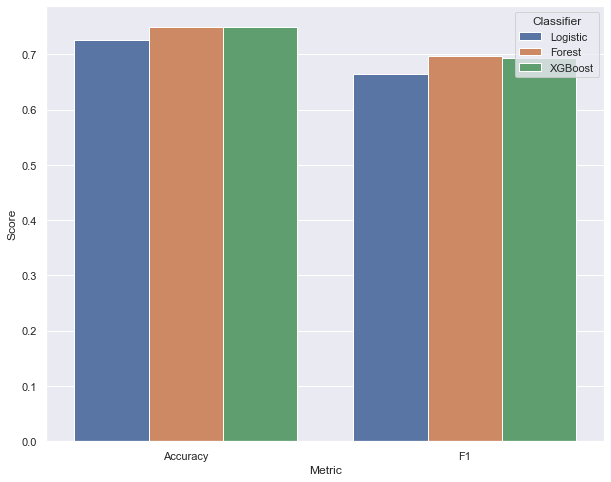

In [19]:
sns.set(rc={'figure.figsize':(10,8)})

results = pd.DataFrame()
results = results.append([{'Classifier':'Logistic','Score':0.726,'Metric':'Accuracy'},
                        {'Classifier':'Logistic','Score':0.665,'Metric':'F1'},
                        {'Classifier':'Forest','Score':0.749,'Metric':'Accuracy'},
                        {'Classifier':'Forest','Score':0.697,'Metric':'F1'},
                        {'Classifier':'XGBoost','Score':0.749,'Metric':'Accuracy'},
                        {'Classifier':'XGBoost','Score':0.693,'Metric':'F1'}])


stx = sns.barplot(x='Metric',y='Score',hue='Classifier',data=results)

Now, I perform very similar steps to those above, but on the cascade forest graph.

In [3]:
components_100 = [a for a in nx.weakly_connected_components(graph) if len(a) > 100]

In [4]:
len(components_100)

1295

In [5]:
graphs_list = []
for component in components_100:
    g = nx.subgraph(graph,component)
    graphs_list.append(g)

In [ ]:
forest_list = []
trees_list = []
for g in graphs_list:
    nodes = [n for n in g.nodes(data=True) if n[1]['posttype'] == 'post']
    if len(nodes) > 4:
        print(len(nodes))
        forest_list.append(g)
    if len(nodes) == 1:
        trees_list.append(g)

After filtering for forests with at least 100 nodes, and at least 5 parent nodes (original posts), the list is far smaller than that of the trees, with only 167 entries.

In [7]:
len(forest_list)

167

I sort the forest list and extract the largest (GME) cascade, consisting of 36695 original posts and over a million nodes.

I then sort the data into folds, as before.

In [7]:
forest_list_sorted = sorted(forest_list,key=lambda k: len(k.nodes()),reverse=True)

In [8]:
gme_forest = forest_list_sorted[0]

In [10]:
train_forests = []
test_forests = []
for i in range(1,len(forest_list_sorted)):
    if random.random() > 0.2:
        train_forests.append(forest_list_sorted[i])
    else:
        test_forests.append(forest_list_sorted[i])

In [10]:
forests_shuffled = forest_list_sorted[1:]

In [11]:
random.shuffle(forests_shuffled)

In [12]:
print(len(forests_shuffled[0].nodes()))

314


In [13]:
train_forest_folds = []
test_forest_folds = []

In [14]:
for i in range(5):
    test_forest = forests_shuffled[int(np.floor(i*len(forests_shuffled)/5)):int(np.floor((i+1)*len(forests_shuffled)/5))]
    train_forest = forests_shuffled
    train_forest = [t for t in train_forest if t not in test_forest]
    train_forest_folds.append(train_forest)
    test_forest_folds.append(test_forest)

In [15]:
len(train_forest_folds[0])

133

In [11]:
len(train_forests)

132

For the forests, I take some additional temporal features into account, including the time between posts (as opposed to all nodes), and the average time for new nodes to be added for the most quickly expanding tree within the forest.

In [4]:
def extract_features_forests(folds,start,step,step_range):
    forest_features_list = []
    for k in range(5):    
        features = pd.DataFrame()

        count = 0
        for forest in folds[k]:
            print(count)
            f = nx.DiGraph(forest)
            sorted_nodes = sorted([n for n in f.nodes(data=True)], key=lambda x: x[1]['time'])
            steps = [start + i*step for i in range(step_range)]

            for step in steps:
            #for step in [1000,1250,1500,1750,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,15000,17500,20000,22000,25000,30000,35000,40000,50000,60000,70000,80000,90000,100000,125000,150000,175000,200000]:
                if len(sorted_nodes) < step:
                    break
                count += 1
                if len(sorted_nodes) > 2*step:
                    result = 1
                else:
                    result = 0
                f_step = nx.DiGraph(nx.subgraph(f,[n[0] for n in sorted_nodes[:step]]))
                f_step_d = nx.DiGraph(nx.subgraph(f,[n[0] for n in sorted_nodes[:step]]))
                posts = [n for n in f_step.nodes(data=True) if n[1]['posttype'] == 'post']

                sorted_posts = sorted(posts,key=lambda k: k[1]['time'])
                if len(sorted_posts) == 1:
                    time_between_posts = None
                    time_between_latest_posts = None
                else:
                    time_between_posts = np.mean([sorted_posts[i][1]['time'] - sorted_posts[i-1][1]['time'] for i in range(1,len(sorted_posts))])
                    time_between_latest_posts = sorted_posts[-1][1]['time'] - sorted_posts[-2][1]['time']
                for post1 in posts:
                    for post2 in posts:
                        if f_step_d.has_edge(post1[0],post2[0]):
                            f_step_d.remove_edge(post1[0],post2[0])

                all_nodes_first_half = sorted_nodes[:int(np.floor(step/2))]
                all_nodes_second_half = sorted_nodes[int(np.floor(step/2)):step]

                avg_time_first_half_all = np.mean([all_nodes_first_half[i][1]['time'] - all_nodes_first_half[i-1][1]['time'] for i in range(1,len(all_nodes_first_half))])

                avg_time_second_half_all = np.mean([all_nodes_second_half[i][1]['time'] - all_nodes_second_half[i-1][1]['time'] for i in range(1,len(all_nodes_second_half))])
                print(avg_time_second_half_all)
                ratio_all = avg_time_second_half_all / avg_time_first_half_all

                all_nodes_first_q = sorted_nodes[:int(np.floor(step/4))]
                all_nodes_second_q = sorted_nodes[int(np.floor(step/4)):int(2*np.floor(step/4))]
                all_nodes_third_q = sorted_nodes[int(2*np.floor(step/4)):int(3*np.floor(step/4))]
                all_nodes_fourth_q = sorted_nodes[int(3*np.floor(step/4)):step]

                avg_time_first_q_all = np.mean([all_nodes_first_q[i][1]['time'] - all_nodes_first_q[i-1][1]['time'] for i in range(1,len(all_nodes_first_q))])
                avg_time_second_q_all = np.mean([all_nodes_second_q[i][1]['time'] - all_nodes_second_q[i-1][1]['time'] for i in range(1,len(all_nodes_second_q))])
                avg_time_third_q_all = np.mean([all_nodes_third_q[i][1]['time'] - all_nodes_third_q[i-1][1]['time'] for i in range(1,len(all_nodes_third_q))])
                avg_time_fourth_q_all = np.mean([all_nodes_fourth_q[i][1]['time'] - all_nodes_fourth_q[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_q))])
                ratio_43 = avg_time_fourth_q_all/avg_time_third_q_all
                ratio_42 = avg_time_fourth_q_all/avg_time_second_q_all
                ratio_41 = avg_time_fourth_q_all/avg_time_first_q_all

                all_nodes_first_10 = sorted_nodes[:int(np.floor(step/10))]
                all_nodes_second_10 = sorted_nodes[int(np.floor(step/10)):int(2*np.floor(step/10))]
                all_nodes_third_10 = sorted_nodes[int(2*np.floor(step/10)):int(3*np.floor(step/10))]
                all_nodes_fourth_10 = sorted_nodes[int(3*np.floor(step/10)):int(4*np.floor(step/10))]
                all_nodes_fifth_10 = sorted_nodes[int(4*np.floor(step/10)):int(5*np.floor(step/10))]
                all_nodes_sixth_10 = sorted_nodes[int(5*np.floor(step/10)):int(6*np.floor(step/10))]
                all_nodes_seventh_10 = sorted_nodes[int(6*np.floor(step/10)):int(7*np.floor(step/10))]
                all_nodes_eighth_10 = sorted_nodes[int(7*np.floor(step/10)):int(8*np.floor(step/10))]
                all_nodes_ninth_10 = sorted_nodes[int(8*np.floor(step/10)):int(9*np.floor(step/10))]
                all_nodes_last_10 = sorted_nodes[int(9*np.floor(step/10)):step]

                avg_time_first_10_all = np.mean([all_nodes_first_10[i][1]['time'] - all_nodes_first_10[i-1][1]['time'] for i in range(1,len(all_nodes_first_10))])
                avg_time_second_10_all = np.mean([all_nodes_second_10[i][1]['time'] - all_nodes_second_10[i-1][1]['time'] for i in range(1,len(all_nodes_second_10))])
                avg_time_third_10_all = np.mean([all_nodes_third_10[i][1]['time'] - all_nodes_third_10[i-1][1]['time'] for i in range(1,len(all_nodes_third_10))])
                avg_time_fourth_10_all = np.mean([all_nodes_fourth_10[i][1]['time'] - all_nodes_fourth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_10))])
                avg_time_fifth_10_all = np.mean([all_nodes_fifth_10[i][1]['time'] - all_nodes_fifth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fifth_10))])
                avg_time_sixth_10_all = np.mean([all_nodes_sixth_10[i][1]['time'] - all_nodes_sixth_10[i-1][1]['time'] for i in range(1,len(all_nodes_sixth_10))])
                avg_time_seventh_10_all = np.mean([all_nodes_seventh_10[i][1]['time'] - all_nodes_seventh_10[i-1][1]['time'] for i in range(1,len(all_nodes_seventh_10))])
                avg_time_eighth_10_all = np.mean([all_nodes_eighth_10[i][1]['time'] - all_nodes_eighth_10[i-1][1]['time'] for i in range(1,len(all_nodes_eighth_10))])
                avg_time_ninth_10_all = np.mean([all_nodes_ninth_10[i][1]['time'] - all_nodes_ninth_10[i-1][1]['time'] for i in range(1,len(all_nodes_ninth_10))])
                avg_time_last_10_all = np.mean([all_nodes_last_10[i][1]['time'] - all_nodes_last_10[i-1][1]['time'] for i in range(1,len(all_nodes_last_10))])

                ratio_109 = avg_time_last_10_all/avg_time_ninth_10_all
                ratio_108 = avg_time_last_10_all/avg_time_eighth_10_all
                ratio_106 = avg_time_last_10_all/avg_time_sixth_10_all
                ratio_101 = avg_time_last_10_all/avg_time_first_10_all


                comps = [a for a in nx.weakly_connected_components(f_step_d)]
                temp_list = []
                for component in comps:
                    g = nx.subgraph(f_step_d,component)
                    temp_list.append(g)
                max_graph_size = 0
                avg_graph_size = 0
                for g in temp_list:
                    if len(g.nodes()) > max_graph_size:
                        max_graph_size = len(g.nodes())
                    avg_graph_size = avg_graph_size + len(g.nodes())
                avg_graph_size = avg_graph_size/len(temp_list)
                num_trees = len(temp_list)

                avg_time_all_graphs = 0
                avg_time_fastest_graph = 500000
                avg_time_fastest_graph_first_half = 500000
                avg_time_fastest_graph_second_half = 500000
                fastest_ratio = 1
                graphcount = 0
                for g in temp_list:
                    if len(g) < 4:
                        continue
                    graphcount += 1
                    sorted_nodes_g = sorted([n for n in g.nodes(data=True)], key=lambda x: x[1]['time'])
                    avg_time_g = np.mean([sorted_nodes_g[i][1]['time'] - sorted_nodes_g[i-1][1]['time'] for i in range(1,len(sorted_nodes_g))])
                    #print(avg_time_g)
                    if avg_time_fastest_graph > avg_time_g:
                        avg_time_fastest_graph = avg_time_g
                    avg_time_all_graphs += avg_time_g
                    sorted_nodes_first_half = sorted_nodes_g[:int(np.floor(len(sorted_nodes_g)/2))]
                    avg_time_first_half_g = np.mean([sorted_nodes_first_half[i][1]['time'] - sorted_nodes_first_half[i-1][1]['time'] for i in range(1,len(sorted_nodes_first_half))])

                    sorted_nodes_second_half = sorted_nodes_g[int(np.floor(len(sorted_nodes_g)/2)):]
                    avg_time_second_half_g = np.mean([sorted_nodes_second_half[i][1]['time'] - sorted_nodes_second_half[i-1][1]['time'] for i in range(1,len(sorted_nodes_second_half))])
                    if avg_time_fastest_graph_second_half > avg_time_second_half_g:
                        avg_time_fastest_graph_second_half = avg_time_second_half_g
                        avg_time_fastest_graph_first_half = avg_time_first_half_g
                        fastest_ratio = avg_time_fastest_graph_second_half/avg_time_fastest_graph_first_half
                avg_time_all_graphs = avg_time_all_graphs/graphcount
                num_active_trees = graphcount
                ratio_active_trees = graphcount/len(temp_list)
                ratio_avg_graph_size = avg_graph_size/step
                ratio_max_graph_size = max_graph_size/step

                if len(sorted_nodes) > 200000:
                    continue
                    #gme_forest = gme_forest.append({'ratio_42':ratio_42,'ratio_41':ratio_41,'avg_time_first_half_all':avg_time_first_half_all,'avg_time_second_half_all':avg_time_second_half_all,
                       #                             'ratio_all':ratio_all,'avg_time_third_q_all':avg_time_third_q_all,'avg_time_fourth_q_all':avg_time_fourth_q_all,'ratio_43':ratio_43,
                        #'ratio_avg_graph_size':ratio_avg_graph_size,'ratio_max_graph_size':ratio_max_graph_size,'num_nodes':step,'num_trees':num_trees,'avg_graph_size':avg_graph_size,'max_graph_size':max_graph_size,'avg_time_all_graphs':avg_time_all_graphs,
                                               #    'avg_time_fastest_graph':avg_time_fastest_graph,'avg_time_fastest_graph_first_half':avg_time_fastest_graph_first_half,
                                                 #  'avg_time_fastest_graph_second_half':avg_time_fastest_graph_second_half,'fastest_ratio':fastest_ratio,'num_active_trees':num_active_trees,
                                                  # 'ratio_active_trees':ratio_active_trees,'time_between_posts':time_between_posts,'time_between_latest_posts':time_between_latest_posts,'class':result},ignore_index=True)
                else:
                    features = features.append({'avg_time_last_10_all':avg_time_last_10_all,'avg_time_ninth_10_all':avg_time_ninth_10_all,
                                                                  'avg_time_eighth_10_all':avg_time_eighth_10_all,'ratio_109':ratio_109,'ratio_108':ratio_108,'ratio_106':ratio_106,'ratio_101':ratio_101,
                        'ratio_42':ratio_42,'ratio_41':ratio_41,'avg_time_first_half_all':avg_time_first_half_all,'avg_time_second_half_all':avg_time_second_half_all,
                                                    'ratio_all':ratio_all,'avg_time_third_q_all':avg_time_third_q_all,'avg_time_fourth_q_all':avg_time_fourth_q_all,'ratio_43':ratio_43,
                        'avg_time_all_graphs':avg_time_all_graphs,
                                                   'avg_time_fastest_graph':avg_time_fastest_graph,'avg_time_fastest_graph_first_half':avg_time_fastest_graph_first_half,
                                                   'avg_time_fastest_graph_second_half':avg_time_fastest_graph_second_half,'fastest_ratio':fastest_ratio,
                                                   'time_between_posts':time_between_posts,'time_between_latest_posts':time_between_latest_posts,'class':result},ignore_index=True)

        forest_features_list.append(features)
    return forest_features_list

In [ ]:
train_forest_features_list = extract_features_forests(train_forest_folds,100,100,600)
pkl.dump(train_forest_features_list,open('train_forest_features_list.pkl','wb'))

In [18]:
test_forest_features_list = extract_features_forests(test_forest_folds,100,100,600)
pkl.dump(test_forest_features_list,open('test_forest_features_list.pkl','wb'))

In [ ]:
gme_features = pd.DataFrame()

count = 0
gme_list = []
gme_list.append(gme_forest)
for forest in gme_list:
    print(count)
    f = forest
    sorted_nodes = sorted([n for n in f.nodes(data=True)], key=lambda x: x[1]['time'])
    if len(sorted_nodes) < 500000:
        continue
    steps = [10000 + i*10000 for i in range(80)]
    
    for step in steps:
    #for step in [1000,1250,1500,1750,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,15000,17500,20000,22000,25000,30000,35000,40000,50000,60000,70000,80000,90000,100000,125000,150000,175000,200000]:
        if len(sorted_nodes) < step:
            break
        count += 1
        if len(sorted_nodes) > 2*step:
            result = 1
        else:
            result = 0
        f_step = nx.DiGraph(nx.subgraph(f,[n[0] for n in sorted_nodes[:step]]))
        f_step_d = nx.DiGraph(nx.subgraph(f,[n[0] for n in sorted_nodes[:step]]))
        posts = [n for n in f_step.nodes(data=True) if n[1]['posttype'] == 'post']
        
        sorted_posts = sorted(posts,key=lambda k: k[1]['time'])
        if len(sorted_posts) == 1:
            time_between_posts = None
            time_between_latest_posts = None
        else:
            time_between_posts = np.mean([sorted_posts[i][1]['time'] - sorted_posts[i-1][1]['time'] for i in range(1,len(sorted_posts))])
            time_between_latest_posts = sorted_posts[-1][1]['time'] - sorted_posts[-2][1]['time']
        for post1 in posts:
            for post2 in posts:
                if f_step_d.has_edge(post1[0],post2[0]):
                    f_step_d.remove_edge(post1[0],post2[0])
                    
        all_nodes_first_half = sorted_nodes[:int(np.floor(step/2))]
        all_nodes_second_half = sorted_nodes[int(np.floor(step/2)):step]
        
        avg_time_first_half_all = np.mean([all_nodes_first_half[i][1]['time'] - all_nodes_first_half[i-1][1]['time'] for i in range(1,len(all_nodes_first_half))])
        
        avg_time_second_half_all = np.mean([all_nodes_second_half[i][1]['time'] - all_nodes_second_half[i-1][1]['time'] for i in range(1,len(all_nodes_second_half))])
        print(avg_time_second_half_all)
        ratio_all = avg_time_second_half_all / avg_time_first_half_all
        
        all_nodes_first_q = sorted_nodes[:int(np.floor(step/4))]
        all_nodes_second_q = sorted_nodes[int(np.floor(step/4)):int(2*np.floor(step/4))]
        all_nodes_third_q = sorted_nodes[int(2*np.floor(step/4)):int(3*np.floor(step/4))]
        all_nodes_fourth_q = sorted_nodes[int(3*np.floor(step/4)):step]
        
        avg_time_first_q_all = np.mean([all_nodes_first_q[i][1]['time'] - all_nodes_first_q[i-1][1]['time'] for i in range(1,len(all_nodes_first_q))])
        avg_time_second_q_all = np.mean([all_nodes_second_q[i][1]['time'] - all_nodes_second_q[i-1][1]['time'] for i in range(1,len(all_nodes_second_q))])
        avg_time_third_q_all = np.mean([all_nodes_third_q[i][1]['time'] - all_nodes_third_q[i-1][1]['time'] for i in range(1,len(all_nodes_third_q))])
        avg_time_fourth_q_all = np.mean([all_nodes_fourth_q[i][1]['time'] - all_nodes_fourth_q[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_q))])
        ratio_43 = avg_time_fourth_q_all/avg_time_third_q_all
        ratio_42 = avg_time_fourth_q_all/avg_time_second_q_all
        ratio_41 = avg_time_fourth_q_all/avg_time_first_q_all
        
        all_nodes_first_10 = sorted_nodes[:int(np.floor(step/10))]
        all_nodes_second_10 = sorted_nodes[int(np.floor(step/10)):int(2*np.floor(step/10))]
        all_nodes_third_10 = sorted_nodes[int(2*np.floor(step/10)):int(3*np.floor(step/10))]
        all_nodes_fourth_10 = sorted_nodes[int(3*np.floor(step/10)):int(4*np.floor(step/10))]
        all_nodes_fifth_10 = sorted_nodes[int(4*np.floor(step/10)):int(5*np.floor(step/10))]
        all_nodes_sixth_10 = sorted_nodes[int(5*np.floor(step/10)):int(6*np.floor(step/10))]
        all_nodes_seventh_10 = sorted_nodes[int(6*np.floor(step/10)):int(7*np.floor(step/10))]
        all_nodes_eighth_10 = sorted_nodes[int(7*np.floor(step/10)):int(8*np.floor(step/10))]
        all_nodes_ninth_10 = sorted_nodes[int(8*np.floor(step/10)):int(9*np.floor(step/10))]
        all_nodes_last_10 = sorted_nodes[int(9*np.floor(step/10)):step]
                                                                       
        avg_time_first_10_all = np.mean([all_nodes_first_10[i][1]['time'] - all_nodes_first_10[i-1][1]['time'] for i in range(1,len(all_nodes_first_10))])
        avg_time_second_10_all = np.mean([all_nodes_second_10[i][1]['time'] - all_nodes_second_10[i-1][1]['time'] for i in range(1,len(all_nodes_second_10))])
        avg_time_third_10_all = np.mean([all_nodes_third_10[i][1]['time'] - all_nodes_third_10[i-1][1]['time'] for i in range(1,len(all_nodes_third_10))])
        avg_time_fourth_10_all = np.mean([all_nodes_fourth_10[i][1]['time'] - all_nodes_fourth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_10))])
        avg_time_fifth_10_all = np.mean([all_nodes_fifth_10[i][1]['time'] - all_nodes_fifth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fifth_10))])
        avg_time_sixth_10_all = np.mean([all_nodes_sixth_10[i][1]['time'] - all_nodes_sixth_10[i-1][1]['time'] for i in range(1,len(all_nodes_sixth_10))])
        avg_time_seventh_10_all = np.mean([all_nodes_seventh_10[i][1]['time'] - all_nodes_seventh_10[i-1][1]['time'] for i in range(1,len(all_nodes_seventh_10))])
        avg_time_eighth_10_all = np.mean([all_nodes_eighth_10[i][1]['time'] - all_nodes_eighth_10[i-1][1]['time'] for i in range(1,len(all_nodes_eighth_10))])
        avg_time_ninth_10_all = np.mean([all_nodes_ninth_10[i][1]['time'] - all_nodes_ninth_10[i-1][1]['time'] for i in range(1,len(all_nodes_ninth_10))])
        avg_time_last_10_all = np.mean([all_nodes_last_10[i][1]['time'] - all_nodes_last_10[i-1][1]['time'] for i in range(1,len(all_nodes_last_10))])
        
        ratio_109 = avg_time_last_10_all/avg_time_ninth_10_all
        ratio_108 = avg_time_last_10_all/avg_time_eighth_10_all
        ratio_106 = avg_time_last_10_all/avg_time_sixth_10_all
        ratio_101 = avg_time_last_10_all/avg_time_first_10_all
                    
        
        comps = [a for a in nx.weakly_connected_components(f_step_d)]
        temp_list = []
        for component in comps:
            g = nx.subgraph(f_step_d,component)
            temp_list.append(g)
        max_graph_size = 0
        avg_graph_size = 0
        for g in temp_list:
            if len(g.nodes()) > max_graph_size:
                max_graph_size = len(g.nodes())
            avg_graph_size = avg_graph_size + len(g.nodes())
        avg_graph_size = avg_graph_size/len(temp_list)
        num_trees = len(temp_list)
        
        avg_time_all_graphs = 0
        avg_time_fastest_graph = 500000
        avg_time_fastest_graph_first_half = 500000
        avg_time_fastest_graph_second_half = 500000
        fastest_ratio = 1
        graphcount = 0
        for g in temp_list:
            if len(g) < 4:
                continue
            graphcount += 1
            sorted_nodes_g = sorted([n for n in g.nodes(data=True)], key=lambda x: x[1]['time'])
            avg_time_g = np.mean([sorted_nodes_g[i][1]['time'] - sorted_nodes_g[i-1][1]['time'] for i in range(1,len(sorted_nodes_g))])
            #print(avg_time_g)
            if avg_time_fastest_graph > avg_time_g:
                avg_time_fastest_graph = avg_time_g
            avg_time_all_graphs += avg_time_g
            sorted_nodes_first_half = sorted_nodes_g[:int(np.floor(len(sorted_nodes_g)/2))]
            avg_time_first_half_g = np.mean([sorted_nodes_first_half[i][1]['time'] - sorted_nodes_first_half[i-1][1]['time'] for i in range(1,len(sorted_nodes_first_half))])
            
            sorted_nodes_second_half = sorted_nodes_g[int(np.floor(len(sorted_nodes_g)/2)):]
            avg_time_second_half_g = np.mean([sorted_nodes_second_half[i][1]['time'] - sorted_nodes_second_half[i-1][1]['time'] for i in range(1,len(sorted_nodes_second_half))])
            if avg_time_fastest_graph_second_half > avg_time_second_half_g:
                avg_time_fastest_graph_second_half = avg_time_second_half_g
                avg_time_fastest_graph_first_half = avg_time_first_half_g
                fastest_ratio = avg_time_fastest_graph_second_half/avg_time_fastest_graph_first_half
        avg_time_all_graphs = avg_time_all_graphs/graphcount
        num_active_trees = graphcount
        ratio_active_trees = graphcount/len(temp_list)
        ratio_avg_graph_size = avg_graph_size/step
        ratio_max_graph_size = max_graph_size/step
        
        if len(sorted_nodes) > 500000:
            gme_features = gme_features.append({'avg_time_last_10_all':avg_time_last_10_all,'avg_time_ninth_10_all':avg_time_ninth_10_all,
                                                          'avg_time_eighth_10_all':avg_time_eighth_10_all,'ratio_109':ratio_109,'ratio_108':ratio_108,'ratio_106':ratio_106,'ratio_101':ratio_101,
                'ratio_42':ratio_42,'ratio_41':ratio_41,'avg_time_first_half_all':avg_time_first_half_all,'avg_time_second_half_all':avg_time_second_half_all,
                                            'ratio_all':ratio_all,'avg_time_third_q_all':avg_time_third_q_all,'avg_time_fourth_q_all':avg_time_fourth_q_all,'ratio_43':ratio_43,
                'avg_time_all_graphs':avg_time_all_graphs,
                                           'avg_time_fastest_graph':avg_time_fastest_graph,'avg_time_fastest_graph_first_half':avg_time_fastest_graph_first_half,
                                           'avg_time_fastest_graph_second_half':avg_time_fastest_graph_second_half,'fastest_ratio':fastest_ratio,
                                           'time_between_posts':time_between_posts,'time_between_latest_posts':time_between_latest_posts,'class':result},ignore_index=True)

In [10]:
gme_features.to_csv('gme_features.csv')

In [11]:
train_forest_features_list = pkl.load(open('train_forest_features_list.pkl','rb'))
test_forest_features_list = pkl.load(open('test_forest_features_list.pkl','rb'))

The train and test sets are a lot smaller than for the tree data, but a much more respectable size than before, after extracting multiple data points for each forest.

In [142]:
print(train_forest_features_list[0].shape)
print(test_forest_features_list[0].shape)

(3143, 23)
(322, 23)


I fill possible NaN values for two of the features with the column means.

In [12]:
for i in range(5):
    train_forest_features_list[i]['time_between_latest_posts'].fillna(value=train_forest_features_list[i]['time_between_latest_posts'].mean(), inplace=True)
    train_forest_features_list[i]['time_between_posts'].fillna(value=train_forest_features_list[i]['time_between_posts'].mean(), inplace=True)
    test_forest_features_list[i]['time_between_latest_posts'].fillna(value=test_forest_features_list[i]['time_between_latest_posts'].mean(), inplace=True)
    test_forest_features_list[i]['time_between_posts'].fillna(value=test_forest_features_list[i]['time_between_posts'].mean(), inplace=True)

In [13]:
for i in range(5):
    train_forest_features_list[i]['result'] = train_forest_features_list[i]['class']
    train_forest_features_list[i] = train_forest_features_list[i].drop('class',axis=1)
    test_forest_features_list[i]['result'] = test_forest_features_list[i]['class']
    test_forest_features_list[i] = test_forest_features_list[i].drop('class',axis=1)

In [47]:
gme_features = pd.read_csv('gme_features.csv',index_col=0)

In [117]:
gme_features

,avg_time_all_graphs,avg_time_eighth_10_all,avg_time_fastest_graph,avg_time_fastest_graph_first_half,avg_time_fastest_graph_second_half,avg_time_first_half_all,avg_time_fourth_q_all,avg_time_last_10_all,avg_time_ninth_10_all,avg_time_second_half_all,...,ratio_106,ratio_108,ratio_109,ratio_41,ratio_42,ratio_43,ratio_all,time_between_latest_posts,time_between_posts,result
0,487.047191,4.506507,5.904011,3.905172,7.885387,37.414683,3.467387,2.939940,3.411411,3.588518,...,0.915809,0.652377,0.861796,0.048054,1.290010,0.934433,0.095912,228.0,832.975610,1.0
1,944.327793,12.462731,21.760000,32.250000,12.916667,20.500850,5.820164,3.941471,5.449725,6.875288,...,0.832435,0.316261,0.723242,0.155558,1.621885,0.733796,0.335366,8.0,598.875274,1.0
2,819.063526,3.117372,17.659692,56.000000,11.000000,16.310621,2.910521,2.899633,2.915639,3.907527,...,0.410111,0.930153,0.994511,0.111174,0.451697,0.593436,0.239569,53.0,443.982430,1.0
3,873.487892,2.855464,17.602778,56.000000,11.000000,13.687634,4.548755,5.725681,4.194549,3.750038,...,1.897489,2.005167,1.365029,0.221881,0.661609,1.541117,0.273973,344.0,392.249719,1.0
4,851.330650,5.805561,21.000000,56.000000,11.000000,11.539782,3.596128,3.697339,3.119624,3.774191,...,1.251557,0.636862,1.185188,0.206083,0.638702,0.909842,0.327059,101.0,323.297297,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1443.593312,0.806208,4.908449,66.000000,0.000000,3.717962,0.672961,0.712207,0.444927,0.624299,...,0.842876,0.883403,1.600728,0.110701,0.495977,1.169099,0.167914,12.0,61.885384,0.0
76,1468.355037,0.798816,5.189719,66.000000,0.000000,3.686272,0.656954,0.711503,0.448564,0.611854,...,0.925798,0.890697,1.586178,0.108517,0.498209,1.159169,0.165982,129.0,61.695984,0.0
77,1480.561209,0.795664,4.792653,66.000000,0.000000,3.649463,0.627372,0.702317,0.444454,0.605394,...,0.971018,0.882680,1.580177,0.104191,0.491057,1.075367,0.165886,36.0,61.420973,0.0
78,1502.864086,0.790111,2.975531,66.000000,0.000000,3.608470,0.579922,0.694680,0.434259,0.603219,...,0.985526,0.879218,1.599691,0.096695,0.475545,0.925662,0.167168,1.0,61.098869,0.0


In [14]:
gme_features['time_between_latest_posts'].fillna(value=gme_features['time_between_latest_posts'].mean(), inplace=True)
gme_features['time_between_posts'].fillna(value=gme_features['time_between_posts'].mean(), inplace=True)

In [15]:
gme_features['result'] = gme_features['class']
gme_features = gme_features.drop('class',axis=1)

Aa before, I iterate over the data using the three different machine learning models.

In [128]:
best_C_acc = 1
best_C_f1 = 1
best_accuracy = 0
best_f1 = 0

for C in [1,0.5,0.25,0.1,0.05,0.025,0.01]:
    av_accuracy = 0
    av_f1 = 0
    for i in range(5):
        X_train = train_forest_features_list[i].iloc[:,:-1]
        y_train = train_forest_features_list[i].iloc[:,-1]
        X_test = test_forest_features_list[i].iloc[:,:-1]
        y_test = test_forest_features_list[i].iloc[:,-1]
    
        xg = make_pipeline(StandardScaler(),LogisticRegression(C=C))
        xg.fit(X_train,y_train)
        y_pred = xg.predict(X_test)
        #print(f1_score(y_test,y_pred))
        #print(accuracy_score(y_pred,y_test))
        av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
        av_f1 = av_f1 + f1_score(y_test,y_pred)
    av_accuracy = av_accuracy/5
    av_f1 = av_f1/5
    if av_accuracy > best_accuracy:
        best_accuracy = av_accuracy
        best_C_acc = C
    if av_f1 > best_f1:
        best_f1 = av_f1
        best_C_f1 = C
print(best_C_acc)
print(best_accuracy)
print(best_C_f1)
print(best_f1)

1
0.6627026014403496
1
0.7056516792990732


In [129]:
best_estimators_acc = [2,10]
best_estimators_f1 = [2,10]
best_accuracy = 0
best_f1 = 0
for max_depth in [2,3,4,5,6,7,8]:
    for n_estimators in [10,50,100,200,350,500,750,1000]:
        av_accuracy = 0
        av_f1 = 0
        for i in range(5):
            X_train = train_forest_features_list[i].iloc[:,:-1]
            y_train = train_forest_features_list[i].iloc[:,-1]
            X_test = test_forest_features_list[i].iloc[:,:-1]
            y_test = test_forest_features_list[i].iloc[:,-1]

            xg = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
            xg.fit(X_train,y_train)
            y_pred = xg.predict(X_test)
            #print(f1_score(y_test,y_pred))
            #print(accuracy_score(y_pred,y_test))
            av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
            av_f1 = av_f1 + f1_score(y_test,y_pred)
        av_accuracy = av_accuracy/5
        av_f1 = av_f1/5
        if av_accuracy > best_accuracy:
            best_accuracy = av_accuracy
            best_estimators_acc = [max_depth,n_estimators]
        if av_f1 > best_f1:
            best_f1 = av_f1
            best_estimators_f1 = [max_depth,n_estimators]
print(best_estimators_acc)
print(best_accuracy)
print(best_estimators_f1)
print(best_f1)

[8, 100]
0.6765959351443689
[4, 50]
0.7056945801247667


In [ ]:
best_estimators_acc = [2,10]
best_estimators_f1 = [2,10]
best_accuracy = 0
best_f1 = 0
for max_depth in [2,3,4,5,6,7,8]:
    for n_estimators in [10,50,100,200,350,500,750,1000]:
        av_accuracy = 0
        av_f1 = 0
        for i in range(5):
            X_train = train_forest_features_list[i].iloc[:,:-1]
            y_train = train_forest_features_list[i].iloc[:,-1]
            X_test = test_forest_features_list[i].iloc[:,:-1]
            y_test = test_forest_features_list[i].iloc[:,-1]

            xg = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth)
            xg.fit(X_train,y_train)
            y_pred = xg.predict(X_test)
            av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
            av_f1 = av_f1 + f1_score(y_test,y_pred)
        av_accuracy = av_accuracy/5
        av_f1 = av_f1/5
        if av_accuracy > best_accuracy:
            best_accuracy = av_accuracy
            best_estimators_acc = [max_depth,n_estimators]
        if av_f1 > best_f1:
            best_f1 = av_f1
            best_estimators_f1 = [max_depth,n_estimators]
print(best_estimators_acc)
print(best_accuracy)
print(best_estimators_f1)
print(best_f1)

In this case, they all perform similarly in terms of accuracy, with Logistic Regression and Random Forest performing a little better when it comes to F1 score.

Here is a graphical display of the results for cascade forests.

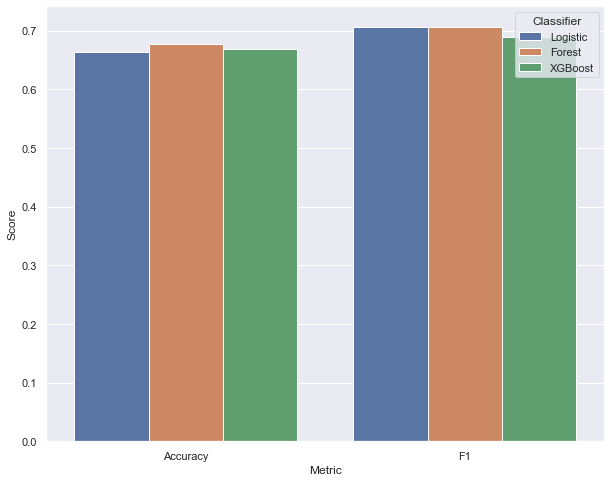

In [17]:
sns.set(rc={'figure.figsize':(10,8)})

results = pd.DataFrame()
results = results.append([{'Classifier':'Logistic','Score':0.663,'Metric':'Accuracy'},
                        {'Classifier':'Logistic','Score':0.706,'Metric':'F1'},
                        {'Classifier':'Forest','Score':0.677,'Metric':'Accuracy'},
                        {'Classifier':'Forest','Score':0.706,'Metric':'F1'},
                        {'Classifier':'XGBoost','Score':0.669,'Metric':'Accuracy'},
                        {'Classifier':'XGBoost','Score':0.690,'Metric':'F1'}])


stx = sns.barplot(x='Metric',y='Score',hue='Classifier',data=results)

As a final test, I evaluate the Logistic Regression and Random Forest models on the GME cascade data, training the models on both the original train data and test data.

In [133]:
for i in range(5):
    X_train = train_forest_features_list[i].iloc[:,:-1]
    y_train = train_forest_features_list[i].iloc[:,-1]
    X_test = test_forest_features_list[i].iloc[:,:-1]
    y_test = test_forest_features_list[i].iloc[:,-1]
    
    X_train_all = X_train.append(X_test)
    y_train_all = y_train.append(y_test)
    
    logreg = make_pipeline(StandardScaler(),LogisticRegression(C=1))
    logreg.fit(X_train_all,y_train_all)
    gme_pred = logreg.predict(gme_features.iloc[:,:-1])
    
    print('gme score: ')
    print(accuracy_score(gme_features.iloc[:,-1],gme_pred))
    print('f1 score: ')
    print(f1_score(gme_features.iloc[:,-1],gme_pred))
    
    

gme score: 
0.6
f1 score: 
0.7241379310344828
gme score: 
0.6
f1 score: 
0.7241379310344828
gme score: 
0.6
f1 score: 
0.7241379310344828
gme score: 
0.6
f1 score: 
0.7241379310344828
gme score: 
0.6
f1 score: 
0.7241379310344828


In [137]:
for i in range(5):
    X_train = train_forest_features_list[i].iloc[:,:-1]
    y_train = train_forest_features_list[i].iloc[:,-1]
    X_test = test_forest_features_list[i].iloc[:,:-1]
    y_test = test_forest_features_list[i].iloc[:,-1]
    
    X_train_all = X_train.append(X_test)
    y_train_all = y_train.append(y_test)
    
    rf = RandomForestClassifier(n_estimators=50,max_depth=4)
    rf.fit(X_train_all,y_train_all)
    gme_pred = rf.predict(gme_features.iloc[:,:-1])
    
    print('gme score: ')
    print(accuracy_score(gme_features.iloc[:,-1],gme_pred))
    print('f1 score: ')
    print(f1_score(gme_features.iloc[:,-1],gme_pred))

gme score: 
0.25
f1 score: 
0.03225806451612903
gme score: 
0.2625
f1 score: 
0.06349206349206349
gme score: 
0.25
f1 score: 
0.03225806451612903
gme score: 
0.2625
f1 score: 
0.06349206349206349
gme score: 
0.2625
f1 score: 
0.06349206349206349


Rather disappointingly, the Logistic Regression model performs notably worse than on the other test data, and the Random Forest performs abysmally. I was hopeful that there would be enough similarity in temporal structure bwteen large cascades and the huge GME cascade, but perhaps this was a naive assumption. The GME cascade will naturally have a more complex pattern, as it consists of thousands of post-comment trees.

In conclusion, while this did not come up with the result I would ideally like to have achieved, the predictions on the rest of the data were reasonably good, at around 70% F1 score for both tree data and forest data. There are many more explorations that could be made into this topic, including incorporating more temporal features, restructuring the testing process to allow for the incorporation of other features, and perhaps most importantly, gathering more cascade forest data. Since I was exclusively using temporal features in my analysis, the model could in theory be trained on any reddit cascades, and this logic would also apply to structural features.

One reason why I disregarded user-specific features in this analysis is that reddit has a much larger degree of anonymity than twitter or other social networks: while there definitely popular content creators, there is much less of a 'celebrity' culture on the site. Additionally, there is no way (to my knowledge) to extract the number of followers for a specific reddit user.

This has also been a valuable process for me, in which I have become familiar with a number of new tools, and got the opportunity to explore an interesting topic.